# Book Genre Prediction - Exploratory Data Analysis and Modelling

**Dataset:** Best Books (10k) Multi-Genre Data from Kaggle  
**Purpose:** EDA and modelling for multi-label genre classification project  
**Course:** Text and Media Analytics (INFOTMA) 2025-2026


---

<a id='step0'></a>
## Step 0: Setup and Imports

In [1]:
import torch

# Check for GPU (CUDA)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
# Check for Apple Silicon (MPS)
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon (MPS) GPU")
# Fallback to CPU
else:
    device = torch.device("cpu")
    print("Using CPU")


Using GPU: Tesla T4


In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
import re
import string
import ast
from collections import Counter
from itertools import chain


# NLP tools
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag


# Multi-label utilities
from sklearn.preprocessing import MultiLabelBinarizer

# Word cloud
from wordcloud import WordCloud

# JSON for saving summary
import json

# Seed setting for reproducibility
import random
import numpy as np
import torch
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

In [3]:
# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
nltk.download('wordnet', quiet=True)
lemmatizer = WordNetLemmatizer()

In [4]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Set figure size defaults
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

---

<a id='step1'></a>
## Step 1: Load and Inspect Data

#### In this step we load the data and inspect it by:


*   Checking the shape, types and some descriptive statistics
*   We remove redundant columns and check for missing data and duplicates



### 1.1 Load the Dataset

In [5]:
df = pd.read_csv('goodreads_data.csv',on_bad_lines='skip')

df.head()

,Unnamed: 0,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,URL
0,0,To Kill a Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sleepy Southern town and the crisis of conscience th...,"['Classics', 'Fiction', 'Historical Fiction', 'School', 'Literature', 'Young Adult', 'Historical']",4.27,"5,691,311",https://www.goodreads.com/book/show/2657.To_Kill_a_Mockingbird
1,1,"Harry Potter and the Philosopher’s Stone (Harry Potter, #1)",J.K. Rowling,"Harry Potter thinks he is an ordinary boy - until he is rescued by an owl, taken to Hogwarts Sch...","['Fantasy', 'Fiction', 'Young Adult', 'Magic', 'Childrens', 'Middle Grade', 'Classics']",4.47,"9,278,135",https://www.goodreads.com/book/show/72193.Harry_Potter_and_the_Philosopher_s_Stone
2,2,Pride and Prejudice,Jane Austen,"Since its immediate success in 1813, Pride and Prejudice has remained one of the most popular no...","['Classics', 'Fiction', 'Romance', 'Historical Fiction', 'Literature', 'Historical', 'Audiobook']",4.28,"3,944,155",https://www.goodreads.com/book/show/1885.Pride_and_Prejudice
3,3,The Diary of a Young Girl,Anne Frank,"Discovered in the attic in which she spent the last years of her life, Anne Frank’s remarkable d...","['Classics', 'Nonfiction', 'History', 'Biography', 'Memoir', 'Historical', 'Holocaust']",4.18,"3,488,438",https://www.goodreads.com/book/show/48855.The_Diary_of_a_Young_Girl
4,4,Animal Farm,George Orwell,Librarian's note: There is an Alternate Cover Edition for this edition of this book here.A farm ...,"['Classics', 'Fiction', 'Dystopia', 'Fantasy', 'Politics', 'School', 'Literature']",3.98,"3,575,172",https://www.goodreads.com/book/show/170448.Animal_Farm


### 1.2 Basic Inspection

In [6]:
# Dataset shape
print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

Dataset Shape: 10,000 rows × 8 columns


In [7]:
# Column names
print("Column Names:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i}. {col}")

Column Names:
  1. Unnamed: 0
  2. Book
  3. Author
  4. Description
  5. Genres
  6. Avg_Rating
  7. Num_Ratings
  8. URL


In [8]:
# Data types
df.dtypes

,0
Unnamed: 0,int64
Book,object
Author,object
Description,object
Genres,object
Avg_Rating,float64
Num_Ratings,object
URL,object


In [9]:
# Dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   10000 non-null  int64  
 1   Book         10000 non-null  object 
 2   Author       10000 non-null  object 
 3   Description  9923 non-null   object 
 4   Genres       10000 non-null  object 
 5   Avg_Rating   10000 non-null  float64
 6   Num_Ratings  10000 non-null  object 
 7   URL          10000 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 625.1+ KB


In [10]:
# Basic statistics for numerical columns
df.describe()

,Unnamed: 0,Avg_Rating
count,10000.00000,10000.000000
mean,4999.50000,4.068577
std,2886.89568,0.335359
min,0.00000,0.000000
25%,2499.75000,3.880000
50%,4999.50000,4.080000
75%,7499.25000,4.260000
max,9999.00000,5.000000


In [11]:
#drop unnamed column
df= df.drop(columns=['Unnamed: 0'])

### 1.3 Missing Values Analysis

In [12]:
# Count missing values
missing_counts = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing Count': missing_counts.values,
    'Missing %': missing_percent.values
})
missing_df = missing_df.sort_values('Missing Count', ascending=False)

print("Missing Values Summary:")
print(missing_df.to_string(index=False))

Missing Values Summary:
     Column  Missing Count  Missing %
Description             77       0.77
       Book              0       0.00
     Author              0       0.00
     Genres              0       0.00
 Avg_Rating              0       0.00
Num_Ratings              0       0.00
        URL              0       0.00


### 1.4 Duplicate Check

In [13]:
# Check for duplicates
total_duplicates = df.duplicated().sum()
title_duplicates = df['Book'].duplicated().sum()

print(f"Total duplicate rows: {total_duplicates}")
print(f"Duplicate book titles: {title_duplicates}")

Total duplicate rows: 0
Duplicate book titles: 129


In [14]:
# Show sample duplicates if any
if title_duplicates > 0:
    print("\nSample duplicate titles:")
    dup_titles = df[df['Book'].duplicated(keep=False)]['Book'].value_counts().head(5)
    print(dup_titles)


Sample duplicate titles:
Book
The Hunger Games (The Hunger Games, #1)     4
The Oldest Dance (Wisdom Revolution, #2)    4
The Nightingale                             4
Ready Player One (Ready Player One, #1)     3
All the Light We Cannot See                 3
Name: count, dtype: int64


In [15]:
#example of duplicated title
df[df['Book'] == 'The Hunger Games (The Hunger Games, #1)']

,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,URL
21,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,"Could you survive on your own in the wild, with every one out to make sure you don't live to see...","['Young Adult', 'Fiction', 'Dystopia', 'Fantasy', 'Science Fiction', 'Romance', 'Adventure']",4.33,"7,963,002",https://www.goodreads.com/book/show/2767052-the-hunger-games
4868,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,"Sometime in the future after the destruction of North America in a nation known as Panem, the 74...","['Young Adult', 'Fiction', 'Dystopia', 'Fantasy', 'Science Fiction', 'Romance', 'Adventure']",4.33,"7,963,186",https://www.goodreads.com/book/show/12091570-the-hunger-games
4894,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,"In the ruins of a place once known as North America lies the nation of Panem, a shining Capitol ...","['Young Adult', 'Fiction', 'Dystopia', 'Fantasy', 'Science Fiction', 'Romance', 'Adventure']",4.33,"7,963,186",https://www.goodreads.com/book/show/18626858-the-hunger-games
8608,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,"Could you survive on your own in the wild, with every one out to make sure you don't live to see...","['Young Adult', 'Fiction', 'Dystopia', 'Fantasy', 'Science Fiction', 'Romance', 'Adventure']",4.33,"7,963,186",https://www.goodreads.com/book/show/12187803-the-hunger-games


In [16]:
# Remove duplicates if they exist
if total_duplicates > 0:
    df_clean = df.drop_duplicates()
    print(f"Removed {total_duplicates} duplicate rows.")
    print(f"New shape: {df_clean.shape}")
else:
    df_clean = df.copy()
    print("No duplicates to remove.")

No duplicates to remove.


---

<a id='step2'></a>
## Step 2: Genre Analysis (Target Variable)

#### In this section we focus on the target variables: genre labels. The following adjustments and analysis are performed:


*   The genre is parsed into a Python list to make it easier to work with
*   Run a check on books with no genres and remove them
*   Check the number of unique genres, the top 15 most common and top 15 most rare
*   Remove too board and non-content genres, merge similar genres and check similarity of genres based on co-occurance
*   Check genres distribution per book
*   Check most frequenty co-occuring genres



### 2.1 Parse the Genres Column

In [17]:
# Check the raw format
print("Sample raw genre entry:")
print(df_clean['Genres'].iloc[0])
print(f"\nType: {type(df_clean['Genres'].iloc[0])}")

Sample raw genre entry:
['Classics', 'Fiction', 'Historical Fiction', 'School', 'Literature', 'Young Adult', 'Historical']

Type: <class 'str'>


In [18]:
def parse_genres(genre_str):
    """
    Parse the genres string into a Python list.
    """

    # parse as literal Python list
    try:
        parsed = ast.literal_eval(genre_str)
        if isinstance(parsed, list):
            return parsed
    except (ValueError, SyntaxError):
        pass

    # If it's a comma-separated string
    if isinstance(genre_str, str):
        # Remove brackets if present
        genre_str = genre_str.strip('[]')
        # Split by comma and clean
        genres = [g.strip().strip("'\"") for g in genre_str.split(',')]
        return [g for g in genres if g]  # Remove empty strings

    return []

In [19]:
# Apply parsing
df_clean['genres_list'] = df_clean['Genres'].apply(parse_genres)

# Verify parsing
print("After parsing - sample genres:")
for i in range(3):
    genres = df_clean['genres_list'].iloc[i]
    print(f"  Book {i+1}: {genres[:5]}{'...' if len(genres) > 5 else ''}")

After parsing - sample genres:
  Book 1: ['Classics', 'Fiction', 'Historical Fiction', 'School', 'Literature']...
  Book 2: ['Fantasy', 'Fiction', 'Young Adult', 'Magic', 'Childrens']...
  Book 3: ['Classics', 'Fiction', 'Romance', 'Historical Fiction', 'Literature']...


In [20]:
# Check for books with no genres
no_genres = df_clean['genres_list'].apply(len) == 0
print(f"Books with no genres: {no_genres.sum()}")

Books with no genres: 960


In [21]:
df_clean[df_clean['genres_list'].apply(len) == 0].head()

,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,URL,genres_list
915,سیمای شکسته پدر سالار,سید مرتضی مصطفوی,"رمان بلند ""سیمای شکسته پدر سالار"" که از تعلیق و کشش بالایی بر خوردار است خانواده ای را به تصویر...",[],3.30,518,https://www.goodreads.com/book/show/40941784,[]
1098,Life Song,Christine M. Knight,"Overview: Mavis was born to be a songbird. Her parents named her after one, a bird with a distin...",[],4.16,91,https://www.goodreads.com/book/show/18251020-life-song,[]
1193,Stones (One True Child #5),L.C. Conn,"Deep within the New Zealand bush, lies a plateau with a clearing, covered over by many years of ...",[],4.43,128,https://www.goodreads.com/book/show/44164186-stones,[]
1195,The Adventures of Pinocchio,Carlo Collodi,Excellent condition. Fast shipping. 100% satisfaction guaranteed.,[],3.64,"1,397",https://www.goodreads.com/book/show/6059070-the-adventures-of-pinocchio,[]
1244,Touching the moon,Malcolm McCoard,"""Magical mayhem, an emotional roller-coaster, hilarious and heart-warming!"" Third in the series ...",[],4.28,104,https://www.goodreads.com/book/show/43077954-touching-the-moon,[]


In [22]:
#drop books that have no genres
df_clean = df_clean[df_clean['genres_list'].apply(len) > 0]

### 2.2 Count Unique Genres

In [23]:
# Flatten all genres into one list
all_genres = list(chain.from_iterable(df_clean['genres_list']))

# Count occurrences
genre_counts = Counter(all_genres)

print(f"Total number of unique genres: {len(genre_counts)}")
print(f"Total genre tags assigned: {len(all_genres):,}")

Total number of unique genres: 617
Total genre tags assigned: 57,963


In [24]:
print(set(all_genres))

{'Disability', 'Batman', 'Dungeons and Dragons', 'Polygamy', 'Trains', 'Nutrition', 'Suspense', 'Polish Literature', 'Westerns', 'Far Right', 'Biblical Fiction', 'Tv', 'Apocalyptic', 'Business', 'Counter Culture', 'Africa', 'Native Americans', 'British Literature', 'Occult', 'Social Justice', 'Italy', 'Nursery Rhymes', 'Portuguese Literature', 'Thriller', 'English Literature', 'Fantasy', 'Vampires', 'Psychology', 'Mauritius', 'Gothic Horror', 'Survival', 'Relationships', 'The United States Of America', 'Astronomy', 'Futurism', 'Art Design', 'Guidebook', 'Drawing', 'Wicca', 'Fairy Tale Retellings', 'Islam', 'Journal', 'Alchemy', 'Victorian', 'Sociology', 'Mental Illness', 'Canadian Literature', 'Fostering', 'Christian Romance', 'Manga', 'Political Science', 'Mysticism', 'Social Issues', 'Travel', 'Lovecraftian', 'Judaica', 'Russian Literature', 'Thelema', 'Theory', 'Detective', 'Dark Fantasy', 'Hungarian Literature', 'Geology', 'Art History', 'Modern', 'Realistic Fiction', 'Lesbian', 'S

In [25]:
# Top 15 most common genres
print("Top 15 Most Common Genres:")
print("-" * 40)
for i, (genre, count) in enumerate(genre_counts.most_common(15), 1):
    pct = count / len(df_clean) * 100 #percentage of occurance over the dataset
    print(f"{i:2}. {genre}: {count:,} books ({pct:.1f}%)")

Top 15 Most Common Genres:
----------------------------------------
 1. Fiction: 5,700 books (63.1%)
 2. Nonfiction: 2,330 books (25.8%)
 3. Fantasy: 2,195 books (24.3%)
 4. Classics: 2,123 books (23.5%)
 5. Romance: 1,558 books (17.2%)
 6. Young Adult: 1,522 books (16.8%)
 7. Historical Fiction: 1,481 books (16.4%)
 8. Mystery: 1,357 books (15.0%)
 9. Contemporary: 1,302 books (14.4%)
10. Audiobook: 1,242 books (13.7%)
11. Novels: 1,164 books (12.9%)
12. Literature: 1,110 books (12.3%)
13. Thriller: 1,021 books (11.3%)
14. Historical: 942 books (10.4%)
15. Science Fiction: 845 books (9.3%)


In [26]:
# Bottom 10 rarest genres
print("Bottom 10 Rarest Genres:")
print("-" * 40)
for genre, count in genre_counts.most_common()[-10:]:
    print(f"  - {genre}: {count} books")

Bottom 10 Rarest Genres:
----------------------------------------
  - Love Inspired Historical: 1 books
  - Journal: 1 books
  - Mauritius: 1 books
  - Alternate Universe: 1 books
  - Illness: 1 books
  - Comix: 1 books
  - Wicca: 1 books
  - Witchcraft: 1 books
  - Science Fiction Romance: 1 books
  - New Adult Romance: 1 books


### 2.3 Visualise Genre Frequency

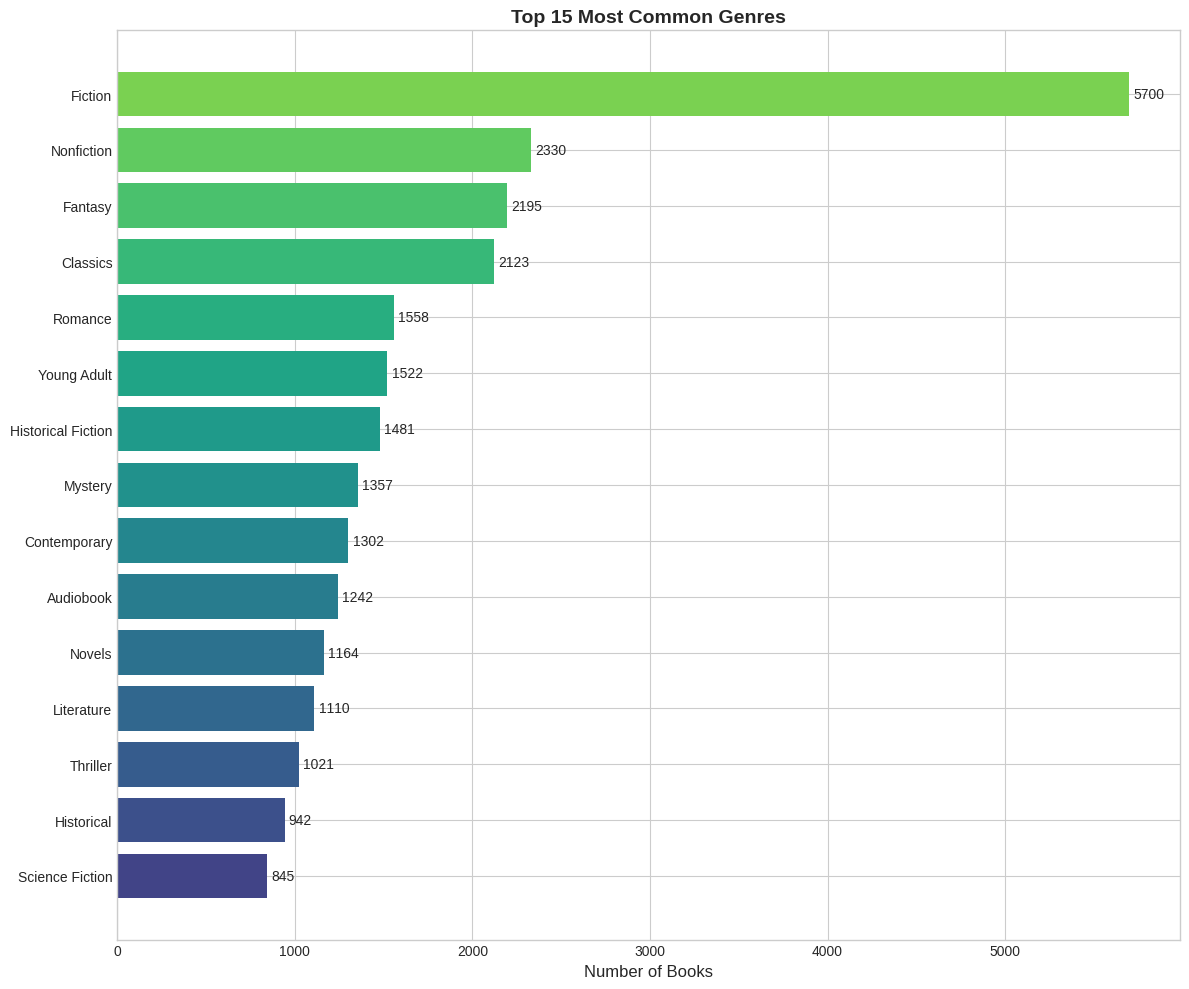

In [27]:
# Top 15 genres bar chart
top_n = 15
top_genres = genre_counts.most_common(top_n)
genres_df = pd.DataFrame(top_genres, columns=['Genre', 'Count'])

fig, ax = plt.subplots(figsize=(12, 10))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, top_n))
bars = ax.barh(genres_df['Genre'][::-1], genres_df['Count'][::-1], color=colors)
ax.set_xlabel('Number of Books', fontsize=12)
ax.set_title(f'Top {top_n} Most Common Genres', fontsize=14, fontweight='bold')
ax.bar_label(bars, padding=3)
plt.tight_layout()
plt.savefig('eda_02_genre_frequency.png', dpi=150, bbox_inches='tight')
plt.show()

In [28]:
#handle imbalance of genre + redundant genre
#we decided to drop fiction genre as it occured for more than half of the dataset
#also other genres already contain fiction in like "Science Fiction" or "Historical fiction"

def remove_fiction_genre(genres):
    """Removes 'Fiction' from a list of genres."""
    return [genre for genre in genres if genre != 'Fiction']

def remove_non_fiction_genre(genres):
    """Removes 'Non-Fiction' from a list of genres."""
    return [genre for genre in genres if genre != 'Nonfiction']

df_clean['genres_list'] = df_clean['genres_list'].apply(remove_fiction_genre)
df_clean['genres_list'] = df_clean['genres_list'].apply(remove_non_fiction_genre)

# Recalculate genre counts after removing 'Fiction'
all_genres = list(chain.from_iterable(df_clean['genres_list']))
genre_counts = Counter(all_genres)

print(f"Total number of unique genres after removing 'Fiction': {len(genre_counts)}")
print(f"Total genre tags assigned after removing 'Fiction': {len(all_genres):,}")

# Display new top 15 most common genres
print("\nNew Top 15 Most Common Genres (Excluding 'Fiction'):")
print("-" * 40)
for i, (genre, count) in enumerate(genre_counts.most_common(15), 1):
    pct = count / len(df_clean) * 100
    print(f"{i:2}. {genre}: {count:,} books ({pct:.1f}%)")

Total number of unique genres after removing 'Fiction': 615
Total genre tags assigned after removing 'Fiction': 49,933

New Top 15 Most Common Genres (Excluding 'Fiction'):
----------------------------------------
 1. Fantasy: 2,195 books (24.3%)
 2. Classics: 2,123 books (23.5%)
 3. Romance: 1,558 books (17.2%)
 4. Young Adult: 1,522 books (16.8%)
 5. Historical Fiction: 1,481 books (16.4%)
 6. Mystery: 1,357 books (15.0%)
 7. Contemporary: 1,302 books (14.4%)
 8. Audiobook: 1,242 books (13.7%)
 9. Novels: 1,164 books (12.9%)
10. Literature: 1,110 books (12.3%)
11. Thriller: 1,021 books (11.3%)
12. Historical: 942 books (10.4%)
13. Science Fiction: 845 books (9.3%)
14. History: 819 books (9.1%)
15. Adventure: 749 books (8.3%)


In [29]:
# Genres to exclude (not predictable from text content)
non_content_genres = {
    # Format/Medium
    'Audiobook', 'Graphic Novels', 'Graphic Novels Comics', 'Manga', 'Comics',
    'Comic Book', 'Comic Strips', 'Comix', 'Bande Dessinée', 'Light Novel',
    'Novella', 'Short Stories', 'Short Story Collection', 'Flash Fiction',
    'Anthologies', 'Collections', 'Chapter Books', 'Picture Books', 'Journal',
    'Diary', 'Textbooks', 'Reference', 'Guidebook', 'How To',

    # Audience/Context
    'Adult', 'Teen', 'Middle Grade','Childrens', 'Childrens Classics', 'Kids',
    'Juvenile', 'Young Readers','School', 'Read For School', 'High School',
    'Boarding School', 'College','Homeschool', 'Book Club', 'Storytime', 'Academia',
    'Academic',

    # Geographic/National Literature
    'British Literature', 'American', 'Americana', 'African American Literature',
    'African Literature', 'Asian Literature', 'Canadian Literature',
    'Chinese Literature', 'Czech Literature', 'Danish', 'Dutch Literature',
    'Egyptian Literature', 'English Literature', 'European Literature',
    'Finnish Literature', 'French Literature', 'German Literature',
    'Hungarian Literature', 'Indian Literature', 'Indonesian Literature',
    'Irish Literature', 'Italian Literature', 'Japanese Literature',
    'Latin American Literature', 'Polish Literature', 'Portuguese Literature',
    'Romanian Literature', 'Russian Literature', 'Scandinavian Literature',
    'Serbian Literature', 'Spanish Literature', 'Swedish Literature',
    'Turkish Literature', 'Ukrainian Literature',

    # Meta/Vague
    'Novels', 'Literature', 'Classic Literature', 'Modern Classics',
    'Banned Books', 'Books About Books', 'Nobel Prize', 'Hugo Awards',
    'Female Authors', 'Own', 'Unfinished', 'Modern'
}

print(f"Total genres to remove: {len(non_content_genres)}")

Total genres to remove: 88


In [30]:
# Filter the genre lists to exclude non-content genres
def filter_genres(genre_list, excluded_genres):
    """Keep only content-based genres."""
    return [g for g in genre_list if g not in excluded_genres]

# Apply to dataframe
df_clean['filtered_genres'] = df_clean['genres_list'].apply(
    lambda x: filter_genres(x, non_content_genres)
)

# Remove rows where no genres remain after filtering
df_clean = df_clean[df_clean['filtered_genres'].apply(len) > 0].copy()

# Check what's left
remaining_genres = set(chain.from_iterable(df_clean['filtered_genres']))
print(f"Remaining content-based genres: {len(remaining_genres)}")

Remaining content-based genres: 527


In [31]:
# Genre mapping: specific genre -> broader category
# More specific genre mapping - keeps more distinct categories
specific_genre_mapping = {

    # ===== MYSTERY (keep sub-genres separate) =====
    'Mystery': 'Mystery',
    'Cozy Mystery': 'Mystery',
    'Murder Mystery': 'Mystery',
    'Historical Mystery': 'Mystery',
    'Detective': 'Mystery',
    'Mystery Thriller': 'Thriller',  # Move to Thriller

    # ===== THRILLER (keep sub-genres separate) =====
    'Thriller': 'Thriller',
    'Psychological Thriller': 'Thriller',
    'Spy Thriller': 'Thriller',
    'Legal Thriller': 'Thriller',
    'Suspense': 'Thriller',
    'Romantic Suspense': 'Romantic Suspense',  # Keep separate - romance element

    # ===== CRIME =====
    'Crime': 'Crime',
    'True Crime': 'True Crime',  # Keep separate - non-fiction
    'Police': 'Crime',
    'Noir': 'Crime',
    'Nordic Noir': 'Crime',

    # ===== SCIENCE FICTION (moderate grouping) =====
    'Science Fiction': 'Science Fiction',
    'Science Fiction Fantasy': 'Science Fiction',
    'Hard Science Fiction': 'Science Fiction',
    'Space Opera': 'Science Fiction',
    'Space': 'Science Fiction',
    'Aliens': 'Science Fiction',
    'Robots': 'Science Fiction',
    'Artificial Intelligence': 'Science Fiction',
    'Military Science Fiction': 'Science Fiction',

    # Keep these as separate sub-genres (distinct enough)
    'Dystopia': 'Dystopia',
    'Post Apocalyptic': 'Dystopia',
    'Apocalyptic': 'Dystopia',
    'Cyberpunk': 'Cyberpunk',
    'Steampunk': 'Steampunk',
    'Time Travel': 'Time Travel',
    'Alternate History': 'Alternate History',

    # ===== FANTASY (moderate grouping) =====
    'Fantasy': 'Fantasy',
    'Epic Fantasy': 'Fantasy',
    'High Fantasy': 'Fantasy',
    'Sword and Sorcery': 'Fantasy',
    'Sword and Planet': 'Fantasy',
    'Heroic Fantasy': 'Fantasy',

    # Keep these separate (distinct sub-genres)
    'Urban Fantasy': 'Urban Fantasy',
    'Dark Fantasy': 'Dark Fantasy',
    'Historical Fantasy': 'Historical Fantasy',
    'Magical Realism': 'Magical Realism',

    # Fantasy creatures -> merge into Fantasy
    'Magic': 'Fantasy',
    'Dragons': 'Fantasy',
    'Elves': 'Fantasy',
    'Wizards': 'Fantasy',
    'Unicorns': 'Fantasy',
    'Mermaids': 'Fantasy',

    # Fairy/Folk -> separate category
    'Fairies': 'Fairy Tales & Folklore',
    'Fae': 'Fairy Tales & Folklore',
    'Fairy Tales': 'Fairy Tales & Folklore',
    'Fairy Tale Retellings': 'Fairy Tales & Folklore',
    'Folk Tales': 'Fairy Tales & Folklore',
    'Folklore': 'Fairy Tales & Folklore',
    'Mythology': 'Mythology',
    'Greek Mythology': 'Mythology',
    'Gods': 'Mythology',
    'Arthurian': 'Mythology',

    # ===== PARANORMAL & SUPERNATURAL =====
    'Paranormal': 'Paranormal',
    'Supernatural': 'Paranormal',
    'Witches': 'Paranormal',
    'Witchcraft': 'Paranormal',
    'Occult': 'Paranormal',
    'Angels': 'Paranormal',
    'Demons': 'Paranormal',
    'Ghosts': 'Paranormal',
    'Ghost Stories': 'Paranormal',

    # ===== VAMPIRES & WEREWOLVES (popular enough to keep separate) =====
    'Vampires': 'Vampires',
    'Werewolves': 'Shapeshifters',
    'Shapeshifters': 'Shapeshifters',
    'Zombies': 'Zombies',

    # ===== HORROR =====
    'Horror': 'Horror',
    'Gothic Horror': 'Horror',
    'Lovecraftian': 'Horror',
    'Cthulhu Mythos': 'Horror',
    'Monsters': 'Horror',

    # ===== ROMANCE (keep popular sub-genres separate) =====
    'Romance': 'Romance',
    'Love': 'Romance',
    'Love Story': 'Romance',
    'Chick Lit': 'Romance',

    'Contemporary Romance': 'Contemporary Romance',
    'Historical Romance': 'Historical Romance',
    'Regency Romance': 'Historical Romance',
    'Regency': 'Historical Romance',
    'Medieval Romance': 'Historical Romance',

    'Paranormal Romance': 'Paranormal Romance',
    'Fantasy Romance': 'Fantasy Romance',
    'Science Fiction Romance': 'Science Fiction Romance',

    'Christian Romance': 'Christian Fiction',
    'Clean Romance': 'Christian Fiction',
    'Inspirational Romance': 'Christian Fiction',

    'M M Romance': 'LGBTQ+ Fiction',
    'M M Contemporary': 'LGBTQ+ Fiction',
    'Lesbian Romance': 'LGBTQ+ Fiction',
    'M F Romance': 'Romance',

    'Erotic Romance': 'Erotica',
    'Erotica': 'Erotica',
    'BDSM': 'Erotica',

    # ===== HISTORICAL FICTION =====
    'Historical Fiction': 'Historical Fiction',
    'Historical': 'Historical Fiction',

    # Time periods -> Historical Fiction
    'Medieval': 'Historical Fiction',
    'Victorian': 'Historical Fiction',
    'Edwardian': 'Historical Fiction',
    'Tudor Period': 'Historical Fiction',
    'Ancient': 'Historical Fiction',
    '16th Century': 'Historical Fiction',
    '17th Century': 'Historical Fiction',
    '18th Century': 'Historical Fiction',
    '19th Century': 'Historical Fiction',
    '20th Century': 'Historical Fiction',

    # War fiction -> separate
    'World War I': 'War Fiction',
    'World War II': 'War Fiction',
    'War': 'War Fiction',
    'Military Fiction': 'War Fiction',
    'American Civil War': 'War Fiction',
    'Civil War': 'War Fiction',
    'Holocaust': 'Holocaust',  # Keep separate - distinct topic

    # ===== LITERARY & CONTEMPORARY FICTION =====
    'Literary Fiction': 'Literary Fiction',
    'Contemporary': 'Contemporary Fiction',
    'Realistic Fiction': 'Contemporary Fiction',
    'Womens Fiction': 'Contemporary Fiction',
    'Coming Of Age': 'Coming of Age',
    'Family': 'Family',

    # ===== CLASSICS =====
    'Classics': 'Classics',
    'Gothic': 'Gothic',
    'Southern Gothic': 'Gothic',

    # ===== BIOGRAPHY & MEMOIR =====
    'Biography': 'Biography',
    'Autobiography': 'Memoir',
    'Memoir': 'Memoir',
    'Biography Memoir': 'Memoir',
    'True Story': 'Memoir',

    # ===== SELF-HELP & PERSONAL DEVELOPMENT =====
    'Self Help': 'Self Help',
    'Personal Development': 'Self Help',
    'Productivity': 'Self Help',
    'Inspirational': 'Self Help',

    # ===== BUSINESS =====
    'Business': 'Business',
    'Buisness': 'Business',
    'Economics': 'Business',
    'Finance': 'Business',
    'Personal Finance': 'Business',
    'Entrepreneurship': 'Business',
    'Management': 'Business',
    'Leadership': 'Business',
    'Money': 'Business',

    # ===== PSYCHOLOGY =====
    'Psychology': 'Psychology',
    'Psychiatry': 'Psychology',
    'Mental Health': 'Psychology',
    'Mental Illness': 'Psychology',
    'Neuroscience': 'Psychology',

    # ===== PHILOSOPHY =====
    'Philosophy': 'Philosophy',
    'Metaphysics': 'Philosophy',
    'Logic': 'Philosophy',

    # ===== RELIGION & SPIRITUALITY =====
    'Religion': 'Religion',
    'Spirituality': 'Spirituality',
    'Christianity': 'Christian Fiction',
    'Christian': 'Christian Fiction',
    'Christian Fiction': 'Christian Fiction',
    'Christian Living': 'Religion',
    'Buddhism': 'Religion',
    'Islam': 'Religion',
    'Judaism': 'Religion',
    'Hinduism': 'Religion',
    'New Age': 'Spirituality',
    'Mysticism': 'Spirituality',

    # ===== SCIENCE (Non-fiction) =====
    'Science': 'Science',
    'Popular Science': 'Science',
    'Biology': 'Science',
    'Physics': 'Science',
    'Chemistry': 'Science',
    'Mathematics': 'Science',
    'Astronomy': 'Science',

    # ===== NATURE =====
    'Nature': 'Nature',
    'Environment': 'Nature',
    'Animals': 'Nature',
    'Natural History': 'Nature',

    # ===== HISTORY (Non-fiction) =====
    'History': 'History',
    'American History': 'History',
    'World History': 'History',
    'Ancient History': 'History',
    'Military History': 'History',

    # ===== POLITICS =====
    'Politics': 'Politics',
    'Political Science': 'Politics',
    'Government': 'Politics',
    'Social Issues': 'Social Issues',
    'Feminism': 'Social Issues',

    # ===== HUMOR =====
    'Humor': 'Humor',
    'Comedy': 'Humor',

    # ===== POETRY & DRAMA =====
    'Poetry': 'Poetry',
    'Plays': 'Drama',
    'Drama': 'Drama',
    'Theatre': 'Drama',

    # ===== ART =====
    'Art': 'Art',
    'Art History': 'Art',
    'Photography': 'Art',
    'Music': 'Music',

    # ===== COOKING =====
    'Cooking': 'Food & Cooking',
    'Cookbooks': 'Food & Cooking',
    'Food': 'Food & Cooking',

    # ===== HEALTH =====
    'Health': 'Health',
    'Medicine': 'Health',
    'Fitness': 'Health',

    # ===== SPORTS =====
    'Sports': 'Sports',

    # ===== TRAVEL & ADVENTURE =====
    'Travel': 'Travel',
    'Adventure': 'Adventure',
    'Survival': 'Adventure',

    # ===== LGBTQ+ =====
    'LGBT': 'LGBTQ+ Fiction',
    'Queer': 'LGBTQ+ Fiction',
    'Gay': 'LGBTQ+ Fiction',
    'Gay Fiction': 'LGBTQ+ Fiction',
    'Lesbian': 'LGBTQ+ Fiction',

    # ===== ESSAYS =====
    'Essays': 'Essays',
    'Journalism': 'Essays',

    # ===== TECHNOLOGY =====
    'Technology': 'Technology',
    'Computer Science': 'Technology',
    'Programming': 'Technology',

    # ===== WESTERN =====
    'Westerns': 'Western',
}

FOUND 40 POTENTIALLY PROBLEMATIC MERGES:
----------------------------------------------------------------------------------------------------

Merged as 'Social Issues':
  Original genres: Social Issues, Feminism
  Average similarity: 0.000
These genres may be too different to merge!

Merged as 'Philosophy':
  Original genres: Philosophy, Metaphysics, Logic
  Average similarity: 0.001
These genres may be too different to merge!

Merged as 'Crime':
  Original genres: Crime, Police, Noir, Nordic Noir
  Average similarity: 0.001
These genres may be too different to merge!

Merged as 'Essays':
  Original genres: Essays, Journalism
  Average similarity: 0.003
These genres may be too different to merge!

Merged as 'Religion':
  Original genres: Religion, Christian Living, Buddhism, Islam, Judaism, Hinduism
  Average similarity: 0.003
These genres may be too different to merge!

Merged as 'Spirituality':
  Original genres: Spirituality, New Age, Mysticism
  Average similarity: 0.004
These gen

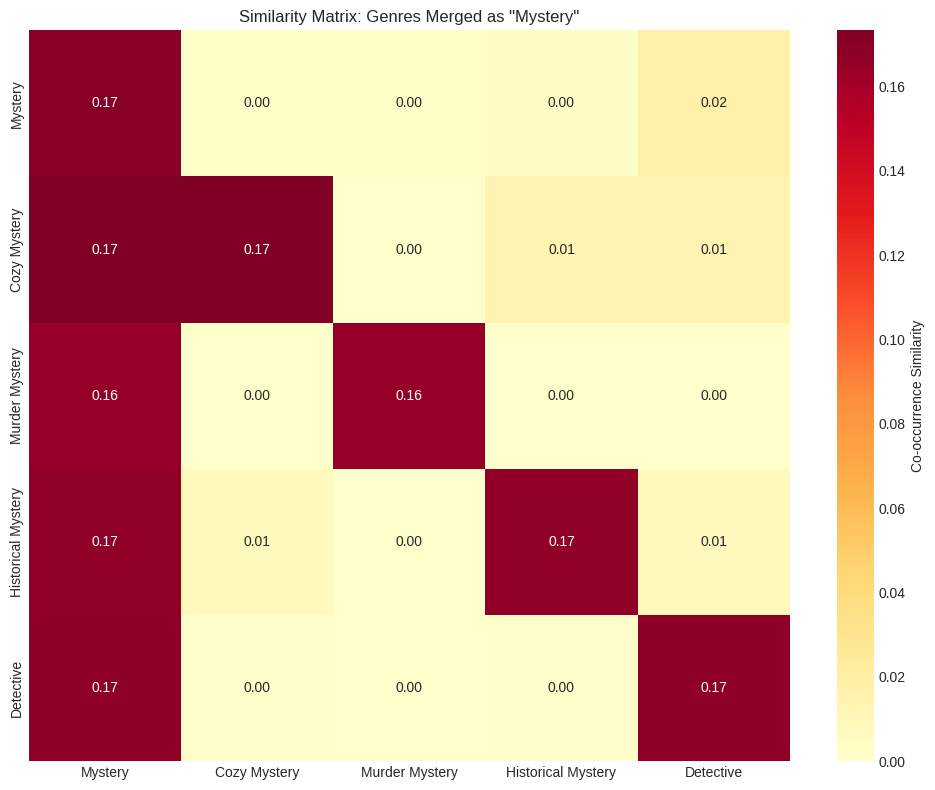

In [32]:
# Checking if our merging decisions are supported by genre similarity analysis
def calculate_genre_similarity(df, genre_column='genres_list'):
    """Calculate pairwise similarity between genres based on co-occurrence."""
    all_genres = []
    for genres in df[genre_column]:
        if isinstance(genres, list):
            all_genres.extend(genres)

    unique_genres = sorted(list(set(all_genres)))
    genre_to_idx = {g: i for i, g in enumerate(unique_genres)}

    n_genres = len(unique_genres)
    cooccurrence_matrix = np.zeros((n_genres, n_genres))

    for genres in df[genre_column]:
        if isinstance(genres, list):
            for g1 in genres:
                for g2 in genres:
                    if g1 in genre_to_idx and g2 in genre_to_idx:
                        cooccurrence_matrix[genre_to_idx[g1], genre_to_idx[g2]] += 1

    # Normalize
    row_sums = cooccurrence_matrix.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    similarity_matrix = cooccurrence_matrix / row_sums

    return pd.DataFrame(similarity_matrix, index=unique_genres, columns=unique_genres)

# Calculate genre similarity
similarity_df = calculate_genre_similarity(df_clean, 'genres_list')

# Analyzing decision for specific_genre_mapping
merge_groups = {}
for original, merged in specific_genre_mapping.items():
    if merged not in merge_groups:
        merge_groups[merged] = []
    merge_groups[merged].append(original)

# Find problematic merges (low similarity between merged genres)
problematic_merges = []

for merged_genre, original_genres in merge_groups.items():
    if len(original_genres) > 1:
        similarities = []
        for i, g1 in enumerate(original_genres):
            for g2 in original_genres[i+1:]:
                if g1 in similarity_df.index and g2 in similarity_df.columns:
                    sim = similarity_df.loc[g1, g2]
                    similarities.append((g1, g2, sim))

        if similarities:
            avg_sim = np.mean([s[2] for s in similarities])
            if avg_sim < 0.3:  #setting < 0.3 as low similarity
                problematic_merges.append({
                    'merged_genre': merged_genre,
                    'original_genres': original_genres,
                    'avg_similarity': avg_sim,
                    'pairs': similarities
                })

if problematic_merges:
    print(f"FOUND {len(problematic_merges)} POTENTIALLY PROBLEMATIC MERGES:")
    print("-" * 100)
    for merge in sorted(problematic_merges, key=lambda x: x['avg_similarity']):
        print(f"\nMerged as '{merge['merged_genre']}':")
        print(f"  Original genres: {', '.join(merge['original_genres'])}")
        print(f"  Average similarity: {merge['avg_similarity']:.3f}")
        print(f"These genres may be too different to merge!")
else:
    print("\n No obviously problematic merges detected")


# Visualize top problematic merge
if problematic_merges:
    merge = problematic_merges[0]
    valid_genres = [g for g in merge['original_genres'] if g in similarity_df.index]
    if len(valid_genres) > 1:
        subset_sim = similarity_df.loc[valid_genres, valid_genres]

        plt.figure(figsize=(10, 8))
        sns.heatmap(subset_sim, annot=True, fmt='.2f', cmap='YlOrRd',
                   cbar_kws={'label': 'Co-occurrence Similarity'})
        plt.title(f'Similarity Matrix: Genres Merged as "{merge["merged_genre"]}"')
        plt.tight_layout()
        plt.show()


In [33]:
def merge_genres(genre_list, mapping):
    """
    Map specific genres to broader categories.
    """
    merged = set()  # Use set to avoid duplicates

    for genre in genre_list:
        if genre in mapping:
            merged.add(mapping[genre])
        else:
            # Keep genres not in mapping as-is (or you can skip them)
            merged.add(genre)

    return list(merged)

In [34]:
# First, filter out non-content genres (from previous step)
df_clean['filtered_genres'] = df_clean['genres_list'].apply(
    lambda x: filter_genres(x, non_content_genres)
)

# Then, merge similar genres
df_clean['merged_genres'] = df_clean['filtered_genres'].apply(
    lambda x: merge_genres(x, specific_genre_mapping)
)

# Check the results
print("Sample before and after merging:")
for i in range(5):
    print(f"\nBook {i}:")
    print(f"  Original: {df_clean['genres_list'].iloc[i]}")
    print(f"  Filtered: {df_clean['filtered_genres'].iloc[i]}")
    print(f"  Merged:   {df_clean['merged_genres'].iloc[i]}")

Sample before and after merging:

Book 0:
  Original: ['Classics', 'Historical Fiction', 'School', 'Literature', 'Young Adult', 'Historical']
  Filtered: ['Classics', 'Historical Fiction', 'Young Adult', 'Historical']
  Merged:   ['Young Adult', 'Classics', 'Historical Fiction']

Book 1:
  Original: ['Fantasy', 'Young Adult', 'Magic', 'Childrens', 'Middle Grade', 'Classics']
  Filtered: ['Fantasy', 'Young Adult', 'Magic', 'Classics']
  Merged:   ['Fantasy', 'Young Adult', 'Classics']

Book 2:
  Original: ['Classics', 'Romance', 'Historical Fiction', 'Literature', 'Historical', 'Audiobook']
  Filtered: ['Classics', 'Romance', 'Historical Fiction', 'Historical']
  Merged:   ['Classics', 'Historical Fiction', 'Romance']

Book 3:
  Original: ['Classics', 'History', 'Biography', 'Memoir', 'Historical', 'Holocaust']
  Filtered: ['Classics', 'History', 'Biography', 'Memoir', 'Historical', 'Holocaust']
  Merged:   ['Classics', 'Historical Fiction', 'Memoir', 'History', 'Holocaust', 'Biography'

In [35]:
# Count merged genre frequencies
from collections import Counter
from itertools import chain

all_merged_genres = list(chain.from_iterable(df_clean['merged_genres']))
merged_genre_counts = Counter(all_merged_genres)

print(f"Number of unique genres after merging: {len(merged_genre_counts)}")
print(f"\nTop 30 merged genres:")
for genre, count in merged_genre_counts.most_common(30):
    print(f"  {genre}: {count}")

Number of unique genres after merging: 379

Top 30 merged genres:
  Fantasy: 2203
  Classics: 2123
  Historical Fiction: 1854
  Romance: 1606
  Young Adult: 1522
  Contemporary Fiction: 1366
  Mystery: 1357
  Thriller: 1180
  Science Fiction: 1026
  History: 832
  Self Help: 812
  Adventure: 756
  Psychology: 748
  Philosophy: 745
  Biography: 721
  Crime: 701
  Memoir: 672
  Humor: 567
  Paranormal: 543
  Horror: 505
  Business: 469
  Religion: 461
  War Fiction: 437
  Drama: 416
  Literary Fiction: 406
  Politics: 393
  Science: 359
  Dystopia: 352
  Spirituality: 352
  Poetry: 286


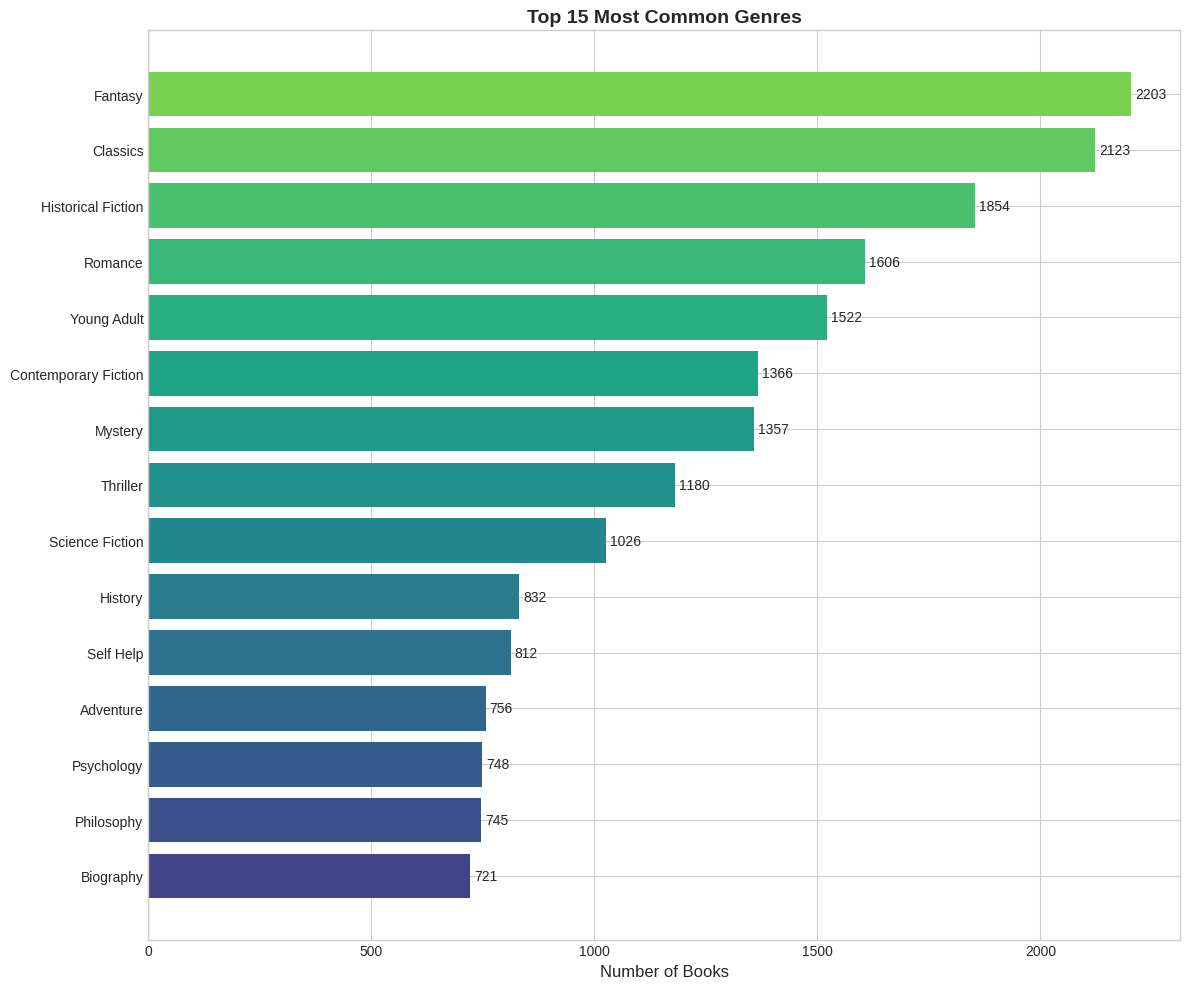

In [36]:
# Top 15 genres bar chart
top_n = 15
top_genres = merged_genre_counts.most_common(top_n)
genres_df = pd.DataFrame(top_genres, columns=['Genre', 'Count'])

fig, ax = plt.subplots(figsize=(12, 10))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, top_n))
bars = ax.barh(genres_df['Genre'][::-1], genres_df['Count'][::-1], color=colors)
ax.set_xlabel('Number of Books', fontsize=12)
ax.set_title(f'Top {top_n} Most Common Genres', fontsize=14, fontweight='bold')
ax.bar_label(bars, padding=3)
plt.tight_layout()
plt.savefig('eda_02.1_genre_frequency.png', dpi=150, bbox_inches='tight')
plt.show()

### 2.4 Genres Per Book Distribution

In [37]:
# Calculate genres per book
df_clean['genre_count'] = df_clean['merged_genres'].apply(len)

print("Genres per book statistics:")
print("-" * 30)
print(f"  Minimum: {df_clean['genre_count'].min()}")
print(f"  Maximum: {df_clean['genre_count'].max()}")
print(f"  Mean: {df_clean['genre_count'].mean():.2f}")
print(f"  Median: {df_clean['genre_count'].median():.0f}")
print(f"  Std Dev: {df_clean['genre_count'].std():.2f}")

Genres per book statistics:
------------------------------
  Minimum: 1
  Maximum: 7
  Mean: 3.83
  Median: 4
  Std Dev: 1.31


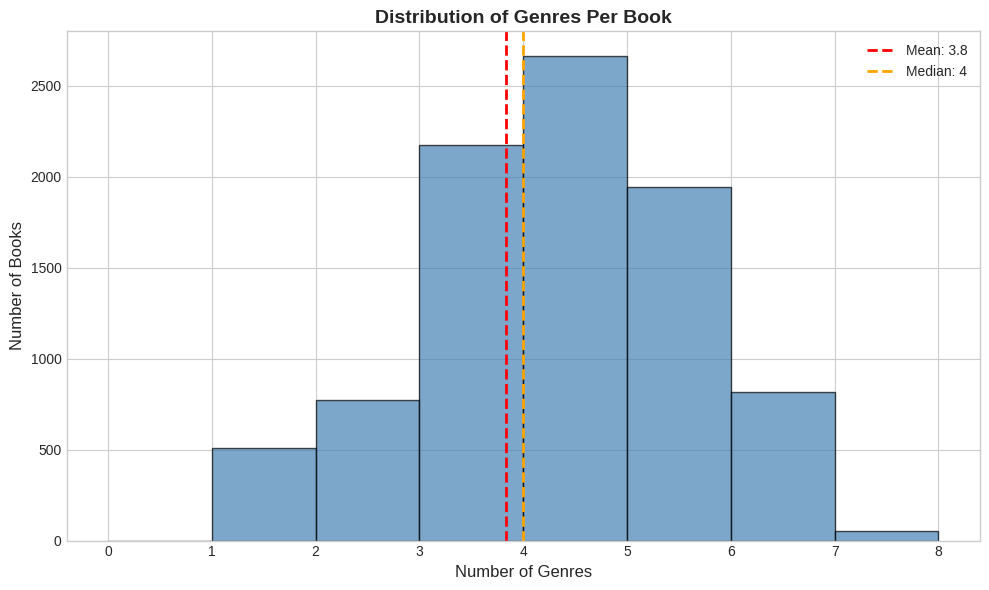

In [38]:
# Histogram of genres per book
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(df_clean['genre_count'],
        bins=range(0, df_clean['genre_count'].max() + 2),
        edgecolor='black', alpha=0.7, color='steelblue')

ax.axvline(df_clean['genre_count'].mean(), color='red', linestyle='--',
           linewidth=2, label=f'Mean: {df_clean["genre_count"].mean():.1f}')
ax.axvline(df_clean['genre_count'].median(), color='orange', linestyle='--',
           linewidth=2, label=f'Median: {df_clean["genre_count"].median():.0f}')

ax.set_xlabel('Number of Genres', fontsize=12)
ax.set_ylabel('Number of Books', fontsize=12)
ax.set_title('Distribution of Genres Per Book', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.savefig('eda_03_genres_per_book.png', dpi=150, bbox_inches='tight')
plt.show()

### 2.5 Genre Co-occurrence Matrix

In [39]:
# Use MultiLabelBinarizer for top genres only (for readability)
top_n_cooc = 50  #focus on 50 genres only
top_genre_names = [g[0] for g in genre_counts.most_common(top_n_cooc)]

print(top_genre_names)

['Fantasy', 'Classics', 'Romance', 'Young Adult', 'Historical Fiction', 'Mystery', 'Contemporary', 'Audiobook', 'Novels', 'Literature', 'Thriller', 'Historical', 'Science Fiction', 'History', 'Adventure', 'Philosophy', 'Biography', 'Self Help', 'Crime', 'Psychology', 'Adult', 'Mystery Thriller', 'Childrens', 'Memoir', 'Humor', 'Suspense', 'Horror', 'Paranormal', 'Science Fiction Fantasy', 'Personal Development', 'Religion', 'Middle Grade', 'Drama', 'Literary Fiction', 'Business', 'Politics', 'Short Stories', 'Science', 'Spirituality', 'War', 'Magic', 'Dystopia', 'Poetry', 'American', 'Christian', 'British Literature', 'School', 'Adult Fiction', 'Autobiography', 'Biography Memoir']


In [40]:
# Filter genres to only include top genres
def filter_top_genres(genre_list):
    return [g for g in genre_list if g in top_genre_names]

df_clean['top_genres'] = df_clean['merged_genres'].apply(filter_top_genres)

# Binarize
mlb = MultiLabelBinarizer(classes=top_genre_names)
genre_matrix = mlb.fit_transform(df_clean['top_genres'])
genre_binary_df = pd.DataFrame(genre_matrix, columns=mlb.classes_)

print(f"Binary genre matrix shape: {genre_binary_df.shape}")

Binary genre matrix shape: (8927, 50)


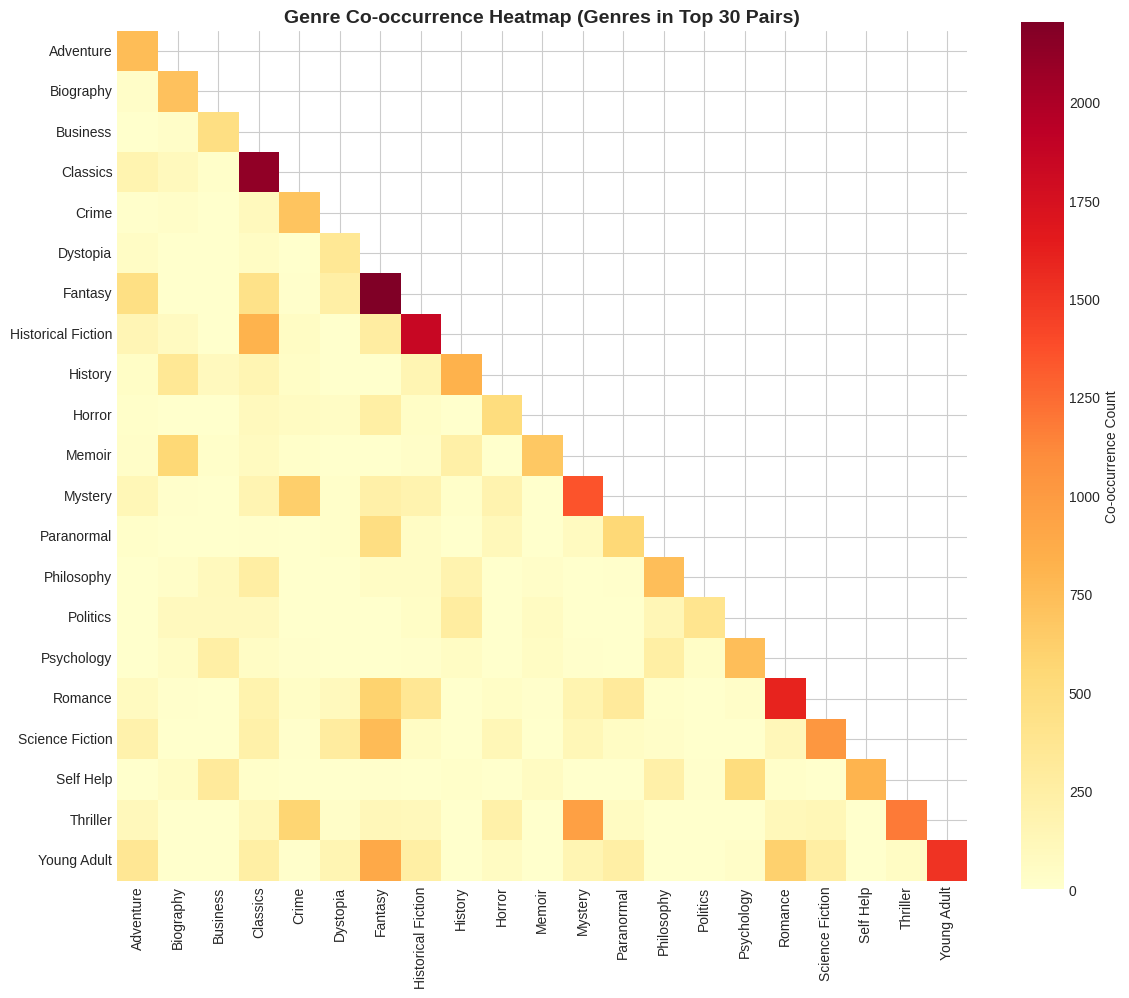

In [41]:
# Calculate co-occurrence for only top 30 genres
cooccurrence = genre_binary_df.T.dot(genre_binary_df)

# Upper triangle list of pairs
upper = cooccurrence.where(np.triu(np.ones(cooccurrence.shape), k=1).astype(bool))

pairs = (
    upper.stack()
    .rename("count")
    .reset_index()
    .rename(columns={"level_0": "genre_a", "level_1": "genre_b"})
    .sort_values("count", ascending=False)
)

topN = 30
top_pairs = pairs.head(topN)

# Genres involved in the top pairs
selected_genres = sorted(set(top_pairs["genre_a"]).union(set(top_pairs["genre_b"])))

# Subset matrix
coocc_small = cooccurrence.loc[selected_genres, selected_genres]

# Heatmap
mask = np.triu(np.ones_like(coocc_small, dtype=bool), k=1)

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    coocc_small,
    mask=mask,
    cmap="YlOrRd",
    annot=False,
    square=True,
    ax=ax,
    cbar_kws={"label": "Co-occurrence Count"}
)

ax.set_title(f"Genre Co-occurrence Heatmap (Genres in Top {topN} Pairs)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("eda_04_genre_cooccurrence_top_pairs_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()


In [42]:
# Most frequently co-occurring genre pairs
print("Most frequently co-occurring genre pairs:")
print("-" * 50)

for _, row in top_pairs.head(10).iterrows():
    g1 = row["genre_a"]
    g2 = row["genre_b"]
    count = int(row["count"])
    print(f"  {g1} & {g2}: {count:,} books")

Most frequently co-occurring genre pairs:
--------------------------------------------------
  Mystery & Thriller: 958 books
  Fantasy & Young Adult: 890 books
  Classics & Historical Fiction: 821 books
  Fantasy & Science Fiction: 762 books
  Mystery & Crime: 628 books
  Romance & Young Adult: 608 books
  Fantasy & Romance: 598 books
  Thriller & Crime: 575 books
  Biography & Memoir: 554 books
  Self Help & Psychology: 500 books


---

<a id='step3'></a>
## Step 3: Description Analysis (Input Text)

#### In this section we take a closer look at our feature: Description. The following checks and anaysis are performed:


*   Removing missign descriptions
*   Calculating text length and removing all descriptions with less than 20 words
*   Checking top 10 genres with shortest descriptions vs top 10 genres with longest descriptions
*   Cleaning text by: lowercasing, removing stopwords, tokenizing and lemmatizing.
*   Checking top 15 most occuring words over all descriptions
*   Checking top 10 words used in the top 6 genres based on TF-IDF scores



### 3.1 Handle Missing Descriptions

In [43]:
# Check missing descriptions
missing_desc = df_clean['Description'].isnull().sum()
empty_desc = (df_clean['Description'].str.strip() == '').sum() if missing_desc < len(df_clean) else 0

print(f"Missing descriptions (null): {missing_desc}")
print(f"Empty descriptions (blank): {empty_desc}")

Missing descriptions (null): 35
Empty descriptions (blank): 0


In [44]:
# Remove rows with missing descriptions for text analysis
df_text = df_clean[df_clean['Description'].notna()].copy()
print(f"Books with valid descriptions: {len(df_text):,}")

Books with valid descriptions: 8,892


### 3.2 Calculate Text Lengths

In [45]:
# Word count
df_text['word_count'] = df_text['Description'].str.split().str.len()

In [46]:
print("Word Count Statistics:")
print("-" * 30)
print(f"  Min: {df_text['word_count'].min()}")
print(f"  Max: {df_text['word_count'].max()}")
print(f"  Mean: {df_text['word_count'].mean():.1f}")
print(f"  Median: {df_text['word_count'].median():.0f}")
print(f"  Std Dev: {df_text['word_count'].std():.1f}")

Word Count Statistics:
------------------------------
  Min: 1
  Max: 1541
  Mean: 157.8
  Median: 143
  Std Dev: 91.8


In [47]:
# Identify outliers
q1 = df_text['word_count'].quantile(0.25)
q3 = df_text['word_count'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr

short_desc = (df_text['word_count'] < 20).sum()
long_desc = (df_text['word_count'] > upper_bound).sum()

print("Outlier Analysis:")
print("-" * 30)
print(f"  Very short descriptions (<20 words): {short_desc}")
print(f"  Very long descriptions (>{upper_bound:.0f} words): {long_desc}")

Outlier Analysis:
------------------------------
  Very short descriptions (<20 words): 93
  Very long descriptions (>344 words): 304


In [48]:
# Some samples of outlier descriptions
print("Sample Short Descriptions (Description length < 20 words)")
for i, row in df_text[df_text['word_count'] < 20][['Book', 'Description', 'word_count']].head(5).iterrows():
    print(f"\nBook: {row['Book']}")
    print(f"Word Count: {row['word_count']}")
    print(f"Description: {row['Description']}")

print("Sample Long Descriptions (Description length > upper_bound)")
for i, row in df_text[df_text['word_count'] > upper_bound][['Book', 'Description', 'word_count']].head(3).iterrows():
    print(f"\nBook: {row['Book']}")
    print(f"Word Count: {row['word_count']}")
    print(f"Description: {row['Description']}")

Sample Short Descriptions (Description length < 20 words)

Book: The Black Stallion (The Black Stallion, #1)
Word Count: 6
Description: First in the Black Stallion series.

Book: Kerri's War (The King Trilogy, #3)
Word Count: 7
Description: Librarian Note: Alternate Cover Edition for ASIN:B00DEKRUQ0.

Book: Rights of Man
Word Count: 10
Description: This book is in English. This book contains 229 pages.

Book: Red Gone Bad
Word Count: 7
Description: A small collection of twisted fairy tales

Book: The Seventh Spark: Volume One – Knights of the Trinity
Word Count: 4
Description: fantasy graphic fiction novel
Sample Long Descriptions (Description length > upper_bound)

Book: The Adventures of Tom Sawyer
Word Count: 429
Description: The Adventures of Tom Sawyer revolves around the youthful adventures of the novel's schoolboy protagonist, Thomas Sawyer, whose reputation precedes him for causing mischief and strife. Tom lives with his Aunt Polly, half-brother Sid, and cousin Mary in the quai

In [49]:
# Remove the very short descriptions
df_text = df_text[df_text['word_count'] >= 20]
print(f"Books with valid descriptions: {len(df_text):,}")

Books with valid descriptions: 8,799


In [50]:
# Analyse top 10 genres with shortest description vs top 10 genres with longest description

# Making sure it's list-like and exploding to one row per (book, genre)
df_genre_desc = df_text[['merged_genres', 'word_count']].dropna().copy()
df_genre_desc = df_genre_desc.explode('merged_genres').rename(columns={'merged_genres': 'genre'})
df_genre_desc = df_genre_desc.dropna(subset=['genre'])


# Aggregate word counts per genre
genre_word_stats = (
    df_genre_desc
    .groupby('genre')
    .agg(
        n_books=('word_count', 'size'),
        max_words=('word_count', 'max')
    )
)


print("Top 10 genres with the SHORTEST maximum descriptions")
print("-" * 60)
print(genre_word_stats.sort_values('max_words', ascending=True).head(10))

print("\nTop 10 genres with the LONGEST maximum descriptions")
print("-" * 60)
print(genre_word_stats.sort_values('max_words', ascending=False).head(10))

Top 10 genres with the SHORTEST maximum descriptions
------------------------------------------------------------
                      n_books  max_words
genre                                   
Biblical Fiction            1         40
Dying Earth                 1         41
Star Trek                   1         43
School Stories              2         43
Adhd                        1         47
Princesses                  1         48
Liberia                     1         52
Sierra Leone                1         52
Dungeons and Dragons        1         57
Botswana                    1         60

Top 10 genres with the LONGEST maximum descriptions
------------------------------------------------------------
              n_books  max_words
genre                           
Religion          451       1541
Biography         717       1541
History           817       1541
Spirituality      343       1096
Philosophy        727       1096
Music              73       1096
Poetry          

### 3.3 Text Cleaning

In [51]:
# Helper function for POS-aware lemmatization
def get_wordnet_pos(treebank_tag):
    """Convert Penn Treebank POS tags to WordNet POS tags."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Contraction expansion
def expand_contractions(text):
    """Expand English contractions to full forms"""
    contractions_dict = {
        "don't": "do not", "doesn't": "does not", "didn't": "did not",
        "won't": "will not", "wouldn't": "would not", "can't": "cannot",
        "couldn't": "could not", "shouldn't": "should not", "isn't": "is not",
        "aren't": "are not", "wasn't": "was not", "weren't": "were not",
        "hasn't": "has not", "haven't": "have not", "hadn't": "had not",
        "i'm": "i am", "you're": "you are", "he's": "he is", "she's": "she is",
        "it's": "it is", "we're": "we are", "they're": "they are",
        "i've": "i have", "you've": "you have", "we've": "we have",
        "they've": "they have", "i'd": "i would", "you'd": "you would",
        "we'd": "we would", "they'd": "they would", "i'll": "i will",
        "you'll": "you will", "we'll": "we will", "they'll": "they will",
        "there's": "there is", "that's": "that is", "what's": "what is"
    }

    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),
                                     flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        expanded = contractions_dict.get(match.lower())
        return expanded if expanded else match

    return contractions_pattern.sub(expand_match, text)


# Main preprocessing function
def preprocess_text(text, lemmatize=True, handle_numbers='replace'):
    """
    text preprocessing with:

    - Expands contractions (don't -> do not)
    - POS-aware lemmatization
    - Proper handling of proper nouns
    - remove punctuations, html tags, URLs
    - remove stopwords
    """
    if not isinstance(text, str):
        return ""

    # 1. Expand contractions
    text = expand_contractions(text)

    # 2. Lowercase
    text = text.lower()

    # 3. Remove punctuation (keep special tokens)
    text = re.sub(r'[^\w\s<>]', ' ', text)

    # 4. Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # 5. Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # 6. Tokenize
    tokens = word_tokenize(text)

    # 7. POS-aware lemmatization
    if lemmatize:
        pos_tags = pos_tag(tokens)
        tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos))
                 for word, pos in pos_tags]

    # 8. Remove stopwords (keep special tokens)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens
             if word not in stop_words or word.startswith('<')]

    return ' '.join(tokens)

In [52]:
# Apply preprocessing to entire dataset
df_text['cleaned_description'] = df_text['Description'].apply(
    lambda x: preprocess_text(x, lemmatize=True, handle_numbers='replace')
)

# Show example
print("Sample cleaned description:")
print("-" * 50)
print(f"Original: {df_text['Description'].iloc[0][:200]}...")
print(f"\nCleaned: {df_text['cleaned_description'].iloc[0][:200]}...")

Sample cleaned description:
--------------------------------------------------
Original: The unforgettable novel of a childhood in a sleepy Southern town and the crisis of conscience that rocked it. "To Kill A Mockingbird" became both an instant bestseller and a critical success when it w...

Cleaned: unforgettable novel childhood sleepy southern town crisis conscience rock kill mockingbird become instant bestseller critical success first publish 1960 go win pulitzer prize 1961 later make academy a...


### 3.4 Tokenization and Stopword Removal

In [53]:
# Get English stopwords
stop_words = set(stopwords.words('english'))

# Add custom stopwords that we saw are being commonly used in the dataset
custom_stopwords = {
    'book', 'novel', 'story', 'author', 'one', 'first', 'new', 'life',
    'two', 'family', 'world'
}
stop_words.update(custom_stopwords)


print(f"Total stopwords: {len(stop_words)}")

Total stopwords: 209


In [54]:
def tokenize_and_remove_stopwords(text):
    """Tokenize text and remove stopwords."""
    if not text:
        return []
    tokens = text.split()  # Simple whitespace tokenization (text is already cleaned)
    #tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return tokens

df_text['tokens'] = df_text['cleaned_description'].apply(tokenize_and_remove_stopwords)

print(f"Sample tokens: {df_text['tokens'].iloc[0][:15]}...")

Sample tokens: ['unforgettable', 'novel', 'childhood', 'sleepy', 'southern', 'town', 'crisis', 'conscience', 'rock', 'kill', 'mockingbird', 'become', 'instant', 'bestseller', 'critical']...


In [55]:
def remove_stopwords_from_text(text):
    """Remove stopwords from a cleaned description."""
    if not text:
        return ""
    tokens = text.lower().split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return " ".join(tokens)

# Apply to cleaned_description
df_text['cleaned_description'] = (df_text['cleaned_description'].apply(remove_stopwords_from_text))

### 3.5 Overall Word Frequency

In [56]:
# Flatten all tokens
all_tokens = list(chain.from_iterable(df_text['tokens']))
token_counts = Counter(all_tokens)

print(f"Total unique words (after cleaning): {len(token_counts):,}")
print(f"Total word occurrences: {len(all_tokens):,}")

Total unique words (after cleaning): 57,100
Total word occurrences: 811,915


In [57]:
# Top 30 most frequent words
print("Top 30 Most Frequent Words:")
print("-" * 30)
for i, (word, count) in enumerate(token_counts.most_common(30), 1):
    print(f"  {i:2}. {word}: {count:,}")

Top 30 Most Frequent Words:
------------------------------
   1. life: 6,693
   2. one: 5,622
   3. world: 4,427
   4. story: 3,955
   5. book: 3,864
   6. new: 3,861
   7. year: 3,491
   8. love: 3,433
   9. time: 3,401
  10. find: 3,244
  11. make: 2,798
  12. know: 2,514
  13. first: 2,431
  14. work: 2,289
  15. take: 2,259
  16. family: 2,223
  17. novel: 2,089
  18. man: 2,070
  19. way: 2,034
  20. woman: 1,997
  21. come: 1,951
  22. people: 1,892
  23. two: 1,859
  24. become: 1,827
  25. old: 1,818
  26. young: 1,800
  27. go: 1,770
  28. u: 1,701
  29. war: 1,676
  30. live: 1,657


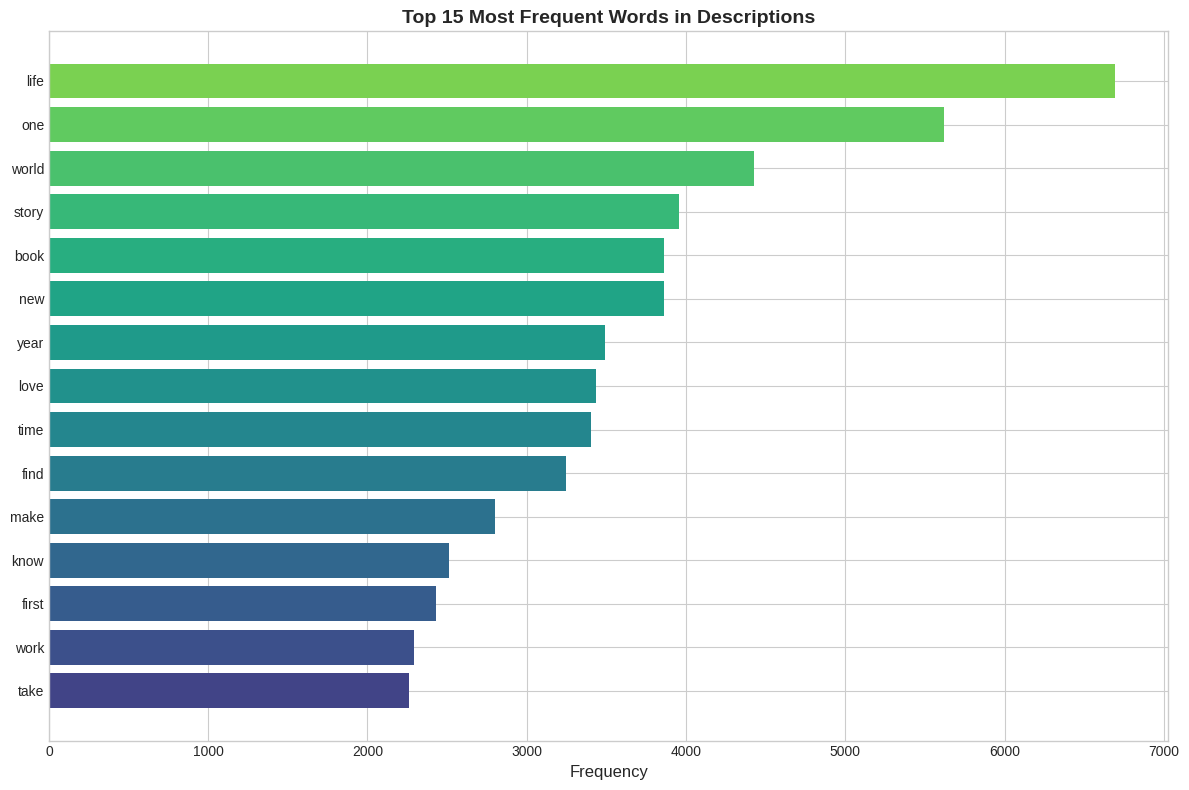

In [58]:
# Bar chart of top words
top_words = token_counts.most_common(15)
words_df = pd.DataFrame(top_words, columns=['Word', 'Count'])

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(words_df)))

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(
    words_df['Word'][::-1],
    words_df['Count'][::-1],
    color=colors
)
ax.set_xlabel('Frequency', fontsize=12)
ax.set_title('Top 15 Most Frequent Words in Descriptions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('eda_06_word_frequency.png', dpi=150, bbox_inches='tight')
plt.show()

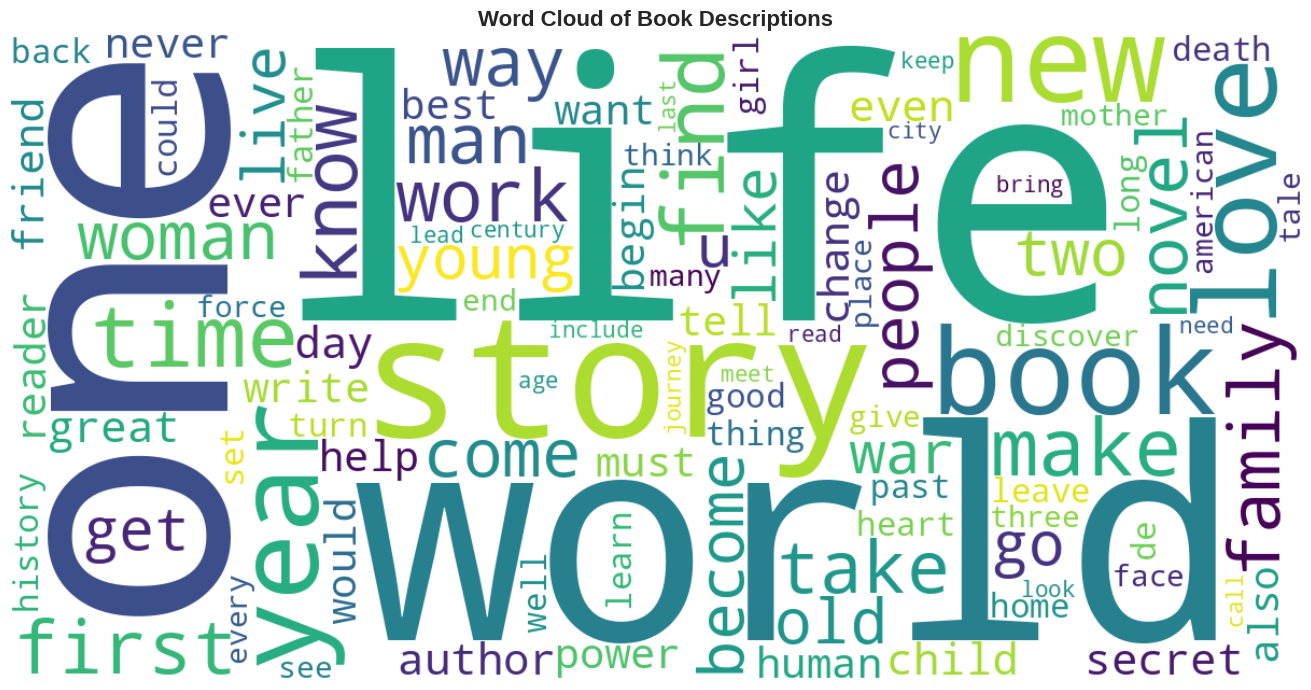

In [59]:
# Word cloud
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    max_words=100,
    colormap='viridis'
).generate_from_frequencies(token_counts)

fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
ax.set_title('Word Cloud of Book Descriptions', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('eda_07_wordcloud_overall.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.6 Genre-Specific Word Analysis

In [60]:
def get_genre_tokens(genre_name):
    """Get all tokens from books belonging to a specific genre."""
    genre_books = df_text[df_text['genres_list'].apply(lambda x: genre_name in x)]
    genre_tokens = list(chain.from_iterable(genre_books['tokens']))
    return Counter(genre_tokens)

# Analyse top 6 genres
top_genres_to_analyse = [g[0] for g in genre_counts.most_common(6)]
print(f"Analysing top words for: {top_genres_to_analyse}")

Analysing top words for: ['Fantasy', 'Classics', 'Romance', 'Young Adult', 'Historical Fiction', 'Mystery']


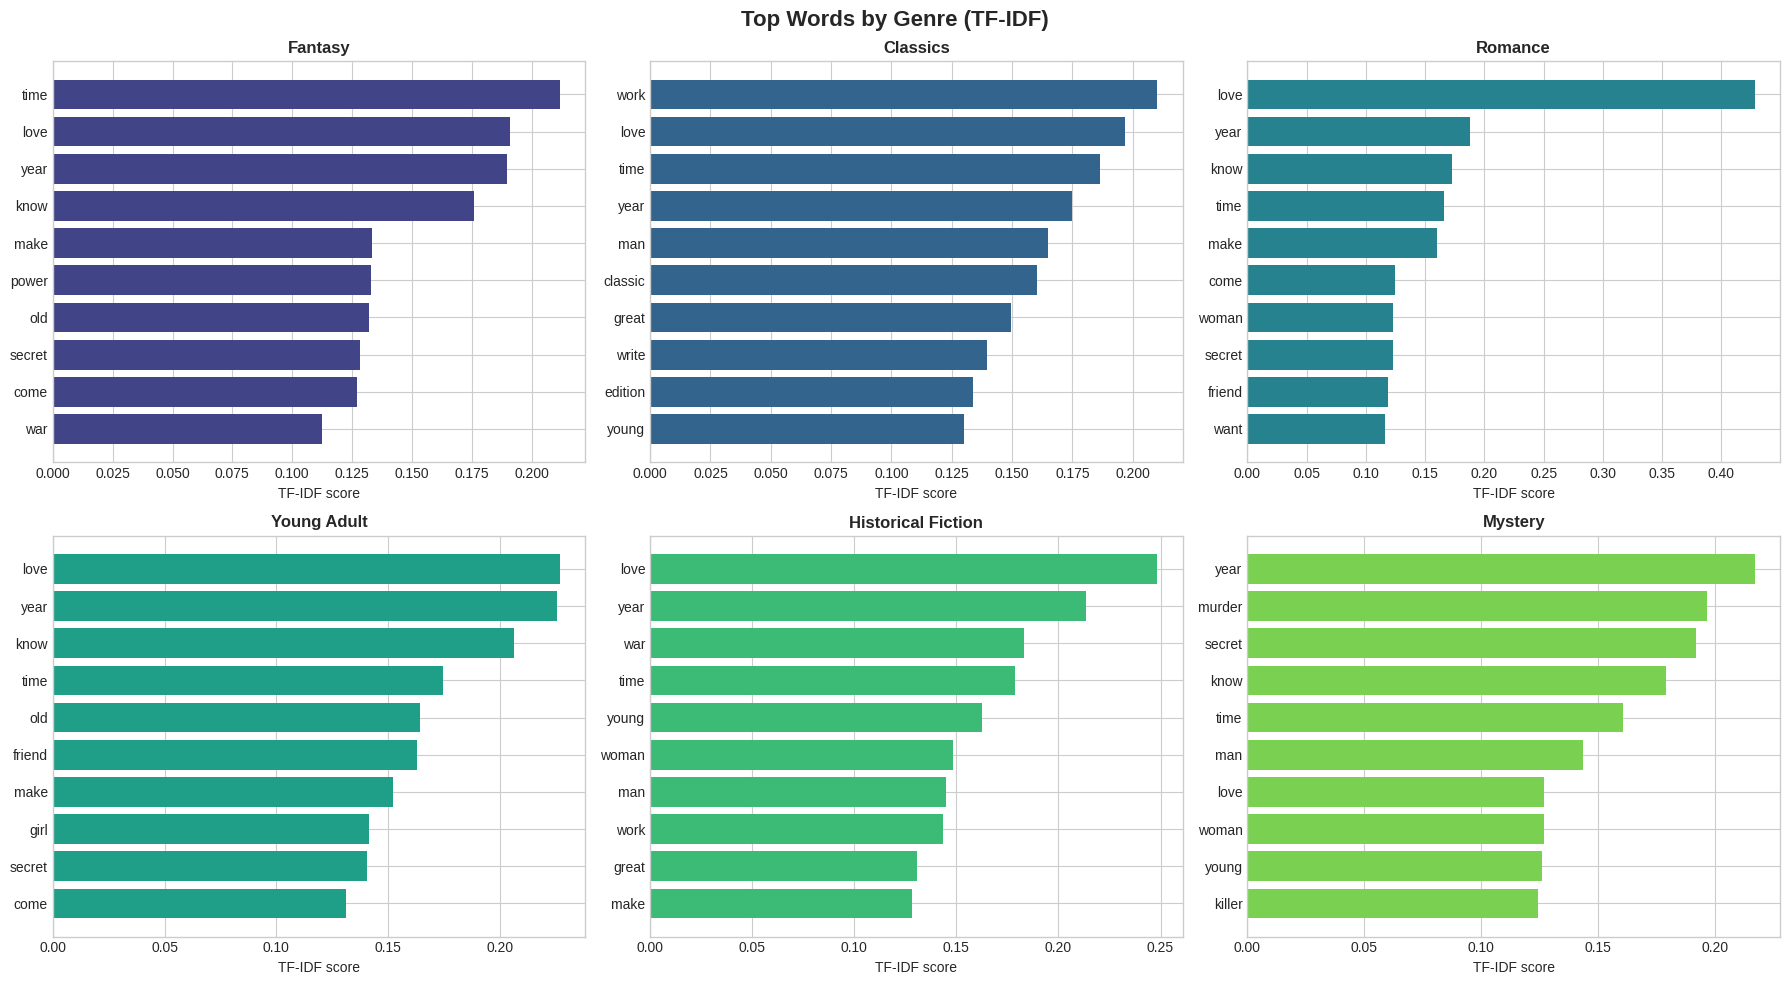

In [61]:
#plot most popular words on top 6 genres by TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt

#color schema for plots
viridis_colors = plt.cm.viridis(np.linspace(0.2, 0.8, 6))

genre_colors = {
    top_genres_to_analyse[0]: viridis_colors[0],
    top_genres_to_analyse[1]: viridis_colors[1],
    top_genres_to_analyse[2]: viridis_colors[2],
    top_genres_to_analyse[3]: viridis_colors[3],
    top_genres_to_analyse[4]: viridis_colors[4],
    top_genres_to_analyse[5]: viridis_colors[5],
}


# Build one document per genre
genre_docs = {}

for genre in top_genres_to_analyse:
    texts = df_text[df_text['merged_genres'].apply(lambda gs: genre in gs)]['cleaned_description']
    genre_docs[genre] = " ".join(texts.tolist())

#create a TF-IDF computation
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=5
)

tfidf = vectorizer.fit_transform(genre_docs.values())
feature_names = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(
    tfidf.toarray(),
    index=genre_docs.keys(),
    columns=feature_names
)

#plot top used words per genre
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

top_k = 10

for ax, genre in zip(axes, tfidf_df.index):
    top_terms = (
        tfidf_df.loc[genre]
        .sort_values(ascending=False)
        .head(top_k)
        .iloc[::-1]
    )

    ax.barh(
    top_terms.index,
    top_terms.values,
    color=genre_colors.get(genre, "#4C4C4C"))
    ax.set_title(genre, fontweight='bold')
    ax.set_xlabel("TF-IDF score")

plt.suptitle("Top Words by Genre (TF-IDF)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("eda_tfidf_terms_by_genre.png", dpi=150, bbox_inches="tight")
plt.show()

# Modelling

## Model 1: TF-IDF - Grid Search

In [107]:
df= df_text.copy()

# Count genre frequencies
all_genres = list(chain.from_iterable(df['merged_genres']))
genre_counts = Counter(all_genres)
print(f"Total unique genres: {len(genre_counts)}")

print("Top 30 genres:")
for genre, count in genre_counts.most_common(30):
    print(f"  {genre}: {count}")

# Keep only genres with enough samples
MIN_SAMPLES = 100  # Adjustable

valid_genres = [g for g, count in genre_counts.items() if count >= MIN_SAMPLES]
print(f"\nGenres with >= {MIN_SAMPLES} samples: {len(valid_genres)}")

# Filter to only include valid genres
df['final_genres'] = df['merged_genres'].apply(
    lambda x: [g for g in x if g in valid_genres]
)
final_genres = list(chain.from_iterable(df['final_genres']))
final_genres_count = Counter(final_genres)
print(f"Total unique genres to be used in the model: {len(final_genres_count)}")

# Create df_model: only books with at least one valid genre
df_model = df[df['final_genres'].apply(len) > 0].copy()

print(f"\nBooks in df_model: {len(df_model)}")
print(f"Columns: {df_model.columns.tolist()}")

Total unique genres: 378
Top 30 genres:
  Fantasy: 2186
  Classics: 2095
  Historical Fiction: 1832
  Romance: 1589
  Young Adult: 1513
  Mystery: 1350
  Contemporary Fiction: 1341
  Thriller: 1168
  Science Fiction: 1017
  History: 817
  Self Help: 799
  Adventure: 746
  Psychology: 741
  Philosophy: 727
  Biography: 717
  Crime: 699
  Memoir: 668
  Humor: 562
  Paranormal: 542
  Horror: 499
  Business: 457
  Religion: 451
  War Fiction: 435
  Drama: 403
  Literary Fiction: 402
  Politics: 385
  Science: 354
  Dystopia: 350
  Spirituality: 343
  Poetry: 280

Genres with >= 100 samples: 53
Total unique genres to be used in the model: 53

Books in df_model: 8732
Columns: ['Book', 'Author', 'Description', 'Genres', 'Avg_Rating', 'Num_Ratings', 'URL', 'genres_list', 'filtered_genres', 'merged_genres', 'genre_count', 'top_genres', 'word_count', 'cleaned_description', 'tokens', 'final_genres']


In [108]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    f1_score, hamming_loss, accuracy_score,
    classification_report, make_scorer
)
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from collections import Counter
from itertools import chain

# Get texts and encode labels
# FIX: Join the tokens back into a single string for each document
texts = df_model['tokens'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '').fillna('').tolist()

# Fit MultiLabelBinarizer
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df_model['final_genres'])

X_text_unified = texts # 'texts' is a list of cleaned and tokenized descriptions from df_model['Description']
y_encoded_unified = labels # 'labels' is the binarized genre array from df_model['final_genres']

print(f"Dataset size: {len(X_text_unified)}")
print(f"Number of genres: {len(mlb.classes_)}") # Use the mlb from the transformer setup
print(f"Average genres per book: {y_encoded_unified.sum(axis=1).mean():.2f}")

# SPLIT DATA FIRST (BEFORE TF-IDF) using the same random_state as the unified split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text_unified, y_encoded_unified, test_size=0.2, random_state=42, stratify=None
)

# Instantiate TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Transform X_train_text and X_test_text
X_train = tfidf_vectorizer.fit_transform(X_train_text)
X_test = tfidf_vectorizer.transform(X_test_text)

print(f"\nTraining samples: {len(X_train_text)}")
print(f"Test samples: {len(X_test_text)}")
print(f"TF-IDF vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

Dataset size: 8732
Number of genres: 53
Average genres per book: 3.35

Training samples: 6985
Test samples: 1747
TF-IDF vocabulary size: 5000


In [64]:
print(X_train_text[:5])

['america old haunted city st augustine florida teenager jeff golden trouble horrible dream win let sleep eyeball terrify paranormal experience finally jeff turn girlfriend carla lobo mysterious native american shaman help discover lot bargain ghostly presence link local historic cemetery threaten jeff sanity life well know happen jeff find carla pull one nasty bloody event florida history place may never escape', 'hoy día ya nadie cree en los ángeles sin embargo hay gente que sí cree en los demonios pero los ángeles existen han existido siempre qué cómo lo sé porque mi padre era uno de ellos el problema e que cuando los ángeles te dan la espalda en quién puedes confiar', 'hope live alternative trenton new jersey 1980s radioactive cat congenital tattoos biker angel cocky fairy godmother determination survive another day stand family creep chemical force lobochem manufacturer willing destroy beautiful sake profit magic america story come age fluorescent urbo suburban magic realism ameri

In [109]:
# ANALYZE GENRE DISTRIBUTION IN TRAINING SET

genre_frequencies = y_train.mean(axis=0)
genre_df = pd.DataFrame({
    'Genre': mlb.classes_,
    'Frequency': genre_frequencies,
    'Percentage': genre_frequencies * 100
}).sort_values('Percentage', ascending=False)

print("\nTop 15 Most Common Genres in Training Set:")
print(genre_df.head(15).to_string(index=False))

# Check for problematic genres
problematic = genre_df[genre_df['Percentage'] > 95]
if len(problematic) > 0:
    print(f"\nWARNING: {len(problematic)} genres appear in >95% of samples:")
    print(problematic.to_string(index=False))



Top 15 Most Common Genres in Training Set:
               Genre  Frequency  Percentage
             Fantasy   0.253114   25.311382
            Classics   0.241231   24.123121
  Historical Fiction   0.211883   21.188261
             Romance   0.182820   18.282033
         Young Adult   0.173228   17.322835
Contemporary Fiction   0.157337   15.733715
             Mystery   0.153758   15.375805
            Thriller   0.131424   13.142448
     Science Fiction   0.119112   11.911238
             History   0.091911    9.191124
           Self Help   0.089334    8.933429
          Psychology   0.083465    8.346457
          Philosophy   0.082606    8.260558
           Adventure   0.081603    8.160344
               Crime   0.079742    7.974230


In [ ]:
# DEFINE PIPELINE WITH CLASS IMBALANCE HANDLING

# The pipeline includes TfidfVectorizer so it expects RAW TEXT as input
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(
        RandomForestClassifier(
            random_state=RANDOM_SEED,
            class_weight='balanced',  # Handles class imbalance automatically
            n_jobs=-1
        )
    ))
])

# DEFINE PARAMETER GRID

param_grid_tfidf = {
    'tfidf__max_features': [5000, 10000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__estimator__n_estimators': [100, 200],
    'clf__estimator__max_depth': [20, None],
}

# Choose which grid to use (start with reduced for testing)
param_grid = param_grid_tfidf


# CREATE AND RUN GRID SEARCH

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1_micro',  # Good for multi-label; alternatives: 'f1_macro', 'f1_weighted'
    cv=3,                # 3-fold CV (use 5 for more robust but slower)
    n_jobs=-1,           # Use all CPU cores
    verbose=2,           # Show progress
    return_train_score=True,  # Useful for diagnosing overfitting
    refit=True           # Refit best model on full training set
)

# Fit GridSearchCV - NOTE: Pass RAW TEXT, not TF-IDF transformed data!
print("\nFitting grid search...")
grid_search.fit(X_train_text, y_train)


# EXAMINE RESULTS

print("\n--- BEST PARAMETERS ---")
print(grid_search.best_params_)

print(f"\n--- BEST CROSS-VALIDATION SCORE ---")
print(f"Best CV Micro F1: {grid_search.best_score_:.4f}")

# Get the best estimator (already refitted on full training data)
best_model = grid_search.best_estimator_

# View all results as DataFrame (optional)
cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_results_df = cv_results_df.sort_values('rank_test_score')

print("\n--- TOP 5 PARAMETER COMBINATIONS ---")
cols_to_show = ['rank_test_score', 'mean_test_score', 'std_test_score', 'mean_train_score']
print(cv_results_df[cols_to_show].head(5).to_string(index=False))


Fitting grid search...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

--- BEST PARAMETERS ---
{'clf__estimator__max_depth': 20, 'clf__estimator__n_estimators': 100, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}

--- BEST CROSS-VALIDATION SCORE ---
Best CV Micro F1: 0.4190

--- TOP 5 PARAMETER COMBINATIONS ---
 rank_test_score  mean_test_score  std_test_score  mean_train_score
               1         0.419044        0.007617          0.931150
               2         0.417123        0.003910          0.940980
               3         0.414723        0.005543          0.936149
               4         0.414170        0.004773          0.936689
               5         0.413369        0.005300          0.941608


In [ ]:
# EVALUATE BEST MODEL ON TEST SET

# Make predictions using best model
y_pred = best_model.predict(X_test_text)

# Calculate metrics
micro_f1 = f1_score(y_test, y_pred, average='micro')
macro_f1 = f1_score(y_test, y_pred, average='macro')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
h_loss = hamming_loss(y_test, y_pred)
subset_acc = accuracy_score(y_test, y_pred)

print("\n--- TEST SET METRICS ---")
print(f"Micro F1:         {micro_f1:.4f}")
print(f"Macro F1:         {macro_f1:.4f}")
print(f"Weighted F1:      {weighted_f1:.4f}")
print(f"Hamming Loss:     {h_loss:.4f}")
print(f"Subset Accuracy:  {subset_acc:.4f}")



--- TEST SET METRICS ---
Micro F1:         0.4607
Macro F1:         0.2485
Weighted F1:      0.4214
Hamming Loss:     0.0522
Subset Accuracy:  0.0687


In [ ]:
# PREDICTION STATISTICS

avg_predicted = y_pred.sum(axis=1).mean()
avg_true = y_test.sum(axis=1).mean()

print("\n--- PREDICTION STATISTICS ---")
print(f"Average true genres per book:      {avg_true:.2f}")
print(f"Average predicted genres per book: {avg_predicted:.2f}")

# PER-GENRE PERFORMANCE (top and bottom performers)

# Get per-genre F1 scores
per_genre_f1 = f1_score(y_test, y_pred, average=None)
genre_performance = pd.DataFrame({
    'Genre': mlb.classes_,
    'F1_Score': per_genre_f1,
    'Support': y_test.sum(axis=0)
}).sort_values('F1_Score', ascending=False)

print("\n--- TOP 10 BEST PERFORMING GENRES ---")
print(genre_performance.head(10).to_string(index=False))

print("\n--- BOTTOM 10 WORST PERFORMING GENRES ---")
print(genre_performance.tail(10).to_string(index=False))


--- PREDICTION STATISTICS ---
Average true genres per book:      3.34
Average predicted genres per book: 1.79

--- TOP 10 BEST PERFORMING GENRES ---
             Genre  F1_Score  Support
           Fantasy  0.674214      418
           Mystery  0.647948      276
         Self Help  0.647273      175
       Young Adult  0.600000      303
             Crime  0.592275      142
          Classics  0.581340      410
          Thriller  0.569270      250
        Psychology  0.568000      158
           Romance  0.567219      312
Historical Fiction  0.523256      352

--- BOTTOM 10 WORST PERFORMING GENRES ---
             Genre  F1_Score  Support
            Africa       0.0       19
           Erotica       0.0       22
Paranormal Romance       0.0       32
    LGBTQ+ Fiction       0.0       38
  Literary Fiction       0.0       71
   Magical Realism       0.0       25
             India       0.0       20
         Sociology       0.0       24
            Travel       0.0       25
     Urba

In [ ]:
# COMPILE FINAL RESULTS
tfidf_results = {
    'best_params': grid_search.best_params_,
    'cv_micro_f1_mean': grid_search.best_score_,
    'test_micro_f1': micro_f1,
    'test_macro_f1': macro_f1,
    'test_weighted_f1': weighted_f1,
    'test_hamming_loss': h_loss,
    'test_subset_accuracy': subset_acc
}

print("FINAL SUMMARY FOR REPORTING")
print(f"\nBest Parameters: {tfidf_results['best_params']}")
print(f"\nCV Micro F1:        {tfidf_results['cv_micro_f1_mean']:.4f}")
print(f"Test Micro F1:      {tfidf_results['test_micro_f1']:.4f}")
print(f"Test Macro F1:      {tfidf_results['test_macro_f1']:.4f}")
print(f"Test Weighted F1:   {tfidf_results['test_weighted_f1']:.4f}")
print(f"Test Hamming Loss:  {tfidf_results['test_hamming_loss']:.4f}")
print(f"Test Subset Acc:    {tfidf_results['test_subset_accuracy']:.4f}")

FINAL SUMMARY FOR REPORTING

Best Parameters: {'clf__estimator__max_depth': 20, 'clf__estimator__n_estimators': 100, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}

CV Micro F1:        0.4190
Test Micro F1:      0.4607
Test Macro F1:      0.2485
Test Weighted F1:   0.4214
Test Hamming Loss:  0.0522
Test Subset Acc:    0.0687


## Model 1.1: Best Parameter KNN

In [94]:
# TF-IDF + Random Forest with Best Parameters (No Grid Search)


# Imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    f1_score, hamming_loss, accuracy_score,
    classification_report
)
import pandas as pd
import numpy as np

# Build Pipeline with Best Parameters

best_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 2)
    )),
    ('clf', OneVsRestClassifier(
        RandomForestClassifier(
            max_depth=20,
            n_estimators=200,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        )
    ))
])

# Train Model

print("Training model with best parameters...")
best_pipeline.fit(X_train_text, y_train)
print("Training complete!")

# Test Set Predictions

y_pred_tfidf = best_pipeline.predict(X_test_text)

# Evaluation Metrics

micro_f1_tfidf = f1_score(y_test, y_pred_tfidf, average='micro')
macro_f1_tfidf = f1_score(y_test, y_pred_tfidf, average='macro')
weighted_f1_tfidf = f1_score(y_test, y_pred_tfidf, average='weighted')
hamming_tfidf = hamming_loss(y_test, y_pred_tfidf)
subset_acc_tfidf = accuracy_score(y_test, y_pred_tfidf)

print("\n" + "="*50)
print("TEST SET EVALUATION")
print("="*50)
print(f"Micro F1:        {micro_f1_tfidf:.4f}")
print(f"Macro F1:        {macro_f1_tfidf:.4f}")
print(f"Weighted F1:     {weighted_f1_tfidf:.4f}")
print(f"Hamming Loss:    {hamming_tfidf:.4f}")
print(f"Subset Accuracy: {subset_acc_tfidf:.4f}")

# Prediction Statistics

avg_true = y_test.sum(axis=1).mean()
avg_predicted = y_pred_tfidf.sum(axis=1).mean()

print("\n" + "="*50)
print("PREDICTION STATISTICS")
print("="*50)
print(f"Average true genres per book:      {avg_true:.2f}")
print(f"Average predicted genres per book: {avg_predicted:.2f}")

# Per-Genre F1 Scores

per_genre_f1 = f1_score(y_test, y_pred_tfidf, average=None)
genre_f1_df = pd.DataFrame({
    'Genre': mlb.classes_,
    'F1': per_genre_f1,
    'Support': y_test.sum(axis=0)
}).sort_values('F1', ascending=False)

print("\n" + "="*50)
print("TOP 10 GENRES BY F1 SCORE")
print("="*50)
print(genre_f1_df.head(10).to_string(index=False))

print("\n" + "="*50)
print("BOTTOM 10 GENRES BY F1 SCORE")
print("="*50)
print(genre_f1_df.tail(10).to_string(index=False))

# Final Results Dictionary
tfidf_results = {
    'model': 'TF-IDF + RandomForest',
    'best_params': {
        'tfidf__max_features': 10000,
        'tfidf__ngram_range': (1, 2),
        'clf__estimator__max_depth': 20,
        'clf__estimator__n_estimators': 200
    },
    'test_micro_f1': micro_f1_tfidf,
    'test_macro_f1': macro_f1_tfidf,
    'test_weighted_f1': weighted_f1_tfidf,
    'test_hamming_loss': hamming_tfidf,
    'test_subset_accuracy': subset_acc_tfidf
}

print("\n" + "="*50)
print("FINAL RESULTS DICTIONARY")
print("="*50)
for key, value in tfidf_results.items():
    print(f"{key}: {value}")


Training model with best parameters...
Training complete!

TEST SET EVALUATION
Micro F1:        0.4529
Macro F1:        0.2346
Weighted F1:     0.4111
Hamming Loss:    0.0513
Subset Accuracy: 0.0658

PREDICTION STATISTICS
Average true genres per book:      3.34
Average predicted genres per book: 1.63

TOP 10 GENRES BY F1 SCORE
             Genre       F1  Support
         Self Help 0.683453      175
           Fantasy 0.679587      418
           Mystery 0.654788      276
          Classics 0.602906      410
          Thriller 0.583979      250
       Young Adult 0.574109      303
             Crime 0.571429      142
        Psychology 0.560976      158
           Romance 0.555347      312
Historical Fiction 0.522692      352

BOTTOM 10 GENRES BY F1 SCORE
             Genre  F1  Support
           Erotica 0.0       22
            Africa 0.0       19
Paranormal Romance 0.0       32
    LGBTQ+ Fiction 0.0       38
  Literary Fiction 0.0       71
   Magical Realism 0.0       25
          

## Model 2: Word Embeddings (Word2Vec and FastText)



In [ ]:
# Install gensim
!pip install gensim

In [ ]:
import gensim
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    f1_score, hamming_loss, accuracy_score,
    classification_report
)
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42

# TRAIN WORD2VEC MODEL

# Tokenize training data for Word2Vec
tokenized_descriptions = [desc.lower().split() for desc in X_train_text]

# Train Word2Vec model
w2v_model = Word2Vec(
    sentences=tokenized_descriptions,
    vector_size=100,      # Dimensionality of word vectors
    window=5,             # Context window size
    min_count=2,          # Minimum word frequency
    workers=4,            # Number of threads
    epochs=10,            # Training iterations
    sg=0,                 # 0=CBOW, 1=Skip-gram
    seed=RANDOM_SEED
)

print(f"Word2Vec vocabulary size: {len(w2v_model.wv)}")
print(f"Vector dimensionality: {w2v_model.wv.vector_size}")
print("Word2Vec model trained successfully!")


# CREATE DOCUMENT VECTORS

def document_vector_w2v(text, model):
    """Create document vector by averaging word vectors."""
    words = text.lower().split()
    word_vectors = []

    for word in words:
        if word in model.wv:
            word_vectors.append(model.wv[word])

    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)

    return np.mean(word_vectors, axis=0)


print("\nCreating document vectors...")
X_train_w2v = np.array([document_vector_w2v(text, w2v_model) for text in X_train_text])
X_test_w2v = np.array([document_vector_w2v(text, w2v_model) for text in X_test_text])

print(f"Training vectors shape: {X_train_w2v.shape}")
print(f"Test vectors shape: {X_test_w2v.shape}")


# DEFINE CLASSIFIER AND PARAMETER GRID

print("\n" + "="*60)
print("SETTING UP GRID SEARCH")
print("="*60)

# Base classifier with class imbalance handling
base_clf = OneVsRestClassifier(
    LogisticRegression(
        max_iter=2000,
        random_state=RANDOM_SEED,
        class_weight='balanced'
    )
)

# Parameter grid for LogisticRegression
param_grid_lr = {
    'estimator__C': [0.01, 0.1, 1.0, 10.0],           # Regularization strength
    'estimator__solver': ['lbfgs'],                   # Optimization algorithm
}

print(f"Parameter grid: {param_grid_lr}")


# RUN GRID SEARCH

print("\n" + "="*60)
print("RUNNING GRID SEARCH")
print("="*60)

grid_search_w2v = GridSearchCV(
    estimator=base_clf,
    param_grid=param_grid_lr,
    scoring='f1_micro',
    cv=5,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print("\nFitting grid search...")
grid_search_w2v.fit(X_train_w2v, y_train)

print("\n--- BEST PARAMETERS ---")
print(grid_search_w2v.best_params_)
print(f"\nBest CV Micro F1: {grid_search_w2v.best_score_:.4f}")

# Get best model
best_w2v_clf = grid_search_w2v.best_estimator_


# VIEW ALL GRID SEARCH RESULTS

cv_results_df = pd.DataFrame(grid_search_w2v.cv_results_)
cv_results_df = cv_results_df.sort_values('rank_test_score')

print("\n--- ALL PARAMETER COMBINATIONS ---")
cols = ['rank_test_score', 'mean_test_score', 'std_test_score',
        'param_estimator__C', 'param_estimator__solver']
print(cv_results_df[cols].to_string(index=False))


# CROSS-VALIDATION WITH BEST MODEL

print("5-FOLD CROSS-VALIDATION (BEST MODEL)")

cv_scores = cross_val_score(
    best_w2v_clf,
    X_train_w2v,
    y_train,
    cv=5,
    scoring='f1_micro',
    n_jobs=-1
)

print(f"CV Micro F1: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Scores per fold: {[f'{s:.4f}' for s in cv_scores]}")

In [ ]:
# EVALUATE ON TEST SET

print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)

y_pred_w2v = best_w2v_clf.predict(X_test_w2v)

micro_f1 = f1_score(y_test, y_pred_w2v, average='micro')
macro_f1 = f1_score(y_test, y_pred_w2v, average='macro')
weighted_f1 = f1_score(y_test, y_pred_w2v, average='weighted')
h_loss = hamming_loss(y_test, y_pred_w2v)
subset_acc = accuracy_score(y_test, y_pred_w2v)

print(f"\nMicro F1:         {micro_f1:.4f}")
print(f"Macro F1:         {macro_f1:.4f}")
print(f"Weighted F1:      {weighted_f1:.4f}")
print(f"Hamming Loss:     {h_loss:.4f}")
print(f"Subset Accuracy:  {subset_acc:.4f}")

In [ ]:
# PREDICTION STATISTICS

avg_predicted = y_pred_w2v.sum(axis=1).mean()
avg_true = y_test.sum(axis=1).mean()

print(f"\nAverage true genres per book:      {avg_true:.2f}")
print(f"Average predicted genres per book: {avg_predicted:.2f}")


# PER-GENRE PERFORMANCE

per_genre_f1 = f1_score(y_test, y_pred_w2v, average=None)
genre_performance = pd.DataFrame({
    'Genre': mlb.classes_,
    'F1_Score': per_genre_f1,
    'Support': y_test.sum(axis=0)
}).sort_values('F1_Score', ascending=False)

print("\n--- TOP 10 GENRES ---")
print(genre_performance.head(10).to_string(index=False))

print("\n--- BOTTOM 10 GENRES ---")
print(genre_performance.tail(10).to_string(index=False))

In [ ]:
# CLASSIFICATION REPORT

print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(
    y_test, y_pred_w2v,
    target_names=mlb.classes_,
    zero_division=0
))


# FINAL RESULTS SUMMARY

w2v_results = {
    'model': 'Word2Vec + LogisticRegression',
    'best_params': grid_search_w2v.best_params_,
    'cv_micro_f1_mean': cv_scores.mean(),
    'cv_micro_f1_std': cv_scores.std(),
    'test_micro_f1': micro_f1,
    'test_macro_f1': macro_f1,
    'test_weighted_f1': weighted_f1,
    'test_hamming_loss': h_loss,
    'test_subset_accuracy': subset_acc
}

print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
for key, value in w2v_results.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

In [ ]:
from gensim.models import FastText
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    f1_score, hamming_loss, accuracy_score,
    classification_report
)
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42

#TRAIN FASTTEXT MODEL

print("="*60)
print("TRAINING FASTTEXT MODEL")
print("="*60)

# Tokenize training data for FastText
tokenized_descriptions = [desc.lower().split() for desc in X_train_text]

# Train FastText model
fasttext_model = FastText(
    sentences=tokenized_descriptions,
    vector_size=100,      # Dimensionality of word vectors
    window=5,             # Context window size
    min_count=2,          # Minimum word frequency
    workers=4,            # Number of threads
    epochs=10,            # Training iterations
    sg=0,                 # 0=CBOW, 1=Skip-gram
    seed=RANDOM_SEED
)

print(f"FastText vocabulary size: {len(fasttext_model.wv)}")
print(f"Vector dimensionality: {fasttext_model.wv.vector_size}")
print("FastText model trained successfully!")


# CREATE DOCUMENT VECTORS

def document_vector_fasttext(text, model):
    """
    Create document vector by averaging word vectors.
    FastText can handle OOV words using subword information.
    """
    words = text.lower().split()

    if len(words) == 0:
        return np.zeros(model.vector_size)

    # FastText generates vectors for any word (even OOV)
    word_vectors = [model.wv[word] for word in words]

    return np.mean(word_vectors, axis=0)


print("\nCreating document vectors...")
X_train_fasttext = np.array([document_vector_fasttext(text, fasttext_model) for text in X_train_text])
X_test_fasttext = np.array([document_vector_fasttext(text, fasttext_model) for text in X_test_text])

print(f"Training vectors shape: {X_train_fasttext.shape}")
print(f"Test vectors shape: {X_test_fasttext.shape}")


# STEP 3: DEFINE CLASSIFIER AND PARAMETER GRID

print("\n" + "="*60)
print("SETTING UP GRID SEARCH")
print("="*60)

# Base classifier with class imbalance handling
base_clf = OneVsRestClassifier(
    LogisticRegression(
        max_iter=2000,
        random_state=RANDOM_SEED,
        class_weight='balanced'
    )
)

# Parameter grid for LogisticRegression
param_grid_lr = {
    'estimator__C': [0.01, 0.1, 1.0, 10.0],           # Regularization strength
    'estimator__solver': ['lbfgs'],                   # Optimization algorithm
}

print(f"Parameter grid: {param_grid_lr}")


# RUN GRID SEARCH

print("\n" + "="*60)
print("RUNNING GRID SEARCH")
print("="*60)

grid_search_fasttext = GridSearchCV(
    estimator=base_clf,
    param_grid=param_grid_lr,
    scoring='f1_micro',
    cv=5,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print("\nFitting grid search...")
grid_search_fasttext.fit(X_train_fasttext, y_train)

print("\n--- BEST PARAMETERS ---")
print(grid_search_fasttext.best_params_)
print(f"\nBest CV Micro F1: {grid_search_fasttext.best_score_:.4f}")

# Get best model
best_fasttext_clf = grid_search_fasttext.best_estimator_


# STEP 5: VIEW ALL GRID SEARCH RESULTS

cv_results_df = pd.DataFrame(grid_search_fasttext.cv_results_)
cv_results_df = cv_results_df.sort_values('rank_test_score')

print("\n--- ALL PARAMETER COMBINATIONS ---")
cols = ['rank_test_score', 'mean_test_score', 'std_test_score',
        'param_estimator__C', 'param_estimator__solver']
print(cv_results_df[cols].to_string(index=False))


# CROSS-VALIDATION WITH BEST MODEL

print("\n" + "="*60)
print("5-FOLD CROSS-VALIDATION (BEST MODEL)")
print("="*60)

cv_scores = cross_val_score(
    best_fasttext_clf,
    X_train_fasttext,
    y_train,
    cv=5,
    scoring='f1_micro',
    n_jobs=-1
)

print(f"CV Micro F1: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Scores per fold: {[f'{s:.4f}' for s in cv_scores]}")

In [ ]:
# EVALUATE ON TEST SET

print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)

y_pred_fasttext = best_fasttext_clf.predict(X_test_fasttext)

micro_f1 = f1_score(y_test, y_pred_fasttext, average='micro')
macro_f1 = f1_score(y_test, y_pred_fasttext, average='macro')
weighted_f1 = f1_score(y_test, y_pred_fasttext, average='weighted')
h_loss = hamming_loss(y_test, y_pred_fasttext)
subset_acc = accuracy_score(y_test, y_pred_fasttext)

print(f"\nMicro F1:         {micro_f1:.4f}")
print(f"Macro F1:         {macro_f1:.4f}")
print(f"Weighted F1:      {weighted_f1:.4f}")
print(f"Hamming Loss:     {h_loss:.4f}")
print(f"Subset Accuracy:  {subset_acc:.4f}")

In [ ]:
# PREDICTION STATISTICS

avg_predicted = y_pred_fasttext.sum(axis=1).mean()
avg_true = y_test.sum(axis=1).mean()

print(f"\nAverage true genres per book:      {avg_true:.2f}")
print(f"Average predicted genres per book: {avg_predicted:.2f}")


# PER-GENRE PERFORMANCE

per_genre_f1 = f1_score(y_test, y_pred_fasttext, average=None)
genre_performance = pd.DataFrame({
    'Genre': mlb.classes_,
    'F1_Score': per_genre_f1,
    'Support': y_test.sum(axis=0)
}).sort_values('F1_Score', ascending=False)

print("\n--- TOP 10 GENRES ---")
print(genre_performance.head(10).to_string(index=False))

print("\n--- BOTTOM 10 GENRES ---")
print(genre_performance.tail(10).to_string(index=False))

In [ ]:
# CLASSIFICATION REPORT

print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(
    y_test, y_pred_fasttext,
    target_names=mlb.classes_,
    zero_division=0
))


# FINAL RESULTS SUMMARY

fasttext_results = {
    'model': 'FastText + LogisticRegression',
    'best_params': grid_search_fasttext.best_params_,
    'cv_micro_f1_mean': cv_scores.mean(),
    'cv_micro_f1_std': cv_scores.std(),
    'test_micro_f1': micro_f1,
    'test_macro_f1': macro_f1,
    'test_weighted_f1': weighted_f1,
    'test_hamming_loss': h_loss,
    'test_subset_accuracy': subset_acc
}


print("FINAL SUMMARY")
for key, value in fasttext_results.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

## Model 2.1 Best Parameter Word Embeddings

In [110]:
# MODEL 2A: Word2Vec + Logistic Regression (Best Parameters)


from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    f1_score, hamming_loss, accuracy_score
)
import pandas as pd
import numpy as np

# Train Word2Vec Model

tokenized_descriptions = [desc.lower().split() for desc in X_train_text]

w2v_model = Word2Vec(
    sentences=tokenized_descriptions,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    epochs=10
)

print(f"Word2Vec vocabulary size: {len(w2v_model.wv)}")

# Document Vector Function

def document_vector_w2v(text, model):
    """Average word vectors to get document vector."""
    words = text.lower().split()
    word_vectors = []
    for word in words:
        if word in model.wv:
            word_vectors.append(model.wv[word])
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Create Document Embeddings

X_train_w2v = np.array([document_vector_w2v(text, w2v_model) for text in X_train_text])
X_test_w2v = np.array([document_vector_w2v(text, w2v_model) for text in X_test_text])

print(f"Training vectors shape: {X_train_w2v.shape}")
print(f"Test vectors shape: {X_test_w2v.shape}")

# Build Classifier with Best Parameters

best_w2v_clf = OneVsRestClassifier(
    LogisticRegression(
        C=10.0,
        solver='lbfgs',
        max_iter=1000,
        random_state=42,
        n_jobs=-1
    )
)

# Train Model

print("\nTraining Word2Vec + LogisticRegression...")
best_w2v_clf.fit(X_train_w2v, y_train)
print("Training complete!")

# Test Set Predictions

y_pred_w2v = best_w2v_clf.predict(X_test_w2v)

# Evaluation Metrics

micro_f1_w2v = f1_score(y_test, y_pred_w2v, average='micro')
macro_f1_w2v = f1_score(y_test, y_pred_w2v, average='macro')
weighted_f1_w2v = f1_score(y_test, y_pred_w2v, average='weighted')
hamming_w2v = hamming_loss(y_test, y_pred_w2v)
subset_acc_w2v = accuracy_score(y_test, y_pred_w2v)

print("\n" + "="*50)
print("WORD2VEC - TEST SET EVALUATION")
print("="*50)
print(f"Micro F1:        {micro_f1_w2v:.4f}")
print(f"Macro F1:        {macro_f1_w2v:.4f}")
print(f"Weighted F1:     {weighted_f1_w2v:.4f}")
print(f"Hamming Loss:    {hamming_w2v:.4f}")
print(f"Subset Accuracy: {subset_acc_w2v:.4f}")

# Prediction Statistics

avg_true = y_test.sum(axis=1).mean()
avg_predicted = y_pred_w2v.sum(axis=1).mean()

print("\n" + "="*50)
print("PREDICTION STATISTICS")
print("="*50)
print(f"Average true genres per book:      {avg_true:.2f}")
print(f"Average predicted genres per book: {avg_predicted:.2f}")

# Per-Genre F1 Scores

per_genre_f1 = f1_score(y_test, y_pred_w2v, average=None)
genre_f1_df = pd.DataFrame({
    'Genre': mlb.classes_,
    'F1': per_genre_f1,
    'Support': y_test.sum(axis=0)
}).sort_values('F1', ascending=False)

print("\n" + "="*50)
print("TOP 10 GENRES BY F1 SCORE")
print("="*50)
print(genre_f1_df.head(10).to_string(index=False))

# Final Results Dictionary

w2v_results = {
    'model': 'Word2Vec + LogisticRegression',
    'best_params': {
        'estimator__C': 10.0,
        'estimator__solver': 'lbfgs'
    },
    'test_micro_f1': micro_f1_w2v,
    'test_macro_f1': macro_f1_w2v,
    'test_weighted_f1': weighted_f1_w2v,
    'test_hamming_loss': hamming_w2v,
    'test_subset_accuracy': subset_acc_w2v
}

print("\n" + "="*50)
print("WORD2VEC RESULTS DICTIONARY")
print("="*50)
for key, value in w2v_results.items():
    print(f"{key}: {value}")


Word2Vec vocabulary size: 24872
Training vectors shape: (6985, 100)
Test vectors shape: (1747, 100)

Training Word2Vec + LogisticRegression...
Training complete!

WORD2VEC - TEST SET EVALUATION
Micro F1:        0.3831
Macro F1:        0.2005
Weighted F1:     0.3488
Hamming Loss:    0.0543
Subset Accuracy: 0.0527

PREDICTION STATISTICS
Average true genres per book:      3.34
Average predicted genres per book: 1.33

TOP 10 GENRES BY F1 SCORE
      Genre       F1  Support
  Self Help 0.774194      175
    Mystery 0.607539      276
    Fantasy 0.585774      418
   Business 0.578947       89
   Thriller 0.552632      250
 Psychology 0.548263      158
   Classics 0.535503      410
      Crime 0.520930      142
Young Adult 0.458244      303
    Romance 0.444444      312

WORD2VEC RESULTS DICTIONARY
model: Word2Vec + LogisticRegression
best_params: {'estimator__C': 10.0, 'estimator__solver': 'lbfgs'}
test_micro_f1: 0.38312484670100566
test_macro_f1: 0.20045332067184327
test_weighted_f1: 0.3487

In [111]:
# MODEL 2B: FastText + Logistic Regression (Best Parameters)

from gensim.models import FastText
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    f1_score, hamming_loss, accuracy_score
)
import pandas as pd
import numpy as np

# Train FastText Model

tokenized_descriptions = [desc.lower().split() for desc in X_train_text]

fasttext_model = FastText(
    sentences=tokenized_descriptions,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    epochs=10
)

print(f"FastText vocabulary size: {len(fasttext_model.wv)}")

# Document Vector Function

def document_vector_fasttext(text, model):
    """
    Average word vectors to get document vector.
    FastText can handle OOV words using subword information.
    """
    words = text.lower().split()
    word_vectors = []
    for word in words:
        # FastText generates vectors for any word (even OOV)
        word_vectors.append(model.wv[word])
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Create Document Embeddings

X_train_fasttext = np.array([document_vector_fasttext(text, fasttext_model) for text in X_train_text])
X_test_fasttext = np.array([document_vector_fasttext(text, fasttext_model) for text in X_test_text])

print(f"Training vectors shape: {X_train_fasttext.shape}")
print(f"Test vectors shape: {X_test_fasttext.shape}")

# Build Classifier with Best Parameters

best_fasttext_clf = OneVsRestClassifier(
    LogisticRegression(
        C=10.0,
        solver='lbfgs',
        max_iter=1000,
        random_state=42,
        n_jobs=-1
    )
)

# Train Model

print("\nTraining FastText + LogisticRegression...")
best_fasttext_clf.fit(X_train_fasttext, y_train)
print("Training complete!")

# Test Set Predictions

y_pred_fasttext = best_fasttext_clf.predict(X_test_fasttext)

# Evaluation Metrics

micro_f1_ft = f1_score(y_test, y_pred_fasttext, average='micro')
macro_f1_ft = f1_score(y_test, y_pred_fasttext, average='macro')
weighted_f1_ft = f1_score(y_test, y_pred_fasttext, average='weighted')
hamming_ft = hamming_loss(y_test, y_pred_fasttext)
subset_acc_ft = accuracy_score(y_test, y_pred_fasttext)

print("\n" + "="*50)
print("FASTTEXT - TEST SET EVALUATION")
print("="*50)
print(f"Micro F1:        {micro_f1_ft:.4f}")
print(f"Macro F1:        {macro_f1_ft:.4f}")
print(f"Weighted F1:     {weighted_f1_ft:.4f}")
print(f"Hamming Loss:    {hamming_ft:.4f}")
print(f"Subset Accuracy: {subset_acc_ft:.4f}")

# Prediction Statistics

avg_true = y_test.sum(axis=1).mean()
avg_predicted = y_pred_fasttext.sum(axis=1).mean()

print("\n" + "="*50)
print("PREDICTION STATISTICS")
print("="*50)
print(f"Average true genres per book:      {avg_true:.2f}")
print(f"Average predicted genres per book: {avg_predicted:.2f}")

# Per-Genre F1 Scores

per_genre_f1 = f1_score(y_test, y_pred_fasttext, average=None)
genre_f1_df = pd.DataFrame({
    'Genre': mlb.classes_,
    'F1': per_genre_f1,
    'Support': y_test.sum(axis=0)
}).sort_values('F1', ascending=False)

print("\n" + "="*50)
print("TOP 10 GENRES BY F1 SCORE")
print("="*50)
print(genre_f1_df.head(10).to_string(index=False))

# Final Results Dictionary

fasttext_results = {
    'model': 'FastText + LogisticRegression',
    'best_params': {
        'estimator__C': 10.0,
        'estimator__solver': 'lbfgs'
    },
    'test_micro_f1': micro_f1_ft,
    'test_macro_f1': macro_f1_ft,
    'test_weighted_f1': weighted_f1_ft,
    'test_hamming_loss': hamming_ft,
    'test_subset_accuracy': subset_acc_ft
}


print("\n" + "="*50)
print("FASTTEXT RESULTS DICTIONARY")
print("="*50)
for key, value in fasttext_results.items():
    print(f"{key}: {value}")


FastText vocabulary size: 24872
Training vectors shape: (6985, 100)
Test vectors shape: (1747, 100)

Training FastText + LogisticRegression...
Training complete!

FASTTEXT - TEST SET EVALUATION
Micro F1:        0.3550
Macro F1:        0.1800
Weighted F1:     0.3201
Hamming Loss:    0.0553
Subset Accuracy: 0.0527

PREDICTION STATISTICS
Average true genres per book:      3.34
Average predicted genres per book: 1.20

TOP 10 GENRES BY F1 SCORE
      Genre       F1  Support
  Self Help 0.764120      175
    Mystery 0.584475      276
    Fantasy 0.567760      418
 Psychology 0.538153      158
   Business 0.524138       89
   Classics 0.516418      410
   Thriller 0.516129      250
      Crime 0.495413      142
    Romance 0.452991      312
Young Adult 0.388262      303

FASTTEXT RESULTS DICTIONARY
model: FastText + LogisticRegression
best_params: {'estimator__C': 10.0, 'estimator__solver': 'lbfgs'}
test_micro_f1: 0.3549565436452954
test_macro_f1: 0.1799880792546744
test_weighted_f1: 0.320120

## Model 3: Transformers - DistilBERT


In [75]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, hamming_loss, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import pandas as pd
from tqdm import tqdm
import gc
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


# DATASET CLASS

class BookGenreDataset(Dataset):
    """Dataset for multi-label book genre classification."""

    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }


# MODEL CLASS

class MultiLabelBookClassifier(nn.Module):
    """Transformer for multi-label genre classification."""

    def __init__(self, model_name, num_labels, dropout=0.3):
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        hidden_size = self.transformer.config.hidden_size

        # Freeze embedding layer to save memory
        for param in self.transformer.embeddings.parameters():
            param.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_labels)
        )

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(pooled)

        loss = None
        if labels is not None:
            loss = nn.BCEWithLogitsLoss()(logits, labels)

        return {'loss': loss, 'logits': logits}


# TRAINING FUNCTION

def train_one_epoch(model, loader, optimizer, scheduler, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0

    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, labels)
        loss = outputs['loss']
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    return total_loss / len(loader)


# EVALUATION FUNCTION

def evaluate_model(model, loader, device, threshold=0.5):
    """Evaluate the model."""
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask, labels)
            total_loss += outputs['loss'].item()

            probs = torch.sigmoid(outputs['logits'])
            preds = (probs > threshold).float()

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    metrics = {
        'loss': total_loss / len(loader),
        'hamming_loss': hamming_loss(all_labels, all_preds),
        'subset_accuracy': accuracy_score(all_labels, all_preds),
        'micro_f1': f1_score(all_labels, all_preds, average='micro', zero_division=0),
        'macro_f1': f1_score(all_labels, all_preds, average='macro', zero_division=0),
        'weighted_f1': f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    }

    return metrics, all_preds, all_labels


# SINGLE TRAINING RUN FUNCTION

def train_model(X_train, y_train, X_val, y_val, tokenizer, num_labels,
                hyperparams, device, num_epochs=3, verbose=True):
    """
    Train model with given hyperparameters and return validation metrics.
    """
    # Unpack hyperparameters
    learning_rate = hyperparams['learning_rate']
    dropout = hyperparams['dropout']
    batch_size = int(hyperparams['batch_size']) # Cast to int here
    max_length = hyperparams.get('max_length', 256)

    # Create datasets
    train_dataset = BookGenreDataset(X_train, y_train, tokenizer, max_length)
    val_dataset = BookGenreDataset(X_val, y_val, tokenizer, max_length)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                            num_workers=0, pin_memory=True)

    # Initialize model
    model = MultiLabelBookClassifier(MODEL_NAME, num_labels, dropout=dropout)
    model.to(device)

    # Optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_loader) * num_epochs
    scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer, start_factor=1.0, end_factor=0.1, total_iters=total_steps
    )

    # Training loop
    best_f1 = -1 # Initialize with a value less than any possible F1 score
    best_metrics = {}

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, scheduler, device)
        metrics, _, _ = evaluate_model(model, val_loader, device)

        if verbose:
            print(f"  Epoch {epoch+1}: Train Loss={train_loss:.4f}, "
                  f"Val Micro F1={metrics['micro_f1']:.4f}")

        if metrics['micro_f1'] > best_f1:
            best_f1 = metrics['micro_f1']
            best_metrics = metrics.copy()

    # Cleanup
    del model, optimizer, scheduler
    gc.collect()
    torch.cuda.empty_cache()

    return best_metrics


# CONFIGURATION

MODEL_NAME = 'distilbert-base-uncased'
num_labels = y_train.shape[1]  # Number of genres

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"Model: {MODEL_NAME}")
print(f"Number of labels: {num_labels}")
print(f"Training samples: {len(X_train_text)}")
print(f"Test samples: {len(X_test_text)}")

Using device: cuda


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Model: distilbert-base-uncased
Number of labels: 53
Training samples: 6985
Test samples: 1747


In [95]:
from sklearn.model_selection import train_test_split

# Prepare the text data using 'Description' column - tranformers handle their own preprocessing
description_texts = df_model['Description'].tolist()

# Re-create the train-test split for the text input
# Using the same split for labels (y_encoded_unified, y_train, y_test) to maintain consistency
X_train_text, X_test_text, y_train, y_test = train_test_split(
    description_texts, y_encoded_unified, test_size=0.2, random_state=42, stratify=None
)

print("Train-test split for transformers re-created using 'Description'.")
print(f"New X_train_text samples: {len(X_train_text)}")
print(f"New X_test_text samples: {len(X_test_text)}")

# Verify the content of X_train_text (first 100 characters of first 2 entries)
print("\nSample of X_train_text (first 2 entries):")
for i in range(min(2, len(X_train_text))):
    print(f"- {X_train_text[i][:100]}...")

Train-test split for transformers re-created using 'Description'.
New X_train_text samples: 6985
New X_test_text samples: 1747

Sample of X_train_text (first 2 entries):
- In America’s oldest and most haunted city, St. Augustine, Florida, teenager Jeff Golden is in troubl...
- Hoy día, ya nadie cree en los ángeles. Sin embargo, hay gente que sí cree en los demonios. Pero los ...


In [77]:
# HYPERPARAMETER GRID SEARCH

print("\n" + "="*60)
print("HYPERPARAMETER GRID SEARCH")
print("="*60)

# Define hyperparameter grid
# Keep it small due to computational cost -> even this took nearly an hour and a half on google colab
param_grid = {
    'learning_rate': [2e-5, 5e-5],
    'dropout': [0.2, 0.3],
    'batch_size': [16, 32],
}

# Generate all combinations
param_combinations = [dict(zip(param_grid.keys(), v))
                      for v in product(*param_grid.values())]

print(f"\nTotal combinations to try: {len(param_combinations)}")
print(f"Parameters: {param_grid}")

# Create a validation split from training data for hyperparameter search
from sklearn.model_selection import train_test_split

X_train_hp, X_val_hp, y_train_hp, y_val_hp = train_test_split(
    X_train_text, y_train, test_size=0.2, random_state=RANDOM_SEED
)

print(f"\nHP Search - Train: {len(X_train_hp)}, Val: {len(X_val_hp)}")

# Run grid search
grid_results = []

for i, params in enumerate(param_combinations):
    print(f"\n--- Combination {i+1}/{len(param_combinations)} ---")
    print(f"Params: {params}")

    metrics = train_model(
        X_train_hp, y_train_hp, X_val_hp, y_val_hp,
        tokenizer, num_labels, params, device,
        num_epochs=2,  # Fewer epochs for HP search
        verbose=True
    )

    result = {**params, **metrics}
    grid_results.append(result)

    print(f"Result: Micro F1={metrics['micro_f1']:.4f}, Macro F1={metrics['macro_f1']:.4f}")

# Convert to DataFrame and sort
grid_results_df = pd.DataFrame(grid_results)
grid_results_df = grid_results_df.sort_values('micro_f1', ascending=False)

print("\n" + "="*60)
print("GRID SEARCH RESULTS")
print("="*60)
print(grid_results_df[['learning_rate', 'dropout', 'batch_size',
                       'micro_f1', 'macro_f1', 'hamming_loss']].to_string(index=False))

# Get best hyperparameters
best_params = grid_results_df.iloc[0][['learning_rate', 'dropout', 'batch_size']].to_dict()
print(f"\nBest hyperparameters: {best_params}")


# K-FOLD CROSS-VALIDATION WITH BEST HYPERPARAMETERS

print("\n" + "="*60)
print("K-FOLD CROSS-VALIDATION")
print("="*60)

N_FOLDS = 5  # Or 3 if too slow
NUM_EPOCHS_CV = 3

# Combine train and test for cross-validation (optional)
# Or just do CV on training data
X_cv = X_train_text  # Use list(X_train_text) if needed
y_cv = y_train

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

cv_results = []
fold_metrics = []

print(f"\nRunning {N_FOLDS}-fold cross-validation...")
print(f"Best params: {best_params}")

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_cv)):
    print(f"\n--- Fold {fold + 1}/{N_FOLDS} ---")

    # Split data
    if isinstance(X_cv, list):
        X_fold_train = [X_cv[i] for i in train_idx]
        X_fold_val = [X_cv[i] for i in val_idx]
    else:
        X_fold_train = X_cv[train_idx]
        X_fold_val = X_cv[val_idx]

    y_fold_train = y_cv[train_idx]
    y_fold_val = y_cv[val_idx]

    print(f"Train: {len(X_fold_train)}, Val: {len(X_fold_val)}")

    # Train with best hyperparameters
    metrics = train_model(
        X_fold_train, y_fold_train, X_fold_val, y_fold_val,
        tokenizer, num_labels, best_params, device,
        num_epochs=NUM_EPOCHS_CV,
        verbose=True
    )

    fold_metrics.append(metrics)
    print(f"Fold {fold+1} Results: Micro F1={metrics['micro_f1']:.4f}, "
          f"Macro F1={metrics['macro_f1']:.4f}")

# Calculate CV statistics
cv_micro_f1 = [m['micro_f1'] for m in fold_metrics]
cv_macro_f1 = [m['macro_f1'] for m in fold_metrics]
cv_hamming = [m['hamming_loss'] for m in fold_metrics]

print("\n" + "="*60)
print("CROSS-VALIDATION RESULTS")
print("="*60)
print(f"Micro F1:     {np.mean(cv_micro_f1):.4f} ± {np.std(cv_micro_f1):.4f}")
print(f"Macro F1:     {np.mean(cv_macro_f1):.4f} ± {np.std(cv_macro_f1):.4f}")
print(f"Hamming Loss: {np.mean(cv_hamming):.4f} ± {np.std(cv_hamming):.4f}")

print("\nPer-fold scores:")
for i, m in enumerate(fold_metrics):
    print(f"  Fold {i+1}: Micro F1={m['micro_f1']:.4f}, Macro F1={m['macro_f1']:.4f}")


# FINAL TRAINING WITH BEST HYPERPARAMETERS ON FULL TRAINING DATA

print("\n" + "="*60)
print("FINAL MODEL TRAINING")
print("="*60)

# Training settings
FINAL_EPOCHS = 3
BATCH_SIZE = int(best_params['batch_size'])
LEARNING_RATE = best_params['learning_rate']
DROPOUT = best_params['dropout']
MAX_LENGTH = 256

print(f"\nTraining final model with:")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Dropout: {DROPOUT}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {FINAL_EPOCHS}")

# Create datasets with best parameters
train_dataset = BookGenreDataset(X_train_text, y_train, tokenizer, MAX_LENGTH)
test_dataset = BookGenreDataset(X_test_text, y_test, tokenizer, MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=0, pin_memory=True)

# Initialize final model
final_model = MultiLabelBookClassifier(MODEL_NAME, num_labels, dropout=DROPOUT)
final_model.to(device)

optimizer = torch.optim.AdamW(final_model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * FINAL_EPOCHS
scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer, start_factor=1.0, end_factor=0.1, total_iters=total_steps
)

print(f"\nTrainable parameters: {sum(p.numel() for p in final_model.parameters() if p.requires_grad):,}")

# Training loop
best_f1 = 0
history = []

for epoch in range(FINAL_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{FINAL_EPOCHS}")
    print("-" * 40)

    train_loss = train_one_epoch(final_model, train_loader, optimizer, scheduler, device)
    metrics, _, _ = evaluate_model(final_model, test_loader, device)

    print(f"Train Loss:      {train_loss:.4f}")
    print(f"Val Loss:        {metrics['loss']:.4f}")
    print(f"Micro F1:        {metrics['micro_f1']:.4f}")
    print(f"Macro F1:        {metrics['macro_f1']:.4f}")

    history.append({'epoch': epoch + 1, 'train_loss': train_loss, **metrics})

    if metrics['micro_f1'] > best_f1:
        best_f1 = metrics['micro_f1']
        torch.save(final_model.state_dict(), 'best_transformer_model.pt')
        print("✓ New best model saved!")

    gc.collect()
    torch.cuda.empty_cache()


HYPERPARAMETER GRID SEARCH

Total combinations to try: 8
Parameters: {'learning_rate': [2e-05, 5e-05], 'dropout': [0.2, 0.3], 'batch_size': [16, 32]}

HP Search - Train: 5588, Val: 1397

--- Combination 1/8 ---
Params: {'learning_rate': 2e-05, 'dropout': 0.2, 'batch_size': 16}


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

  Epoch 1: Train Loss=0.2993, Val Micro F1=0.0481
  Epoch 2: Train Loss=0.1910, Val Micro F1=0.1588
Result: Micro F1=0.1588, Macro F1=0.0295

--- Combination 2/8 ---
Params: {'learning_rate': 2e-05, 'dropout': 0.2, 'batch_size': 32}
  Epoch 1: Train Loss=0.3644, Val Micro F1=0.0000
  Epoch 2: Train Loss=0.2249, Val Micro F1=0.0000
Result: Micro F1=0.0000, Macro F1=0.0000

--- Combination 3/8 ---
Params: {'learning_rate': 2e-05, 'dropout': 0.3, 'batch_size': 16}
  Epoch 1: Train Loss=0.3051, Val Micro F1=0.0000
  Epoch 2: Train Loss=0.2001, Val Micro F1=0.0898
Result: Micro F1=0.0898, Macro F1=0.0156

--- Combination 4/8 ---
Params: {'learning_rate': 2e-05, 'dropout': 0.3, 'batch_size': 32}
  Epoch 1: Train Loss=0.3822, Val Micro F1=0.0000
  Epoch 2: Train Loss=0.2345, Val Micro F1=0.0000
Result: Micro F1=0.0000, Macro F1=0.0000

--- Combination 5/8 ---
Params: {'learning_rate': 5e-05, 'dropout': 0.2, 'batch_size': 16}
  Epoch 1: Train Loss=0.2323, Val Micro F1=0.3090
  Epoch 2: Train L

In [96]:
# EVALUATION ON TEST SET

print(" TEST SET EVALUATION")

# Load best model
final_model.load_state_dict(torch.load('best_transformer_model.pt'))

# Evaluate
final_metrics, y_pred_distilbert, y_true_distilbert = evaluate_model(final_model, test_loader, device)

print(f"\nHamming Loss:    {final_metrics['hamming_loss']:.4f}")
print(f"Subset Accuracy: {final_metrics['subset_accuracy']:.4f}")
print(f"Micro F1:        {final_metrics['micro_f1']:.4f}")
print(f"Macro F1:        {final_metrics['macro_f1']:.4f}")
print(f"Weighted F1:     {final_metrics['weighted_f1']:.4f}")

# Prediction statistics
avg_predicted = y_pred_distilbert.sum(axis=1).mean()
avg_true = y_true_distilbert.sum(axis=1).mean()
print(f"\nAverage true genres per book:      {avg_true:.2f}")
print(f"Average predicted genres per book: {avg_predicted:.2f}")


 TEST SET EVALUATION

Hamming Loss:    0.0427
Subset Accuracy: 0.0967
Micro F1:        0.5688
Macro F1:        0.2779
Weighted F1:     0.5077

Average true genres per book:      3.34
Average predicted genres per book: 1.91


In [97]:
# PER-GENRE PERFORMANCE

def per_genre_metrics(y_true, y_pred, genre_names):
    """Calculate metrics for each genre."""
    results = []
    for i, genre in enumerate(genre_names):
        precision = precision_score(y_true[:, i], y_pred[:, i], zero_division=0)
        recall = recall_score(y_true[:, i], y_pred[:, i], zero_division=0)
        f1 = f1_score(y_true[:, i], y_pred[:, i], zero_division=0)
        support = int(y_true[:, i].sum())
        results.append({
            'Genre': genre,
            'Precision': round(precision, 3),
            'Recall': round(recall, 3),
            'F1': round(f1, 3),
            'Support': support
        })
    return pd.DataFrame(results).sort_values('F1', ascending=False)

genre_results = per_genre_metrics(y_true, y_pred, mlb.classes_)

print("\n--- TOP 10 GENRES ---")
print(genre_results.head(10).to_string(index=False))

print("\n--- BOTTOM 10 GENRES ---")
print(genre_results.tail(10).to_string(index=False))


# FINAL RESULTS

transformer_results = {
    'model': 'DistilBERT Transformer',
    'best_params': best_params,
    'cv_micro_f1_mean': np.mean(cv_micro_f1),
    'cv_micro_f1_std': np.std(cv_micro_f1),
    'cv_macro_f1_mean': np.mean(cv_macro_f1),
    'cv_macro_f1_std': np.std(cv_macro_f1),
    'test_micro_f1': final_metrics['micro_f1'],
    'test_macro_f1': final_metrics['macro_f1'],
    'test_weighted_f1': final_metrics['weighted_f1'],
    'test_hamming_loss': final_metrics['hamming_loss'],
    'test_subset_accuracy': final_metrics['subset_accuracy']
}

print("\n" + "="*60)
print("FINAL SUMMARY FOR REPORTING")
print("="*60)
print(f"\nModel: {transformer_results['model']}")
print(f"\nBest Hyperparameters:")
for param, value in transformer_results['best_params'].items():
    print(f"  {param}: {value}")

print(f"\nCross-Validation Results ({N_FOLDS}-fold):")
print(f"  Micro F1: {transformer_results['cv_micro_f1_mean']:.4f} ± {transformer_results['cv_micro_f1_std']:.4f}")
print(f"  Macro F1: {transformer_results['cv_macro_f1_mean']:.4f} ± {transformer_results['cv_macro_f1_std']:.4f}")

print(f"\nTest Set Results:")
print(f"  Micro F1:        {transformer_results['test_micro_f1']:.4f}")
print(f"  Macro F1:        {transformer_results['test_macro_f1']:.4f}")
print(f"  Weighted F1:     {transformer_results['test_weighted_f1']:.4f}")
print(f"  Hamming Loss:    {transformer_results['test_hamming_loss']:.4f}")
print(f"  Subset Accuracy: {transformer_results['test_subset_accuracy']:.4f}")



--- TOP 10 GENRES ---
             Genre  Precision  Recall    F1  Support
         Self Help      0.848   0.794 0.820      175
          Thriller      0.871   0.700 0.776      250
           Fantasy      0.794   0.756 0.775      418
           Mystery      0.817   0.678 0.741      276
        Psychology      0.811   0.677 0.738      158
Historical Fiction      0.772   0.636 0.698      352
   Science Fiction      0.824   0.605 0.698      185
        Paranormal      0.859   0.575 0.689      106
             Crime      0.710   0.655 0.681      142
          Classics      0.732   0.620 0.671      410

--- BOTTOM 10 GENRES ---
             Genre  Precision  Recall  F1  Support
  Literary Fiction        0.0     0.0 0.0       71
   Magical Realism        0.0     0.0 0.0       25
Paranormal Romance        0.0     0.0 0.0       32
         New Adult        0.0     0.0 0.0       41
         Mythology        0.0     0.0 0.0       35
     Social Issues        0.0     0.0 0.0       35
           

## Model 4: Post-Transformer - Sentence Transformer with Logistic Regression

In [81]:
# IMPORTS

import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    f1_score, hamming_loss, accuracy_score,
    classification_report
)
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42

# LOAD SENTENCE TRANSFORMER AND CREATE EMBEDDINGS

# Load pre-trained sentence transformer
# all-MiniLM-L6-v2: lightweight, fast, strong for sentence embeddings
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

print(f"Model: all-MiniLM-L6-v2")
print(f"Embedding dimension: {sbert_model.get_sentence_embedding_dimension()}")

# Create embeddings for train and test sets
print("\nCreating sentence embeddings...")

# Handle both list and numpy array inputs
if isinstance(X_train_text, np.ndarray):
    train_texts = X_train_text.tolist()
else:
    train_texts = list(X_train_text)

if isinstance(X_test_text, np.ndarray):
    test_texts = X_test_text.tolist()
else:
    test_texts = list(X_test_text)

X_train_sbert = sbert_model.encode(train_texts, show_progress_bar=True)
X_test_sbert = sbert_model.encode(test_texts, show_progress_bar=True)

print(f"\nTraining embeddings shape: {X_train_sbert.shape}")
print(f"Test embeddings shape: {X_test_sbert.shape}")


# DEFINE CLASSIFIER AND PARAMETER GRID


# Base classifier with class imbalance handling
base_clf = OneVsRestClassifier(
    LogisticRegression(
        max_iter=2000,
        random_state=RANDOM_SEED,
        class_weight='balanced'
    )
)

# Parameter grid for LogisticRegression
param_grid_lr = {
    'estimator__C': [0.01, 0.1, 1.0, 10.0],           # Regularization strength
    'estimator__solver': ['lbfgs'],                   # Optimization algorithm
}

print(f"Parameter grid: {param_grid_lr}")


# RUN GRID SEARCH

grid_search_sbert = GridSearchCV(
    estimator=base_clf,
    param_grid=param_grid_lr,
    scoring='f1_micro',
    cv=5,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print("\nFitting grid search...")
grid_search_sbert.fit(X_train_sbert, y_train)

print("\n--- BEST PARAMETERS ---")
print(grid_search_sbert.best_params_)
print(f"\nBest CV Micro F1: {grid_search_sbert.best_score_:.4f}")

# Get best model
best_sbert_clf = grid_search_sbert.best_estimator_


# VIEW ALL GRID SEARCH RESULTS

cv_results_df = pd.DataFrame(grid_search_sbert.cv_results_)
cv_results_df = cv_results_df.sort_values('rank_test_score')

print("\n--- ALL PARAMETER COMBINATIONS ---")
cols = ['rank_test_score', 'mean_test_score', 'std_test_score',
        'param_estimator__C', 'param_estimator__solver']
print(cv_results_df[cols].to_string(index=False))


# CROSS-VALIDATION WITH BEST MODEL


cv_scores = cross_val_score(
    best_sbert_clf,
    X_train_sbert,
    y_train,
    cv=5,
    scoring='f1_micro',
    n_jobs=-1
)

print(f"Cross Validation Of The Best Model")
print(f"CV Micro F1: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Scores per fold: {[f'{s:.4f}' for s in cv_scores]}")


Model: all-MiniLM-L6-v2
Embedding dimension: 384

Creating sentence embeddings...


Batches:   0%|          | 0/219 [00:00<?, ?it/s]

Batches:   0%|          | 0/55 [00:00<?, ?it/s]


Training embeddings shape: (6985, 384)
Test embeddings shape: (1747, 384)
Parameter grid: {'estimator__C': [0.01, 0.1, 1.0, 10.0], 'estimator__solver': ['lbfgs']}

Fitting grid search...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

--- BEST PARAMETERS ---
{'estimator__C': 10.0, 'estimator__solver': 'lbfgs'}

Best CV Micro F1: 0.4884

--- ALL PARAMETER COMBINATIONS ---
 rank_test_score  mean_test_score  std_test_score  param_estimator__C param_estimator__solver
               1         0.488403        0.006908               10.00                   lbfgs
               2         0.469232        0.004380                1.00                   lbfgs
               3         0.434883        0.003958                0.10                   lbfgs
               4         0.400390        0.004690                0.01                   lbfgs
Cross Validation Of The Best Model
CV Micro F1: 0.4884 ± 0.0069
Scores per fold: ['0.4916', '0.4930', '0.4901', '0.4926', '0.4747']


In [82]:
# EVALUATE ON TEST SET

print("TEST SET EVALUATION")


y_pred_sbert = best_sbert_clf.predict(X_test_sbert)

micro_f1_sbert = f1_score(y_test, y_pred_sbert, average='micro')
macro_f1_sbert = f1_score(y_test, y_pred_sbert, average='macro')
weighted_f1_sbert = f1_score(y_test, y_pred_sbert, average='weighted')
hamming_sbert = hamming_loss(y_test, y_pred_sbert)
subset_acc_sbert = accuracy_score(y_test, y_pred_sbert)

print(f"\nMicro F1:         {micro_f1_sbert:.4f}")
print(f"Macro F1:         {macro_f1_sbert:.4f}")
print(f"Weighted F1:      {weighted_f1_sbert:.4f}")
print(f"Hamming Loss:     {hamming_sbert:.4f}")
print(f"Subset Accuracy:  {subset_acc_sbert:.4f}")


TEST SET EVALUATION

Micro F1:         0.4897
Macro F1:         0.4333
Weighted F1:      0.5312
Hamming Loss:     0.1014
Subset Accuracy:  0.0080


In [83]:
# PREDICTION STATISTICS

avg_predicted = y_pred_sbert.sum(axis=1).mean()
avg_true = y_test.sum(axis=1).mean()

print(f"\nAverage true genres per book:      {avg_true:.2f}")
print(f"Average predicted genres per book: {avg_predicted:.2f}")


# PER-GENRE PERFORMANCE

per_genre_f1 = f1_score(y_test, y_pred_sbert, average=None)
genre_performance = pd.DataFrame({
    'Genre': mlb.classes_,
    'F1_Score': per_genre_f1,
    'Support': y_test.sum(axis=0)
}).sort_values('F1_Score', ascending=False)

print("\n--- TOP 10 GENRES ---")
print(genre_performance.head(10).to_string(index=False))

print("\n--- BOTTOM 10 GENRES ---")
print(genre_performance.tail(10).to_string(index=False))


Average true genres per book:      3.34
Average predicted genres per book: 7.19

--- TOP 10 GENRES ---
      Genre  F1_Score  Support
  Self Help  0.706468      175
   Classics  0.692460      410
    Fantasy  0.685594      418
 Psychology  0.663551      158
   Business  0.655172       89
Young Adult  0.620690      303
    Mystery  0.618644      276
    Romance  0.610501      312
   Thriller  0.609231      250
     Nature  0.598726       59

--- BOTTOM 10 GENRES ---
            Genre  F1_Score  Support
        Sociology  0.283333       24
           Travel  0.283019       25
Christian Fiction  0.248963       47
 Literary Fiction  0.232779       71
           Essays  0.206061       27
    Adult Fiction  0.166134       41
   LGBTQ+ Fiction  0.146154       38
        New Adult  0.141791       41
            Drama  0.140590       62
  Magical Realism  0.129412       25


In [84]:
# CLASSIFICATION REPORT

print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(
    y_test, y_pred_sbert,
    target_names=mlb.classes_,
    zero_division=0
))


#  RESULTS SUMMARY

sbert_results = {
    'model': 'Sentence Transformer (all-MiniLM-L6-v2) + LogisticRegression',
    'best_params': grid_search_sbert.best_params_,
    'cv_micro_f1_mean': cv_scores.mean(),
    'cv_micro_f1_std': cv_scores.std(),
    'test_micro_f1': micro_f1,
    'test_macro_f1': macro_f1,
    'test_weighted_f1': weighted_f1,
    'test_hamming_loss': h_loss,
    'test_subset_accuracy': subset_acc
}


print("FINAL SUMMARY")

for key, value in sbert_results.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")


--- CLASSIFICATION REPORT ---
                        precision    recall  f1-score   support

                Action       0.33      0.70      0.45        27
         Adult Fiction       0.10      0.63      0.17        41
             Adventure       0.35      0.72      0.47       176
                Africa       0.26      0.63      0.37        19
                  Asia       0.20      0.55      0.29        20
             Biography       0.38      0.77      0.51       162
              Business       0.53      0.85      0.66        89
     Christian Fiction       0.15      0.64      0.25        47
              Classics       0.58      0.85      0.69       410
  Contemporary Fiction       0.31      0.71      0.44       242
  Contemporary Romance       0.22      0.72      0.33        39
                 Crime       0.42      0.84      0.56       142
                 Drama       0.08      0.50      0.14        62
              Dystopia       0.20      0.66      0.30        70
        

## Model Comparison

In [99]:
# --- Prediction Functions for Each Model ---

def predict_genres_tfidf(text, model, mlb, threshold=0.3, top_k=5):
    """
    Predict genres for a new book description using the TF-IDF pipeline.
    """
    # Predict probabilities
    probs = model.predict_proba([text])[0]

    # Pair genres with probabilities
    genre_probs = [(mlb.classes_[i], float(probs[i])) for i in range(len(probs))]

    # Sort by probability and filter by threshold and top_k
    results = [(g, p) for g, p in genre_probs if p >= threshold]
    results.sort(key=lambda x: x[1], reverse=True)

    return results[:top_k]


def predict_genres_word2vec(text, w2v_model, classifier, mlb, threshold=0.3, top_k=5):
    """
    Predict genres for a new book description using Word2Vec embeddings and a classifier.
    """
    # Re-define document_vector_w2v here for self-containment
    def document_vector_w2v_local(text_input, model):
        words = text_input.lower().split()
        word_vectors = []

        for word in words:
            if word in model.wv:
                word_vectors.append(model.wv[word])

        if len(word_vectors) == 0:
            return np.zeros(model.vector_size)

        return np.mean(word_vectors, axis=0)

    # Create embedding
    embedding = document_vector_w2v_local(text, w2v_model).reshape(1, -1)

    # Predict probabilities
    probs = classifier.predict_proba(embedding)[0]

    # Pair genres with probabilities
    genre_probs = [(mlb.classes_[i], float(probs[i])) for i in range(len(probs))]

    # Sort by probability and filter by threshold and top_k
    results = [(g, p) for g, p in genre_probs if p >= threshold]
    results.sort(key=lambda x: x[1], reverse=True)

    return results[:top_k]


def predict_genres_fasttext(text, fasttext_model, classifier, mlb, threshold=0.3, top_k=5):
    """
    Predict genres for a new book description using FastText embeddings and a classifier.
    """
    # Re-define document_vector_fasttext here for self-containment
    def document_vector_fasttext_local(text_input, model):
        words = text_input.lower().split()
        if len(words) == 0:
            return np.zeros(model.vector_size)
        word_vectors = [model.wv[word] for word in words]
        return np.mean(word_vectors, axis=0)

    # Create embedding
    embedding = document_vector_fasttext_local(text, fasttext_model).reshape(1, -1)

    # Predict probabilities
    probs = classifier.predict_proba(embedding)[0]

    # Pair genres with probabilities
    genre_probs = [(mlb.classes_[i], float(probs[i])) for i in range(len(probs))]

    # Sort by probability and filter by threshold and top_k
    results = [(g, p) for g, p in genre_probs if p >= threshold]
    results.sort(key=lambda x: x[1], reverse=True)

    return results[:top_k]


import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer

# Re-define MultiLabelBookClassifier for self-containment in prediction function
class MultiLabelBookClassifier(nn.Module):
    def __init__(self, model_name, num_labels, dropout=0.3):
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        hidden_size = self.transformer.config.hidden_size
        # Freeze embedding layer if desired, as in original notebook
        for param in self.transformer.embeddings.parameters():
            param.requires_grad = False
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_labels)
        )

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(pooled)
        if labels is not None:
            loss = nn.BCEWithLogitsLoss()(logits, labels)
            return {'loss': loss, 'logits': logits}
        return {'logits': logits}


def predict_genres_distilbert(text, tokenizer, model, mlb, device, max_length=256, threshold=0.5, top_k=5):
    """
    Predict genres for a new book description using the DistilBERT transformer model.
    """
    model.eval() # Set model to evaluation mode
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probs = torch.sigmoid(outputs['logits']).cpu().numpy()[0]

    # Pair genres with probabilities
    genre_probs = [(mlb.classes_[i], float(probs[i])) for i in range(len(probs))]

    # Sort by probability and filter by threshold and top_k
    results = [(g, p) for g, p in genre_probs if p >= threshold]
    results.sort(key=lambda x: x[1], reverse=True)

    return results[:top_k]


def predict_genres_sbert(text, embedding_model, classifier, mlb, threshold=0.3, top_k=5):
    """
    Predict genres for a new book description using Sentence Transformer embeddings.
    """
    # Encode text
    embedding = embedding_model.encode([text])

    # Get predicted probabilities
    probs = classifier.predict_proba(embedding)[0]

    # Pair genres with probabilities
    genre_probs = [(mlb.classes_[i], float(probs[i])) for i in range(len(probs))]

    # Sort by probability
    genre_probs.sort(key=lambda x: x[1], reverse=True)

    # Filter by threshold and top_k
    results = [(g, p) for g, p in genre_probs if p >= threshold][:top_k]

    return results

# --- Example Predictions using the functions ---

print("-- - Example Predictions ---")

test_description_1 = (
    "A young orphan discovers she has magical powers and must journey to a "
    "mysterious academy where she learns to control her abilities. Along the way, "
    "she uncovers a dark conspiracy that threatens the entire magical realm."
)

test_description_2 = (
    "Detective Sarah Chen investigates a series of murders in downtown Manhattan. "
    "Each victim is connected to a decades-old cold case that someone desperately "
    "wants to keep buried. As she gets closer to the truth, she realizes the "
    "killer may be closer than she thinks."
)

test_description_3 = (
    "Transform your life with proven strategies for building better habits. "
    "This practical guide shows you how to overcome procrastination, boost "
    "productivity and achieve your goals through small, consistent changes."
)

# TF-IDF Predictions
print("\n--- TF-IDF Predictions (Example 1) ---")
predictions_tfidf = predict_genres_tfidf(test_description_1, best_pipeline, mlb)
for genre, prob in predictions_tfidf:
    print(f"  {genre}: {prob:.1%}")

# Word2Vec Predictions
print("\n--- Word2Vec Predictions (Example 1) ---")
predictions_w2v = predict_genres_word2vec(test_description_1, w2v_model, best_w2v_clf, mlb)
for genre, prob in predictions_w2v:
    print(f"  {genre}: {prob:.1%}")

# FastText Predictions
print("\n--- FastText Predictions (Example 1) ---")
predictions_fasttext = predict_genres_fasttext(test_description_1, fasttext_model, best_fasttext_clf, mlb)
for genre, prob in predictions_fasttext:
    print(f"  {genre}: {prob:.1%}")

# DistilBERT Predictions
print("\n--- DistilBERT Predictions (Example 1) ---")
# Ensure final_model is loaded if not already done by previous cell
# MODEL_NAME and num_labels should be available from previous execution
# device should be available from previous execution

try:
    if 'final_model' not in locals() or not final_model:
        print("Loading DistilBERT model...")
        num_labels = y_train.shape[1] # Assuming y_train is available
        MODEL_NAME = 'distilbert-base-uncased'
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        final_model = MultiLabelBookClassifier(MODEL_NAME, num_labels, dropout=0.2) # Use best dropout
        final_model.load_state_dict(torch.load('best_transformer_model.pt', map_location=device))
        final_model.to(device)
        print("DistilBERT model loaded.")
except NameError:
    print("Could not load DistilBERT model: necessary variables (y_train, MODEL_NAME) are not defined.")
    print("Please run previous transformer cells.")
    final_model = None

if final_model:
    predictions_distilbert = predict_genres_distilbert(test_description_1, tokenizer, final_model, mlb, device, threshold=0.5)
    for genre, prob in predictions_distilbert:
        print(f"  {genre}: {prob:.1%}")

# Sentence Transformer Predictions
print("\n--- Sentence Transformer Predictions (Example 1) ---")
predictions_sbert = predict_genres_sbert(test_description_1, sbert_model, best_sbert_clf, mlb)
for genre, prob in predictions_sbert:
    print(f"  {genre}: {prob:.1%}")


# --- Model Comparison Table ---

all_results = [
    tfidf_results,
    w2v_results,
    fasttext_results,
    transformer_results,
    sbert_results
]

results_df = pd.DataFrame(all_results)

# Rename columns for better readability in plots
results_df_plot = results_df.rename(columns={
    'test_micro_f1': 'Micro F1',
    'test_macro_f1': 'Macro F1',
    'test_weighted_f1': 'Weighted F1',
    'test_hamming_loss': 'Hamming Loss',
    'test_subset_accuracy': 'Subset Accuracy'
})

print("\n" + "="*60)
print("Aggregated Model Performance Metrics")
print("="*60)
print(results_df_plot[['model', 'Micro F1', 'Macro F1', 'Weighted F1', 'Hamming Loss', 'Subset Accuracy']].round(4).to_string(index=False))

-- - Example Predictions ---

--- TF-IDF Predictions (Example 1) ---
  Fantasy: 65.6%
  Young Adult: 59.0%
  Adventure: 51.6%
  Classics: 50.1%
  Science Fiction: 49.6%

--- Word2Vec Predictions (Example 1) ---
  Fantasy: 99.9%
  Adventure: 96.9%
  Young Adult: 96.2%
  Historical Fiction: 78.0%
  Mystery: 50.8%

--- FastText Predictions (Example 1) ---
  Fantasy: 91.7%
  Adventure: 54.4%
  Young Adult: 47.1%
  Historical Fiction: 37.5%
  Science Fiction: 31.1%

--- DistilBERT Predictions (Example 1) ---
  Fantasy: 93.4%
  Young Adult: 71.1%

--- Sentence Transformer Predictions (Example 1) ---
  Young Adult: 99.6%
  Fantasy: 99.2%
  Adventure: 86.6%
  Science Fiction: 84.5%
  Horror: 71.1%

Aggregated Model Performance Metrics
                                                       model  Micro F1  Macro F1  Weighted F1  Hamming Loss  Subset Accuracy
                                       TF-IDF + RandomForest    0.4529    0.2346       0.4111        0.0513           0.0658
             

In [98]:
# STATISTICAL SIGNIFICANCE TESTING


import numpy as np

# Bootstrap comparison function
def bootstrap_comparison(y_true, y_pred1, y_pred2, model1_name, model2_name, n_bootstrap=1000):
    """
    Compare two models using bootstrap resampling.

    Parameters:
    -----------
    y_true : array
        True labels
    y_pred1, y_pred2 : array
        Predictions from model 1 and model 2
    model1_name, model2_name : str
        Names of models for display
    n_bootstrap : int
        Number of bootstrap iterations

    Returns:
    --------
    p_value : float
        Two-sided p-value for difference
    diff : float
        Point estimate of difference (model2 - model1)
    """

    print(f"\nComparing {model1_name} vs {model2_name}")
    print("-" * 60)

    diffs = []

    np.random.seed(RANDOM_SEED)
    for _ in range(n_bootstrap):
        # Sample with replacement
        idx = np.random.choice(len(y_true), len(y_true), replace=True)
        y_true_sample = y_true[idx]
        y_pred1_sample = y_pred1[idx]
        y_pred2_sample = y_pred2[idx]

        # Calculate F1 for each model
        f1_1 = f1_score(y_true_sample, y_pred1_sample, average='micro')
        f1_2 = f1_score(y_true_sample, y_pred2_sample, average='micro')

        diffs.append(f1_2 - f1_1)

    diffs = np.array(diffs)

    # Calculate p-value (two-sided test)
    # If most bootstrap samples show diff <= 0, then model2 is not better
    p_value = 2 * min((diffs <= 0).mean(), (diffs >= 0).mean())

    # Calculate point estimates
    f1_1_point = f1_score(y_true, y_pred1, average='micro')
    f1_2_point = f1_score(y_true, y_pred2, average='micro')

    print(f"  {model1_name:<20} Micro F1:  {f1_1_point:.4f}")
    print(f"  {model2_name:<20} Micro F1:  {f1_2_point:.4f}")
    print(f"  Difference:                        {f1_2_point - f1_1_point:+.4f}")
    print(f"  Bootstrap p-value:                 {p_value:.4f}")

    if p_value < 0.05:
        print(f"  ✓ Statistically significant at α=0.05")
    elif p_value < 0.10:
        print(f"  ~ Marginally significant at α=0.10")
    else:
        print(f"  ✗ Not statistically significant at α=0.05")

    return p_value, f1_2_point - f1_1_point

# PAIRWISE MODEL COMPARISONS

# Comparison 1: FastText vs Word2Vec (do embeddings help?)
print("\n1. WORD EMBEDDINGS COMPARISON")
p1, diff1 = bootstrap_comparison(
    y_test,
    y_pred_w2v,  # Word2Vec predictions
    y_pred_fasttext,  # FastText predictions
    "Word2Vec",
    "FastText"
)

# Comparison 2: Sentence Transformer vs DistilBERT (which transformer is better?)
print("\n2. TRANSFORMER COMPARISON")
p2, diff2 = bootstrap_comparison(
    y_test,
    y_pred_distilbert,  # DistilBERT predictions
    y_pred_sbert,  # Sentence Transformer predictions
    "DistilBERT",
    "Sentence Transformer"
)

# Comparison 3: Best Embedding vs TF-IDF (value of embeddings)
print("\n3. EMBEDDINGS vs BASELINE")
p3, diff3 = bootstrap_comparison(
    y_test,
    y_pred_tfidf,  # TF-IDF predictions
    y_pred_fasttext,  # FastText predictions
    "TF-IDF",
    "FastText"
)

# Comparison 4: Best Transformer vs Best Embedding (value of context)
print("\n4. TRANSFORMERS vs EMBEDDINGS")
p4, diff4 = bootstrap_comparison(
    y_test,
    y_pred_fasttext,  # FastText predictions
    y_pred_sbert,  # Sentence Transformer predictions
    "FastText",
    "Sentence Transformer"
)

# CONFIDENCE INTERVALS FOR ALL MODELS

print("\n" + "=" * 80)
print("95% CONFIDENCE INTERVALS FOR ALL MODELS")
print("=" * 80)

# List of all models - ADJUST THESE VARIABLE NAMES TO MATCH YOURS
models_to_evaluate = [
    ('TF-IDF', y_pred_tfidf),
    ('Word2Vec', y_pred_w2v),
    ('FastText', y_pred_fasttext),
    ('DistilBERT', y_pred_distilbert),
    ('Sentence Transformer', y_pred_sbert)
]

print(f"\n{'Model':<25} {'Micro F1':<12} {'95% CI':<20}")
print("-" * 60)

for model_name, y_pred_val in models_to_evaluate:
    # Point estimate
    f1_point = f1_score(y_test, y_pred_val, average='micro')

    # Bootstrap CI
    boot_samples = []
    np.random.seed(RANDOM_SEED)

    for _ in range(1000):
        idx = np.random.choice(len(y_test), len(y_test), replace=True)
        y_true_sample = y_test[idx]
        y_pred_sample = y_pred_val[idx]
        boot_samples.append(f1_score(y_true_sample, y_pred_sample, average='micro'))

    boot_samples = np.array(boot_samples)
    ci_low = np.percentile(boot_samples, 2.5)
    ci_high = np.percentile(boot_samples, 97.5)

    print(f"{model_name:<25} {f1_point:.4f}       [{ci_low:.4f}, {ci_high:.4f}]")



1. WORD EMBEDDINGS COMPARISON

Comparing Word2Vec vs FastText
------------------------------------------------------------
  Word2Vec             Micro F1:  0.3822
  FastText             Micro F1:  0.3494
  Difference:                        -0.0327
  Bootstrap p-value:                 0.0000
  ✓ Statistically significant at α=0.05

2. TRANSFORMER COMPARISON

Comparing DistilBERT vs Sentence Transformer
------------------------------------------------------------
  DistilBERT           Micro F1:  0.5688
  Sentence Transformer Micro F1:  0.4897
  Difference:                        -0.0791
  Bootstrap p-value:                 0.0000
  ✓ Statistically significant at α=0.05

3. EMBEDDINGS vs BASELINE

Comparing TF-IDF vs FastText
------------------------------------------------------------
  TF-IDF               Micro F1:  0.4529
  FastText             Micro F1:  0.3494
  Difference:                        -0.1034
  Bootstrap p-value:                 0.0000
  ✓ Statistically significant a

In [100]:
# ERROR ANALYSIS

# Calculate per-sample F1 scores using best model
y_pred_best = y_pred_sbert  # Use your best model

sample_f1_scores = []
for i in range(len(y_test)):
    f1 = f1_score(y_test[i:i+1], y_pred_best[i:i+1], average='micro', zero_division=0)
    sample_f1_scores.append(f1)

sample_f1_scores = np.array(sample_f1_scores)

# Find worst predictions
worst_idx = np.argsort(sample_f1_scores)[:10]

print("\n10 Worst Predictions:\n")
print(f"{'Index':<8} {'F1 Score':<12} {'True Genres':<15} {'Pred Genres':<15}")
print("-" * 70)

for idx in worst_idx:
    true_genres = mlb.inverse_transform(y_test[idx:idx+1])[0]
    pred_genres = mlb.inverse_transform(y_pred_best[idx:idx+1])[0]

    print(f"{idx:<8} {sample_f1_scores[idx]:<12.3f} {len(true_genres):<15} {len(pred_genres):<15}")
    print(f"  True: {', '.join(true_genres)}")
    print(f"  Pred: {', '.join(pred_genres)}")
    print()


10 Worst Predictions:

Index    F1 Score     True Genres     Pred Genres    
----------------------------------------------------------------------
16       0.000        2               3              
  True: Adventure, Fantasy
  Pred: History, Poetry, Sociology

1259     0.000        2               1              
  True: Adventure, Fantasy
  Pred: Classics

108      0.000        1               4              
  True: Poetry
  Pred: Classics, Literary Fiction, Mystery, Thriller

129      0.000        2               8              
  True: Fantasy, Young Adult
  Pred: Adult Fiction, Classics, Contemporary Fiction, Historical Fiction, Humor, Literary Fiction, Memoir, Travel

103      0.000        2               8              
  True: Historical Fiction, Literary Fiction
  Pred: Classics, Crime, Drama, France, Horror, Mystery, Paranormal, Thriller

1251     0.000        1               4              
  True: Humor
  Pred: Adventure, Biography, Business, Young Adult

1256     0.00

In [101]:
all_results = [
    tfidf_results,
    w2v_results,
    fasttext_results,
    transformer_results,
    sbert_results
]

results_df = pd.DataFrame(all_results)

results_df.loc[0, 'model'] = 'TF-IDF'

# Rename columns for better readability in plots
results_df_plot = results_df.rename(columns={
    'test_micro_f1': 'Micro F1',
    'test_macro_f1': 'Macro F1',
    'test_weighted_f1': 'Weighted F1',
    'test_hamming_loss': 'Hamming Loss',
    'test_subset_accuracy': 'Subset Accuracy'
})

print("Aggregated Model Performance Metrics:")
print(results_df.head())

print("\nUpdated DataFrame for plotting:")
print(results_df_plot[['model', 'Micro F1', 'Macro F1', 'Weighted F1', 'Hamming Loss', 'Subset Accuracy']].head())

Aggregated Model Performance Metrics:
                                                          model  \
0                                                        TF-IDF   
1                                 Word2Vec + LogisticRegression   
2                                 FastText + LogisticRegression   
3                                        DistilBERT Transformer   
4  Sentence Transformer (all-MiniLM-L6-v2) + LogisticRegression   

                                                                                           best_params  \
0  {'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2), 'clf__estimator__max_depth': 20, 'c...   
1                                                 {'estimator__C': 10.0, 'estimator__solver': 'lbfgs'}   
2                                                 {'estimator__C': 10.0, 'estimator__solver': 'lbfgs'}   
3                                         {'learning_rate': 5e-05, 'dropout': 0.2, 'batch_size': 16.0}   
4                            

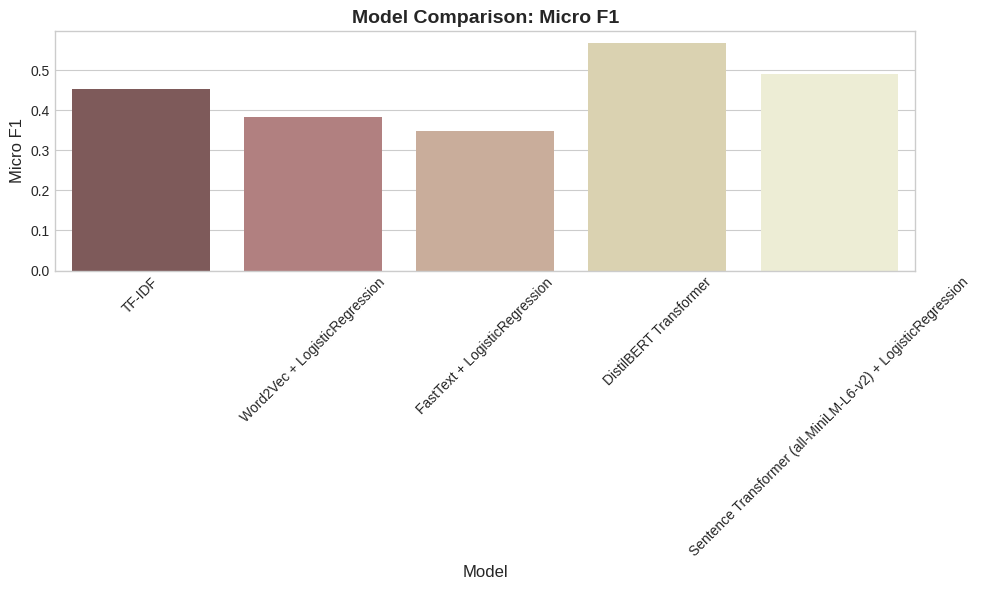

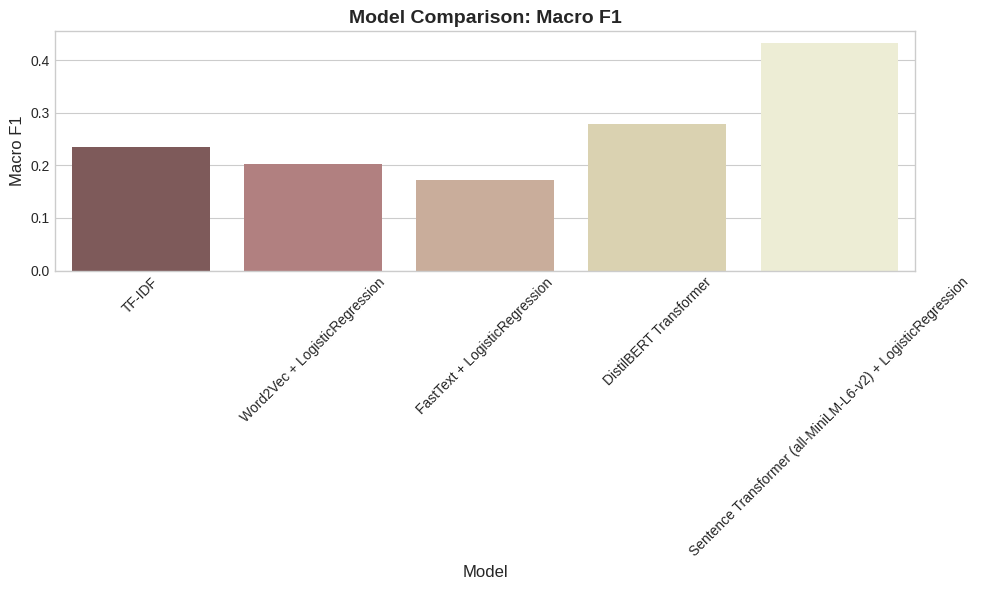

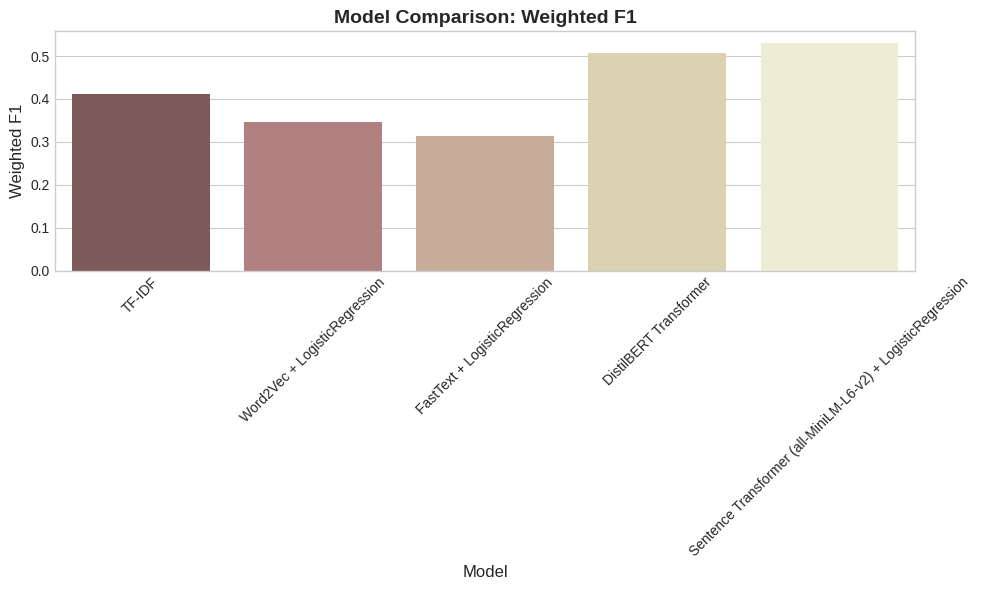

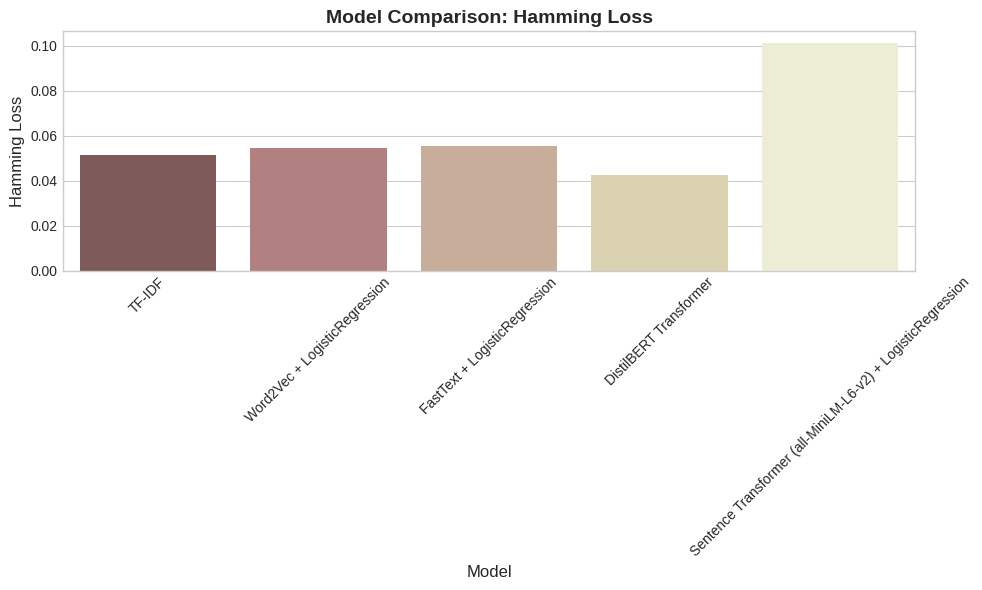

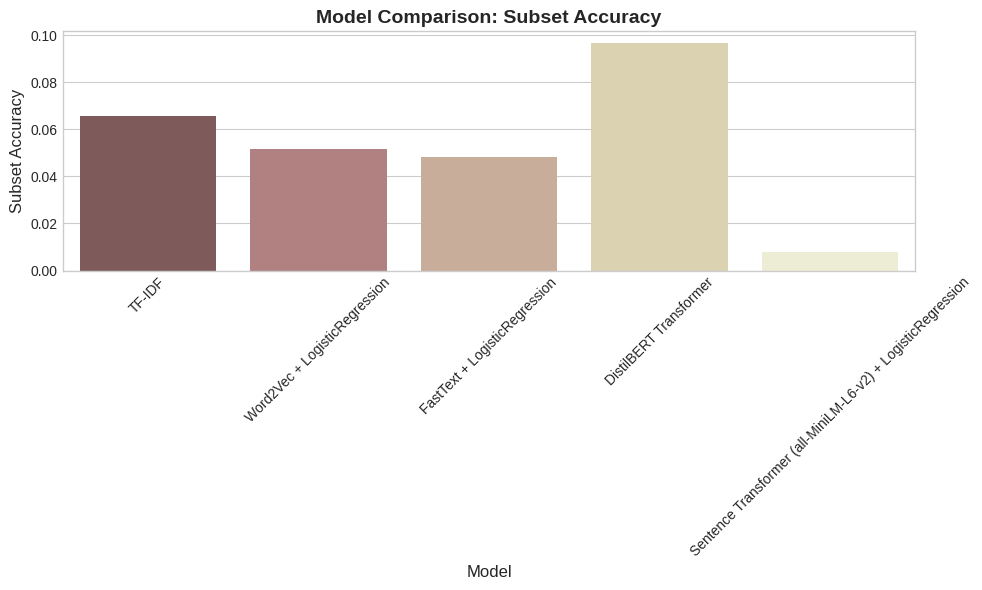

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the metrics to plot
metrics_to_plot = ['Micro F1', 'Macro F1', 'Weighted F1', 'Hamming Loss', 'Subset Accuracy']

# Plot each metric individually
for i, metric in enumerate(metrics_to_plot):
    fig, ax = plt.subplots(figsize=(10, 6)) # Create a new figure for each plot
    sns.barplot(
        x='model',
        y=metric,
        data=results_df_plot,
        ax=ax,
        palette='pink',
        hue='model',
        legend=False
    )
    ax.set_title(f'Model Comparison: {metric}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()

    # Save each plot individually
    filename = f'model_comparison_{metric.lower().replace(' ', '_')}.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')

    plt.show()


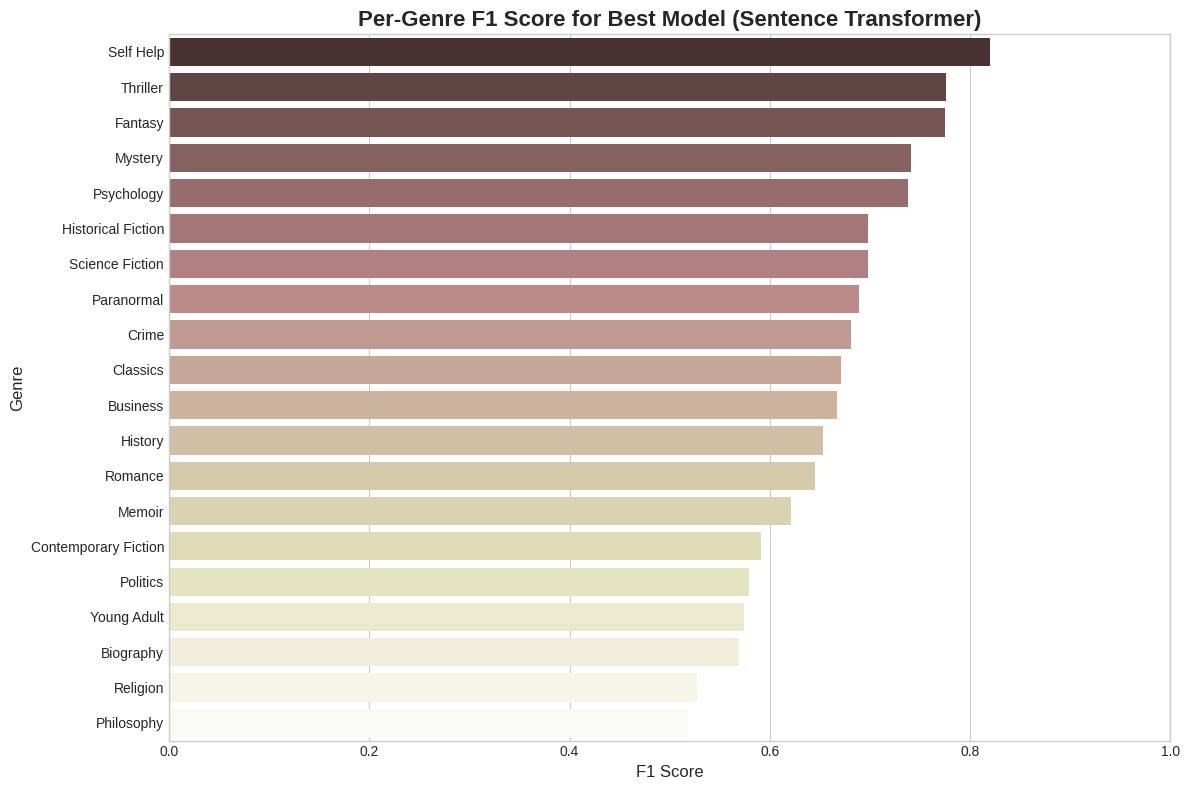

Per-genre F1 score plot for the best model generated.


In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the genre results by F1 score for plotting
genre_results_sorted = genre_results.sort_values('F1', ascending=False)

# Plotting top N genres (e.g., top 20 or all if there are not too many)
# Filtering out genres with 0 F1 score for better visualization of performing genres
plot_genres = genre_results_sorted[genre_results_sorted['F1'] > 0].head(20)

plt.figure(figsize=(12, 8))
sns.barplot(
    x='F1',
    y='Genre',
    data=plot_genres,
    palette='pink',
    hue='Genre', # Use hue to assign different colors per genre
    legend=False # No need for a legend as genres are on the y-axis
)
plt.title('Per-Genre F1 Score for Best Model (Sentence Transformer)', fontsize=16, fontweight='bold')
plt.xlabel('F1 Score', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.xlim(0, 1) # F1 score is between 0 and 1
plt.tight_layout()
plt.savefig('per_genre_f1.png', dpi=150, bbox_inches='tight')
plt.show()

print("Per-genre F1 score plot for the best model generated.")

## Sub-Question Analysis

RQ2: Per-Genre Classification Performance

Genres Ranked by F1-Score (Lowest to Highest):
                        precision  recall  f1-score  support
Magical Realism             0.076   0.440     0.129     25.0
Drama                       0.082   0.500     0.141     62.0
New Adult                   0.084   0.463     0.142     41.0
LGBTQ+ Fiction              0.086   0.500     0.146     38.0
Adult Fiction               0.096   0.634     0.166     41.0
Essays                      0.123   0.630     0.206     27.0
Literary Fiction            0.140   0.690     0.233     71.0
Christian Fiction           0.155   0.638     0.249     47.0
Travel                      0.185   0.600     0.283     25.0
Sociology                   0.177   0.708     0.283     24.0
Asia                        0.200   0.550     0.293     20.0
Dystopia                    0.197   0.657     0.304     70.0
Urban Fantasy               0.200   0.649     0.306     37.0
Erotica                     0.206   0.591     0.306     

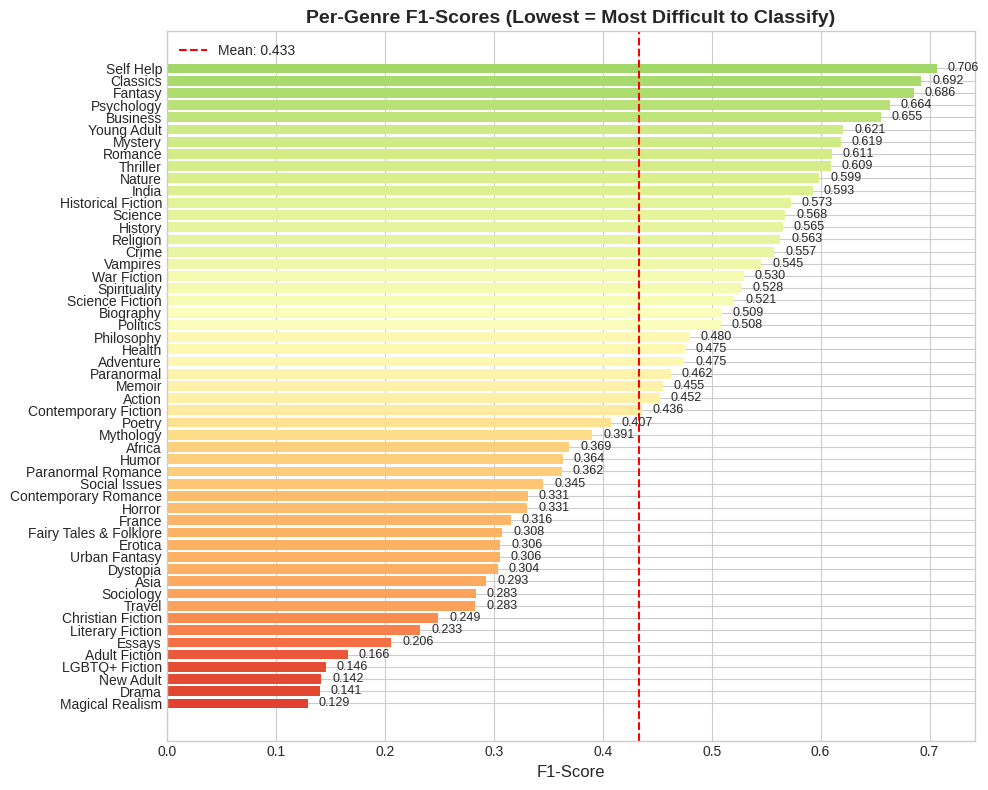


Error Analysis by Genre
                 Genre  True Positives  False Positives  False Negatives  True Negatives  FP Rate  FN Rate
       Magical Realism              11              134               14            1588 0.077816 0.560000
             New Adult              19              208               22            1498 0.121923 0.536585
        LGBTQ+ Fiction              19              203               19            1506 0.118783 0.500000
                 Drama              31              348               31            1337 0.206528 0.500000
                  Asia              11               44                9            1683 0.025478 0.450000
Fairy Tales & Folklore              14               53               10            1670 0.030760 0.416667
               Erotica              13               50                9            1675 0.028986 0.409091
                Travel              15               66               10            1656 0.038328 0.400000
            

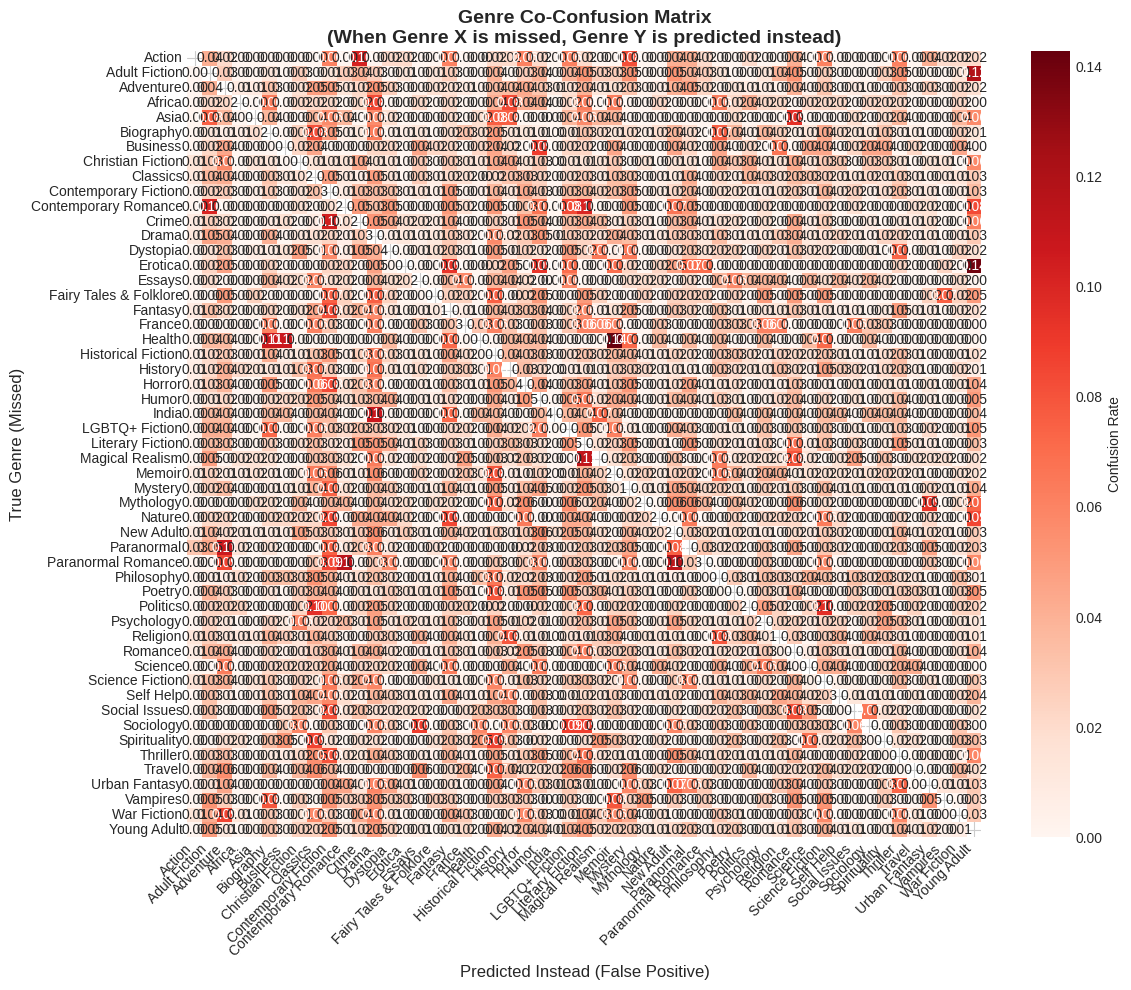


Top 10 Most Confused Genre Pairs
             Genre 1            Genre 2  Mutual Confusion Count Interpretation
Contemporary Fiction            Fantasy                    53.0               
Contemporary Fiction            Mystery                    38.0               
               Drama Historical Fiction                    34.0               
             Fantasy Historical Fiction                    33.0               
Contemporary Fiction Historical Fiction                    33.0               
Contemporary Fiction           Thriller                    32.0               
             Fantasy            Mystery                    31.0               
             Fantasy           Thriller                    30.0               
               Drama            Fantasy                    29.0               
Contemporary Fiction             Horror                    29.0               

RQ2 Interpretation: Genre Boundary Analysis


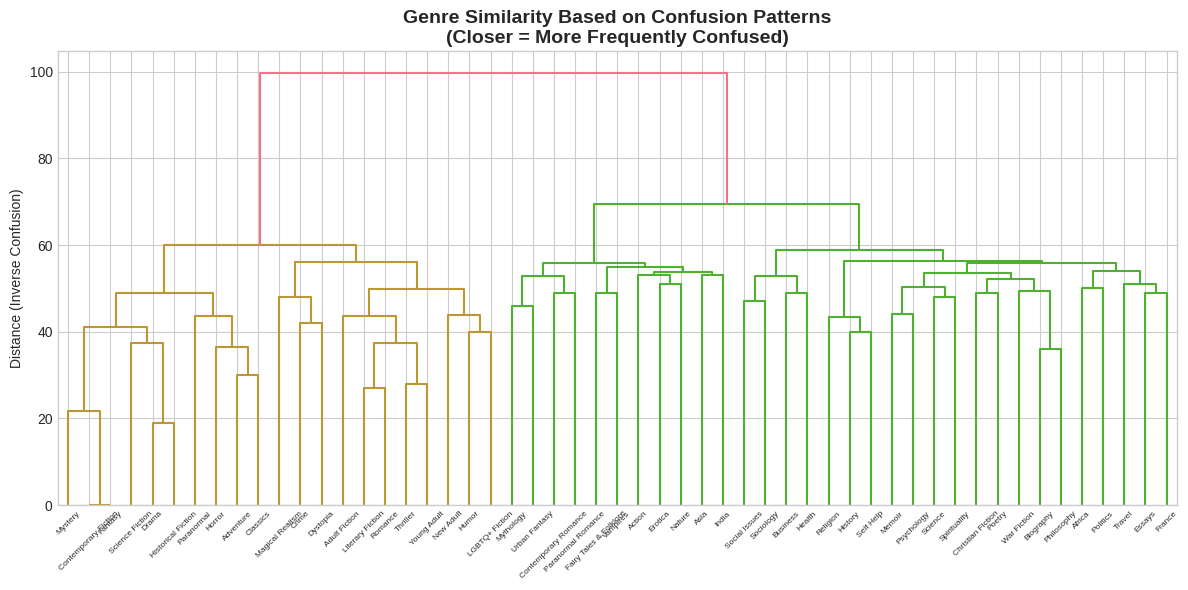

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, classification_report
from itertools import combinations

# RQ2: Which genres are most frequently misclassified?


# Use your best performing model's predictions
y_true = y_test
y_pred = y_pred_best
genre_names = mlb.classes_

# Per-Genre Performance Analysis

print("=" * 60)
print("RQ2: Per-Genre Classification Performance")
print("=" * 60)

# Detailed classification report
report = classification_report(y_true, y_pred, target_names=genre_names, output_dict=True)
genre_performance = pd.DataFrame(report).T.drop(['micro avg', 'macro avg', 'weighted avg', 'samples avg'], errors='ignore')
genre_performance = genre_performance.sort_values('f1-score', ascending=True)

print("\nGenres Ranked by F1-Score (Lowest to Highest):")
print(genre_performance[['precision', 'recall', 'f1-score', 'support']].round(3).to_string())

# Visualization: Per-genre F1 scores
fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.RdYlGn(genre_performance['f1-score'].values)
bars = ax.barh(genre_performance.index, genre_performance['f1-score'], color=colors)
ax.set_xlabel('F1-Score', fontsize=12)
ax.set_title('Per-Genre F1-Scores (Lowest = Most Difficult to Classify)', fontsize=14, fontweight='bold')
ax.axvline(x=genre_performance['f1-score'].mean(), color='red', linestyle='--', label=f'Mean: {genre_performance["f1-score"].mean():.3f}')
ax.legend()

for bar, val in zip(bars, genre_performance['f1-score']):
    ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('rq2_per_genre_f1.png', dpi=300, bbox_inches='tight')
plt.show()

# Multi-Label Confusion Matrix

# Get confusion matrix for each label
mcm = multilabel_confusion_matrix(y_true, y_pred)

# Extract error rates per genre
genre_error_analysis = []
for i, genre in enumerate(genre_names):
    tn, fp, fn, tp = mcm[i].ravel()
    genre_error_analysis.append({
        'Genre': genre,
        'True Positives': tp,
        'False Positives': fp,
        'False Negatives': fn,
        'True Negatives': tn,
        'FP Rate': fp / (fp + tn) if (fp + tn) > 0 else 0,
        'FN Rate': fn / (fn + tp) if (fn + tp) > 0 else 0
    })

error_df = pd.DataFrame(genre_error_analysis)
print("\n" + "=" * 60)
print("Error Analysis by Genre")
print("=" * 60)
print(error_df.sort_values('FN Rate', ascending=False).to_string(index=False))

# Genre Co-Confusion Matrix (Which genres get confused with each other?)

def compute_genre_coconfusion(y_true, y_pred, genre_names):
    """
    Compute how often genre pairs are confused with each other.
    confusion[i,j] = how often genre_j is predicted when genre_i is true (and vice versa)
    """
    n_genres = len(genre_names)
    confusion = np.zeros((n_genres, n_genres))

    for true_row, pred_row in zip(y_true, y_pred):
        true_genres = set(np.where(true_row == 1)[0])
        pred_genres = set(np.where(pred_row == 1)[0])

        # False positives: predicted but not true
        false_positives = pred_genres - true_genres
        # False negatives: true but not predicted
        false_negatives = true_genres - pred_genres

        # For each true genre that was missed, count which genres were predicted instead
        for fn_genre in false_negatives:
            for fp_genre in false_positives:
                confusion[fn_genre, fp_genre] += 1

    return confusion

coconfusion = compute_genre_coconfusion(y_true, y_pred, genre_names)

# Normalize by total errors per genre
coconfusion_normalized = coconfusion / (coconfusion.sum(axis=1, keepdims=True) + 1e-10)

# Visualization: Genre Co-Confusion Heatmap
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.eye(len(genre_names), dtype=bool)  # Mask diagonal
sns.heatmap(coconfusion_normalized,
            xticklabels=genre_names,
            yticklabels=genre_names,
            annot=True,
            fmt='.2f',
            cmap='Reds',
            mask=mask,
            ax=ax,
            cbar_kws={'label': 'Confusion Rate'})
ax.set_xlabel('Predicted Instead (False Positive)', fontsize=12)
ax.set_ylabel('True Genre (Missed)', fontsize=12)
ax.set_title('Genre Co-Confusion Matrix\n(When Genre X is missed, Genre Y is predicted instead)',
             fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('rq2_genre_coconfusion.png', dpi=300, bbox_inches='tight')
plt.show()

# Top Confused Genre Pairs

print("\n" + "=" * 60)
print("Top 10 Most Confused Genre Pairs")
print("=" * 60)

confused_pairs = []
for i, j in combinations(range(len(genre_names)), 2):
    # Bidirectional confusion
    confusion_score = coconfusion[i, j] + coconfusion[j, i]
    if confusion_score > 0:
        confused_pairs.append({
            'Genre 1': genre_names[i],
            'Genre 2': genre_names[j],
            'Mutual Confusion Count': confusion_score,
            'Interpretation': ''
        })

confused_df = pd.DataFrame(confused_pairs).sort_values('Mutual Confusion Count', ascending=False).head(10)
print(confused_df.to_string(index=False))

# Interpretation: What does confusion reveal about genre boundaries?

print("\n" + "=" * 60)
print("RQ2 Interpretation: Genre Boundary Analysis")
print("=" * 60)

# Identify genre clusters based on confusion patterns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

# Create distance matrix from confusion (higher confusion = smaller distance)
similarity = coconfusion + coconfusion.T  # Symmetric
np.fill_diagonal(similarity, 0)
max_sim = similarity.max()
distance = max_sim - similarity + 1e-10  # Convert to distance
np.fill_diagonal(distance, 0)

# Hierarchical clustering
linkage_matrix = linkage(squareform(distance), method='ward')

fig, ax = plt.subplots(figsize=(12, 6))
dendrogram(linkage_matrix, labels=genre_names, leaf_rotation=45, ax=ax)
ax.set_title('Genre Similarity Based on Confusion Patterns\n(Closer = More Frequently Confused)',
             fontsize=14, fontweight='bold')
ax.set_ylabel('Distance (Inverse Confusion)')
plt.tight_layout()
plt.savefig('rq2_genre_clusters.png', dpi=300, bbox_inches='tight')
plt.show()


RQ3: Top Predictive Features per Genre (TF-IDF)

Genre: Action
  jack                 : 0.0195
  reacher              : 0.0136
  jack reacher         : 0.0118
  love                 : 0.0100
  team                 : 0.0092
  military             : 0.0087
  life                 : 0.0083
  force                : 0.0069
  agent                : 0.0066
  enemy                : 0.0065

Genre: Adult Fiction
  love                 : 0.0202
  family               : 0.0126
  life                 : 0.0113
  novel                : 0.0082
  mother               : 0.0078
  town                 : 0.0077
  old                  : 0.0077
  daughter             : 0.0073
  year                 : 0.0070
  woman                : 0.0066

Genre: Adventure
  adventure            : 0.0243
  land                 : 0.0119
  love                 : 0.0103
  quest                : 0.0093
  life                 : 0.0093
  must                 : 0.0093
  work                 : 0.0085
  magic                : 0.0074
 

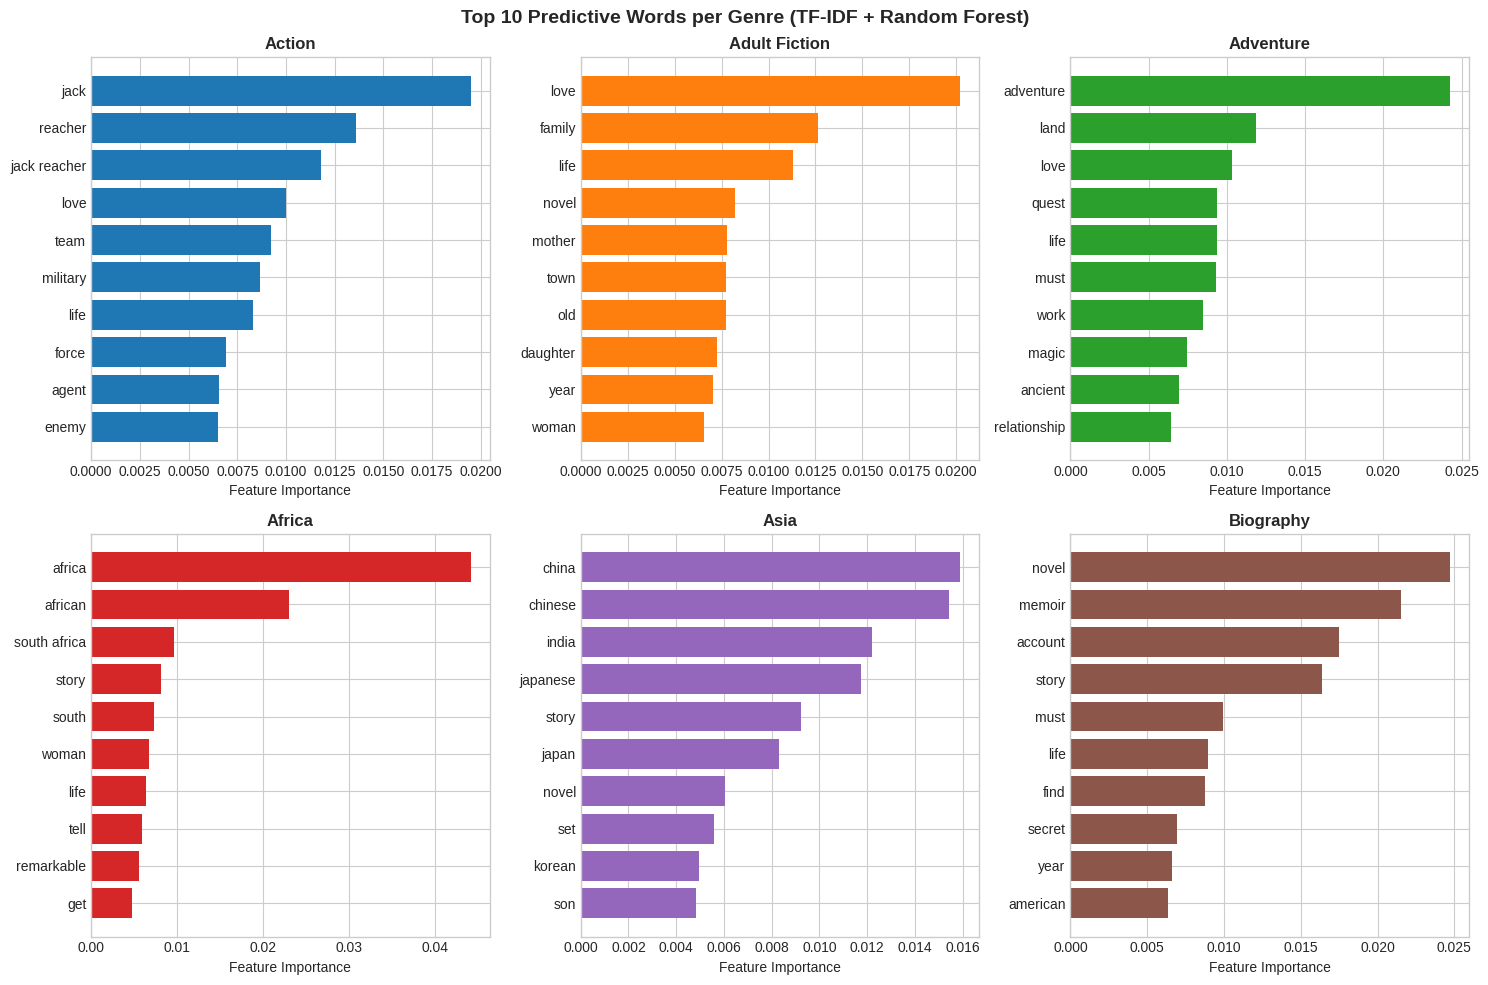


RQ3: Stylistic Features by Genre

Average Stylistic Features by Genre:
--------------------------------------------------------------------------------
                 Genre  Avg Word Count  Avg Word Length  Avg Sentence Length  Vocabulary Richness  Sample Size
                Action          157.35             4.92                17.60                 0.73          110
         Adult Fiction          177.78             4.97                22.16                 0.72          237
             Adventure          145.47             4.96                20.32                 0.73          746
                Africa          174.86             5.01                25.63                 0.71          112
                  Asia          157.73             5.17                25.69                 0.72          113
             Biography          188.54             5.13                24.79                 0.71          717
              Business          220.59             5.26               

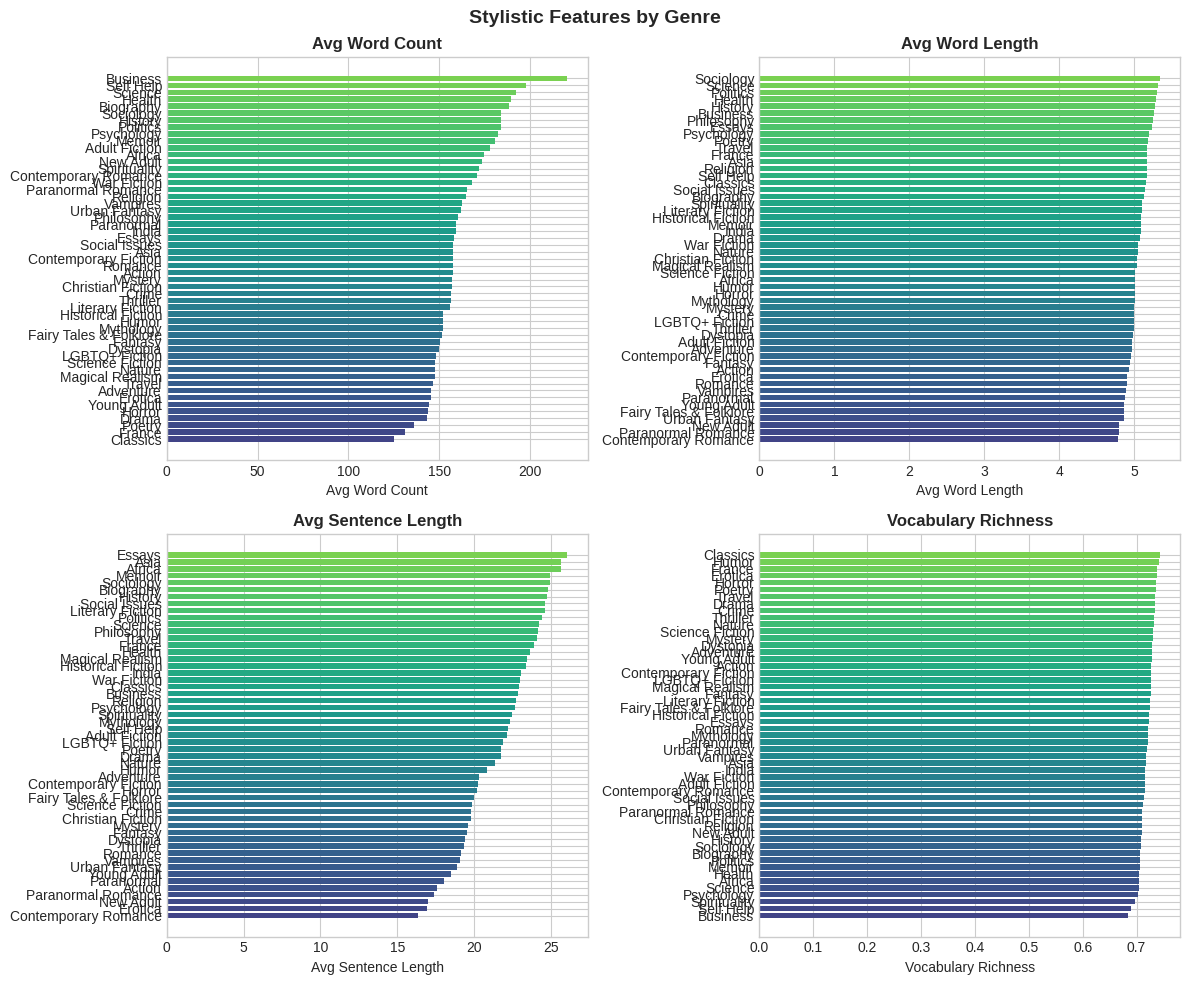


RQ3: Genre-Distinctive Vocabulary (TF-IDF weighted)

Genre-Distinctive Vocabulary:

Action: reacher, world, jack, time, sackett, new, know, man, force, ryan

Adult Fiction: life, love, year, family, story, new, woman, old, world, novel

Adventure: world, life, book, story, time, know, new, year, adventure, secret

Africa: africa, life, story, african, woman, year, world, family, south, book

Asia: life, story, world, china, family, love, year, woman, novel, khan

Biography: life, story, year, world, book, time, family, new, man, make

Business: life, book, world, new, make, work, people, time, business, way

Christian Fiction: god, life, love, book, world, story, new, time, bible, christian

Classics: story, life, novel, world, book, work, new, love, time, year

Contemporary Fiction: life, love, year, new, story, family, world, novel, time, make

Contemporary Romance: love, life, make, want, know, year, new, past, time, woman

Crime: murder, life, year, new, killer, reacher, story, de

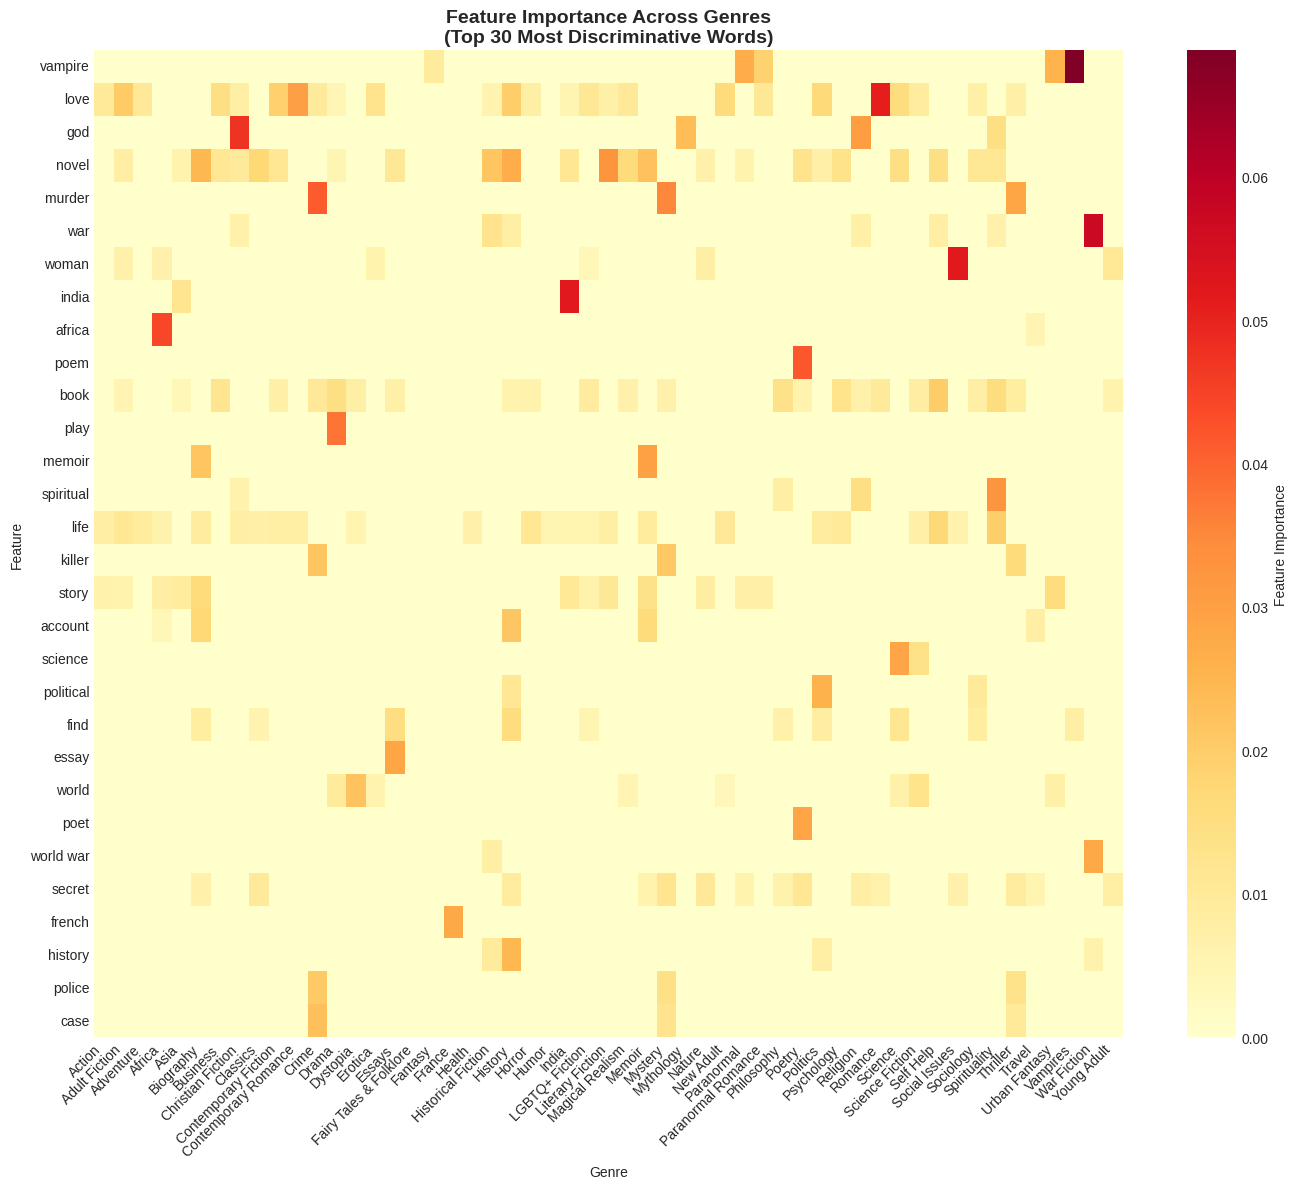

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

# RQ3: What linguistic features are most predictive of specific genres?

# TF-IDF Feature Importance per Genre

print("=" * 60)
print("RQ3: Top Predictive Features per Genre (TF-IDF)")
print("=" * 60)

# Correctly get feature names from the TF-IDF vectorizer within the best_pipeline
# This ensures the feature names match the dimensionality of the feature importances
feature_names = best_pipeline.named_steps['tfidf'].get_feature_names_out()

# For OneVsRestClassifier with RandomForest, extract feature importances
def get_top_features_per_genre(classifier, feature_names, genre_names, top_n=15):
    """Extract top features for each genre from OneVsRestClassifier."""
    results = {}

    # Access the OneVsRestClassifier's estimators
    ovr_classifier = classifier.named_steps['clf']

    for i, (genre, estimator) in enumerate(zip(genre_names, ovr_classifier.estimators_)):
        if hasattr(estimator, 'feature_importances_'):
            # RandomForest
            importances = estimator.feature_importances_
        elif hasattr(estimator, 'coef_'):
            # LogisticRegression
            importances = np.abs(estimator.coef_[0])
        else:
            continue

        top_indices = np.argsort(importances)[-top_n:][::-1]
        top_features = [(feature_names[idx], importances[idx]) for idx in top_indices]
        results[genre] = top_features

    return results

# Assign the best TF-IDF model from GridSearchCV results
best_tfidf_model = best_pipeline # Reference the pipeline trained with best parameters in Model 1.1

top_features = get_top_features_per_genre(best_tfidf_model, feature_names, genre_names, top_n=15)

# Display top features per genre
for genre, features in top_features.items():
    print(f"\n{'='*40}")
    print(f"Genre: {genre}")
    print(f"{'='*40}")
    for word, importance in features[:10]:
        print(f"  {word:20s} : {importance:.4f}")

# Visualization: Top 10 features per genre (subset of genres)
n_genres_to_show = min(6, len(genre_names))
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, genre in enumerate(list(top_features.keys())[:n_genres_to_show]):
    features = top_features[genre][:10]
    words = [f[0] for f in features]
    scores = [f[1] for f in features]

    axes[idx].barh(range(len(words)), scores, color=plt.cm.tab10(idx))
    axes[idx].set_yticks(range(len(words)))
    axes[idx].set_yticklabels(words)
    axes[idx].invert_yaxis()
    axes[idx].set_title(f'{genre}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Feature Importance')

plt.suptitle('Top 10 Predictive Words per Genre (TF-IDF + Random Forest)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('rq3_top_features_per_genre.png', dpi=300, bbox_inches='tight')
plt.show()

# Stylistic Features Analysis

print("\n" + "=" * 60)
print("RQ3: Stylistic Features by Genre")
print("=" * 60)

def compute_stylistic_features(text):
    """Compute stylistic metrics for a text."""
    if pd.isna(text) or text == '':
        return {'word_count': 0, 'avg_word_length': 0, 'sentence_count': 0,
                'vocab_richness': 0, 'avg_sentence_length': 0}

    words = text.lower().split()
    sentences = re.split(r'[.!?]+', text)
    sentences = [s.strip() for s in sentences if s.strip()]

    word_count = len(words)
    avg_word_length = np.mean([len(w) for w in words]) if words else 0
    sentence_count = len(sentences)
    unique_words = len(set(words))
    vocab_richness = unique_words / word_count if word_count > 0 else 0
    avg_sentence_length = word_count / sentence_count if sentence_count > 0 else 0

    return {
        'word_count': word_count,
        'avg_word_length': avg_word_length,
        'sentence_count': sentence_count,
        'vocab_richness': vocab_richness,
        'avg_sentence_length': avg_sentence_length
    }

# Apply to dataframe (use raw Description for stylistic analysis)
stylistic_df = df_model['Description'].apply(compute_stylistic_features).apply(pd.Series)

# Create a DataFrame with one-hot encoded genre columns from df_model['final_genres']
# Ensure the index matches df_model for correct concatenation
df_model_genres_encoded = pd.DataFrame(mlb.transform(df_model['final_genres']),
                                       columns=mlb.classes_,
                                       index=df_model.index)

# Concatenate the encoded genres with the stylistic features
stylistic_df = pd.concat([df_model_genres_encoded, stylistic_df], axis=1)

# Compute average stylistic features per genre
print("\nAverage Stylistic Features by Genre:")
print("-" * 80)

stylistic_by_genre = []
for genre in genre_names:
    genre_subset = stylistic_df[stylistic_df[genre] == 1]
    if len(genre_subset) > 0:
        stylistic_by_genre.append({
            'Genre': genre,
            'Avg Word Count': genre_subset['word_count'].mean(),
            'Avg Word Length': genre_subset['avg_word_length'].mean(),
            'Avg Sentence Length': genre_subset['avg_sentence_length'].mean(),
            'Vocabulary Richness': genre_subset['vocab_richness'].mean(),
            'Sample Size': len(genre_subset)
        })

stylistic_summary = pd.DataFrame(stylistic_by_genre)
print(stylistic_summary.round(2).to_string(index=False))

# Visualization: Stylistic features comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

metrics = ['Avg Word Count', 'Avg Word Length', 'Avg Sentence Length', 'Vocabulary Richness']
for ax, metric in zip(axes.flatten(), metrics):
    sorted_df = stylistic_summary.sort_values(metric, ascending=True)
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(sorted_df)))
    ax.barh(sorted_df['Genre'], sorted_df[metric], color=colors)
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.set_xlabel(metric)

plt.suptitle('Stylistic Features by Genre', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('rq3_stylistic_features.png', dpi=300, bbox_inches='tight')
plt.show()

# Genre-Specific Vocabulary Analysis

print("\n" + "=" * 60)
print("RQ3: Genre-Distinctive Vocabulary (TF-IDF weighted)")
print("=" * 60)

def get_distinctive_words(df, genre_col, text_col, genre_names, top_n=20):
    """
    Find words that are distinctively associated with each genre
    using TF-IDF-like weighting across genres.
    """
    from sklearn.feature_extraction.text import TfidfVectorizer

    # Aggregate all text per genre
    genre_texts = {}
    for genre in genre_names:
        # Ensure the genre column exists in df and filter correctly
        if genre in df.columns:
            genre_mask = df[genre] == 1
            # Filter df_model to get the original texts for this genre
            # Assuming df_model has a unique index, using loc with the index of df_model
            original_texts_for_genre = df_model.loc[df_model_genres_encoded.index[genre_mask], text_col].fillna('').astype(str)
            genre_texts[genre] = ' '.join(original_texts_for_genre)
        else:
            genre_texts[genre] = '' # Handle case where genre might not be in columns

    # Fit TF-IDF on genre-level documents
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    genre_tfidf = vectorizer.fit_transform(list(genre_texts.values()))
    features = vectorizer.get_feature_names_out()

    distinctive_words = {}
    for i, genre in enumerate(genre_names):
        scores = genre_tfidf[i].toarray().flatten()
        top_indices = np.argsort(scores)[-top_n:][::-1]
        distinctive_words[genre] = [(features[idx], scores[idx]) for idx in top_indices if scores[idx] > 0]

    return distinctive_words

# Use cleaned text column
# This part needs to ensure df_model still refers to the original DataFrame for 'tokens' or 'cleaned_description'
# as stylistic_df now has genres as columns.
text_column = 'tokens' if 'tokens' in df_model.columns else 'cleaned_description'
if text_column == 'tokens':
    df_model['text_for_analysis'] = df_model['tokens'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
else:
    df_model['text_for_analysis'] = df_model[text_column]

# The get_distinctive_words function now expects the DataFrame with genre columns (stylistic_df) for filtering
distinctive = get_distinctive_words(df_model_genres_encoded, genre_names[0], 'text_for_analysis', genre_names, top_n=15)

print("\nGenre-Distinctive Vocabulary:")
for genre, words in distinctive.items():
    print(f"\n{genre}: {', '.join([w[0] for w in words[:10]])}")

# N-gram Analysis

print("\n" + "=" * 60)
print("RQ3: Predictive Phrases (Bigrams) per Genre")
print("=" * 60)

from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams_per_genre(df, text_col, genre_names, ngram_range=(2,2), top_n=10):
    """Extract top n-grams for each genre."""
    results = {}

    for genre in genre_names:
        # Ensure the genre column exists in df and filter correctly
        if genre in df.columns:
            genre_mask = df[genre] == 1
            # Filter df_model to get the original texts for this genre
            original_texts_for_genre = df_model.loc[df_model_genres_encoded.index[genre_mask], text_col].fillna('').astype(str)
            genre_texts = original_texts_for_genre.tolist()
        else:
            genre_texts = []

        if len(genre_texts) == 0:
            continue

        vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=1000, stop_words='english')
        try:
            ngram_counts = vectorizer.fit_transform(genre_texts)
            ngram_freq = np.array(ngram_counts.sum(axis=0)).flatten()
            features = vectorizer.get_feature_names_out()

            top_indices = np.argsort(ngram_freq)[-top_n:][::-1]
            results[genre] = [(features[idx], ngram_freq[idx]) for idx in top_indices]
        except:
            results[genre] = []

    return results

bigrams = get_top_ngrams_per_genre(df_model_genres_encoded, 'text_for_analysis', genre_names, ngram_range=(2,2), top_n=10)

for genre, phrases in bigrams.items():
    if phrases:
        print(f"\n{genre}:")
        for phrase, count in phrases[:5]:
            print(f"  '{phrase}' ({int(count)} occurrences)")

# Summary Visualization: Feature Importance Heatmap

# Create a matrix of top features vs genres
all_top_words = set()
for features in top_features.values():
    all_top_words.update([f[0] for f in features[:10]])

# Build importance matrix
importance_matrix = pd.DataFrame(0.0, index=list(all_top_words), columns=genre_names)
for genre, features in top_features.items():
    for word, importance in features:
        if word in importance_matrix.index:
            importance_matrix.loc[word, genre] = importance

# Select most variable features
feature_variance = importance_matrix.var(axis=1)
top_variable_features = feature_variance.nlargest(30).index

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(importance_matrix.loc[top_variable_features],
            cmap='YlOrRd',
            annot=False,
            ax=ax,
            cbar_kws={'label': 'Feature Importance'})
ax.set_title('Feature Importance Across Genres\n(Top 30 Most Discriminative Words)', fontsize=14, fontweight='bold')
ax.set_xlabel('Genre')
ax.set_ylabel('Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('rq3_feature_importance_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## Export all results

In [122]:
import pandas as pd
import joblib
from datetime import datetime
import os
import torch

# Create output directory
output_dir = 'exported_results'
os.makedirs(output_dir, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# 1. Export aggregated model performance metrics
results_df_plot.to_csv(f'{output_dir}/aggregated_model_metrics_{timestamp}.csv', index=False)
print(f"- Aggregated model metrics exported to {output_dir}/aggregated_model_metrics_{timestamp}.csv")

# 2. Export per-genre F1 scores for the best model (Sentence Transformer)
genre_results.to_csv(f'{output_dir}/per_genre_f1_best_model_{timestamp}.csv', index=False)
print(f"- Per-genre F1 scores for best model exported to {output_dir}/per_genre_f1_best_model_{timestamp}.csv")

# 3. Export per-genre performance from error analysis
genre_performance.to_csv(f'{output_dir}/genre_performance_analysis_{timestamp}.csv')
print(f"- Per-genre performance analysis exported to {output_dir}/genre_performance_analysis_{timestamp}.csv")

# 4. Export error analysis (FP and FN rates)
error_df.to_csv(f'{output_dir}/genre_error_rates_{timestamp}.csv', index=False)
print(f"- Genre error rates exported to {output_dir}/genre_error_rates_{timestamp}.csv")

# 5. Export confused genre pairs
if 'confused_df' in locals():
    confused_df.to_csv(f'{output_dir}/confused_genre_pairs_{timestamp}.csv', index=False)
    print(f"- Confused genre pairs exported to {output_dir}/confused_genre_pairs_{timestamp}.csv")
else:
    print("- No 'confused_df' found to export.")

# 6. Export stylistic features by genre
stylistic_summary.to_csv(f'{output_dir}/stylistic_features_by_genre_{timestamp}.csv', index=False)
print(f"- Stylistic features by genre exported to {output_dir}/stylistic_features_by_genre_{timestamp}.csv")

# 7. Export top features per genre
features_data = []
for genre, feats in top_features.items():
    for word, importance in feats:
        features_data.append({'Genre': genre, 'Feature': word, 'Importance': importance})
pd.DataFrame(features_data).to_csv(f'{output_dir}/top_features_per_genre_{timestamp}.csv', index=False)
print(f"- Top features per genre exported to {output_dir}/top_features_per_genre_{timestamp}.csv")

# 8. Export distinctive words per genre
distinctive_data = []
for genre, words in distinctive.items():
    for word, score in words:
        distinctive_data.append({'Genre': genre, 'Word': word, 'Score': score})
pd.DataFrame(distinctive_data).to_csv(f'{output_dir}/distinctive_words_per_genre_{timestamp}.csv', index=False)
print(f"- Distinctive words per genre exported to {output_dir}/distinctive_words_per_genre_{timestamp}.csv")

# 9. Export top bigrams per genre
bigrams_data = []
for genre, phrases in bigrams.items():
    for phrase, count in phrases:
        bigrams_data.append({'Genre': genre, 'Phrase': phrase, 'Count': count})
pd.DataFrame(bigrams_data).to_csv(f'{output_dir}/bigrams_per_genre_{timestamp}.csv', index=False)
print(f"- Bigrams per genre exported to {output_dir}/bigrams_per_genre_{timestamp}.csv")

# --- Save Models and Encoders ---
print("\n--- Saving Models and Encoders ---")

# MultiLabelBinarizer
joblib.dump(mlb, f'{output_dir}/mlb_encoder_{timestamp}.joblib')
print(f"- MultiLabelBinarizer saved to {output_dir}/mlb_encoder_{timestamp}.joblib")

# TF-IDF Pipeline (best_pipeline contains TfidfVectorizer and OneVsRestClassifier)
joblib.dump(best_pipeline, f'{output_dir}/tfidf_randomforest_pipeline_{timestamp}.joblib')
print(f"- TF-IDF RandomForest Pipeline saved to {output_dir}/tfidf_randomforest_pipeline_{timestamp}.joblib")

# Word2Vec model and classifier
if 'w2v_model' in locals():
    w2v_model.save(f'{output_dir}/word2vec_model_{timestamp}.model')
    joblib.dump(best_w2v_clf, f'{output_dir}/word2vec_logistic_regression_{timestamp}.joblib')
    print(f"- Word2Vec model and Logistic Regression classifier saved to {output_dir}/")
else:
    print("- Word2Vec model not found to save.")

# FastText model and classifier
if 'fasttext_model' in locals():
    fasttext_model.save(f'{output_dir}/fasttext_model_{timestamp}.model')
    joblib.dump(best_fasttext_clf, f'{output_dir}/fasttext_logistic_regression_{timestamp}.joblib')
    print(f"- FastText model and Logistic Regression classifier saved to {output_dir}/")
else:
    print("- FastText model not found to save.")

# DistilBERT Transformer model
if 'final_model' in locals():
    torch.save(final_model.state_dict(), f'{output_dir}/distilbert_transformer_model_state_dict_{timestamp}.pt')
    # Also save the tokenizer config if needed, though it's easily reloaded
    tokenizer.save_pretrained(f'{output_dir}/distilbert_tokenizer_{timestamp}')
    print(f"- DistilBERT Transformer model state_dict and tokenizer saved to {output_dir}/")
else:
    print("- DistilBERT Transformer model not found to save.")

# Sentence Transformer model and classifier
if 'sbert_model' in locals():
    # SentenceTransformer models save themselves as a directory
    sbert_model.save(f'{output_dir}/sentence_transformer_encoder_{timestamp}')
    joblib.dump(best_sbert_clf, f'{output_dir}/sentence_transformer_logistic_regression_{timestamp}.joblib')
    print(f"- Sentence Transformer encoder and Logistic Regression classifier saved to {output_dir}/")
else:
    print("- Sentence Transformer model not found to save.")

print(f"\nAll requested data and models have been exported to the '{output_dir}/' directory.")

- Aggregated model metrics exported to exported_results/aggregated_model_metrics_20260131_111620.csv
- Per-genre F1 scores for best model exported to exported_results/per_genre_f1_best_model_20260131_111620.csv
- Per-genre performance analysis exported to exported_results/genre_performance_analysis_20260131_111620.csv
- Genre error rates exported to exported_results/genre_error_rates_20260131_111620.csv
- Confused genre pairs exported to exported_results/confused_genre_pairs_20260131_111620.csv
- Stylistic features by genre exported to exported_results/stylistic_features_by_genre_20260131_111620.csv
- Top features per genre exported to exported_results/top_features_per_genre_20260131_111620.csv
- Distinctive words per genre exported to exported_results/distinctive_words_per_genre_20260131_111620.csv
- Bigrams per genre exported to exported_results/bigrams_per_genre_20260131_111620.csv

--- Saving Models and Encoders ---
- MultiLabelBinarizer saved to exported_results/mlb_encoder_202601